__Author: Martin Ng__    
__Date: 28/01/21__

Purpose of this notebook is to explore the POALoanData set, to explore and understand the dataset and the various features

# Load Dependencies

In [2]:
# import dependencies
import warnings
from string import ascii_letters

# data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, chi2, chi2_contingency, boxcox, yeojohnson

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# EDA
from pandas_profiling import ProfileReport

# sklearn
import sklearn
from sklearn.impute import SimpleImputer

# Load Data

In [3]:
dtype_var = {
     'LoanId': object,
     'VerificationType': 'Int64',
     'HomeOwnershipType': object,
     'LanguageCode': object,
     'MaritalStatus': object,
     'NrOfDependants': object,
     'Education': object,
     'EmploymentDurationCurrentEmployer': object,
     'EmploymentStatus': object,
     'OccupationArea': object,
     'WorkExperience': object,
     'Country': object,
     'Gender': object}

df = pd.read_csv("../../Data/Processed/POALoanData.csv", dtype=dtype_var)


In [4]:
df.shape

(71969, 31)

In [5]:
# parse date variable
df['LoanApplicationStartedDate'] = pd.to_datetime(df['LoanApplicationStartedDate'], format='%Y-%m-%d %H:%M:%S')

In [6]:
# change all column name to lower string
df.columns = df.columns.str.lower()

In [7]:
# set view as df.head().T. Transposed to allow for better readability
view = df.head().T

# insert dtype column in view
view.insert(0,"dtype", df.dtypes)

view

dtype  \
defaulted                                        int64   
loanid                                          object   
username                                        object   
loanapplicationstarteddate              datetime64[ns]   
languagecode                                    object   
age                                              int64   
gender                                          object   
country                                         object   
appliedamount                                  float64   
interest                                       float64   
loanduration                                     int64   
education                                       object   
maritalstatus                                   object   
nrofdependants                                  object   
employmentstatus                                object   
employmentdurationcurrentemployer               object   
workexperience                                  object   
occupationarea                                  object   
homeownershiptype                               object   
incometotal                                    float64   
incomefromsalary                               float64   
incomefromothers                               float64   
existingliabilities                              int64   
liabilitiestotal                               float64   
debttoincome                                   float64   
noofearlierdefaults                              int64   
noofpreviousloansbeforeloan                      int64   
amountofpreviousloansbeforeloan                float64   
priorrepayments                                float64   
previousearlyrepaymentsbeforeloan              float64   
previousearlyrepaymentscountbeforeloan           int64   

                                                                           0  \
defaulted                                                                  0   
loanid                                  40475564-DF76-4CCB-89E9-A29A00DF1A5A   
username                                                            -inline-   
loanapplicationstarteddate                               2013-12-20 13:32:00   
languagecode                                                               1   
age                                                                       26   
gender                                                                     0   
country                                                                   EE   
appliedamount                                                            700   
interest                                                                  28   
loanduration                                                              18   
education                                                                  3   
maritalstatus                                                              3   
nrofdependants                                                             0   
employmentstatus                                                           3   
employmentdurationcurrentemployer                             MoreThan5Years   
workexperience                                                    5To10Years   
occupationarea                                                            13   
homeownershiptype                                                          3   
incometotal                                                              879   
incomefromsalary                                                         879   
incomefromothers                                                           0   
existingliabilities                                                        7   
liabilitiestotal                                                         680   
debttoincome                                                            22.3   
noofearlierdefaults                                                        0   
noofpreviousloansbeforeloan     

Data seems to be loaded correctly.

In [8]:
# load database as db_df
dtype_var = {
     'loanid': object,
     'verificationtype': 'Int64',
     'nrofdependants': object,
     'workexperience': object,
     'homeownershiptype': object,
     'languagecode': object,
     'maritalstatus': object,
     'nrofdependants': object,
     'education': object,
     'employmentdurationcurrentemployer': object,
     'employmentstatus': object,
     'occupationarea': object,
     'workExperience': object,
     'country': object,
     'gender': object}


db_df = pd.read_csv("../../Data/Processed/Database.csv", dtype=dtype_var)

db_df['loanapplicationstarteddate'] = pd.to_datetime(db_df['loanapplicationstarteddate'], format='%Y-%m-%d %H:%M:%S')
db_df['defaultdate'] = pd.to_datetime(db_df['defaultdate'], format='%Y-%m-%d')
db_df['loandate'] = pd.to_datetime(db_df['loandate'], format='%Y-%m-%d')

# Test-Train Split

Having loaded the POA dataset, we will carry out Test-Train split for unbiased evaluation of the analytics model to be developed. In our situation, the test-train split must be considerate to the time aspect of how new transactions and data would be coming into the model, given that there will be some applications belonging to usernames or clients who may have earlier transactions with the financial institution.

In short, in our situation, the temporal order in which the data is observed must be respected, else we may risk target/data leakage

As such, we will split the dataset into a "past" training dataset and a "future" testing dataset based on the loan application date, in this case, the feature `loanapplicationstarteddate`.

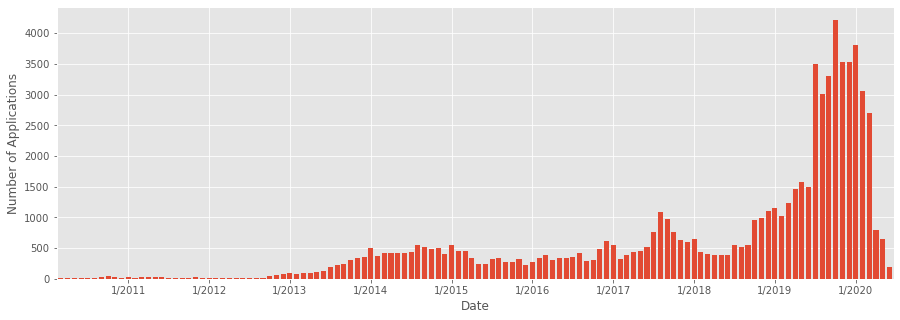

In [9]:
# check distribution of loan applications with time
data = df.groupby([df['loanapplicationstarteddate'].dt.year, df['loanapplicationstarteddate'].dt.month]).size()


label_pos = []
label = []
for x in range(len(data.index)):
    if 1 in data.index[x]:
        label_pos.append(x)
        label.append(str(data.index[x][1]) + '/' + str(data.index[x][0]))

plt.style.use('ggplot')

data.plot(kind='bar', figsize=(15, 5), rot=0, width=0.75)

plt.xticks(label_pos, label)
plt.xlabel('Date')
plt.ylabel('Number of Applications')

# plt.savefig('fig1.jpeg') # save image
plt.show()


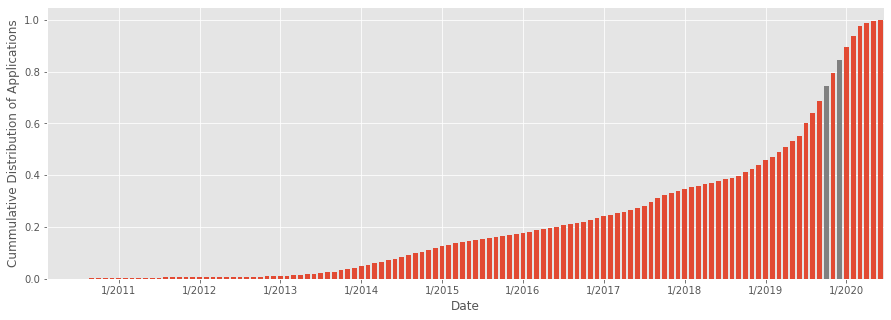

In [11]:
# check cummulative distribution of loan applications with time
data = df.groupby([df['loanapplicationstarteddate'].dt.year, df['loanapplicationstarteddate'].dt.month]).size().cumsum()/len(df)

label_pos = []
label = []
pct_80_pos = []
pct_70_pos = []

plt.style.use('ggplot')

data.plot(kind='bar', figsize=(15, 5), rot=0, width=0.7)

for x in range(len(data.index)):
    if 1 in data.index[x]:
        label_pos.append(x)
        label.append(str(data.index[x][1]) + '/' + str(data.index[x][0]))
    
    if data.values[x] >= 0.8: # grey out the bar representing 80%
        pct_80_pos.append(x)
        
    if data.values[x] >= 0.7: # grey out the bar representing 70%
        pct_70_pos.append(x)
        
pct_80_pos = min(pct_80_pos)
pct_80_val = data.values[pct_80_pos]  
plt.bar(pct_80_pos, pct_80_val, color='grey')

pct_70_pos = min(pct_70_pos)
pct_70_val = data.values[pct_70_pos]  
plt.bar(pct_70_pos, pct_70_val, color='grey')


plt.xticks(label_pos, label)
plt.xlabel('Date')
plt.ylabel('Cummulative Distribution of Applications')
#  plt.savefig('fig2.jpeg') # save image
plt.show()

We see that the number of loan applications is not uniform with time and its popularity increases over time. To split the dataset, lets go ahead with an 80:20 split

In [12]:
# first sort by loanapplicationstarteddate
df.sort_values('loanapplicationstarteddate', inplace=True, ignore_index=True)
# split using np.split with 80%
train, test= np.split(df, [int(0.8 *len(df))])

## Issues with Test-Train Split Dataset

In [13]:
# check the train dataset
train.describe()

defaulted           age  appliedamount      interest  loanduration  \
count  57575.000000  57575.000000   57575.000000  57575.000000  57575.000000   
mean       0.227599     40.369692    2991.880965     43.642945     47.669457   
std        0.419286     12.562615    2365.697060     29.975873     14.805496   
min        0.000000     18.000000      31.955800      3.000000      1.000000   
25%        0.000000     30.000000    1380.000000     28.000000     36.000000   
50%        0.000000     39.000000    2126.000000     35.460000     60.000000   
75%        0.000000     50.000000    4150.000000     57.760000     60.000000   
max        1.000000     75.000000   10632.000000    264.310000     60.000000   

        incometotal  incomefromsalary  incomefromothers  existingliabilities  \
count  5.757500e+04      57575.000000      57575.000000         57575.000000   
mean   1.732392e+03        410.220183         55.341813             2.578671   
std    6.823395e+03       1353.807862        339.331912             3.124292   
min    0.000000e+00          0.000000          0.000000             0.000000   
25%    9.000000e+02          0.000000          0.000000             0.000000   
50%    1.300000e+03          0.000000          0.000000             2.000000   
75%    1.962000e+03        600.000000          0.000000             4.000000   
max    1.012019e+06     228400.000000      25000.000000            36.000000   

       liabilitiestotal  debttoincome  noofearlierdefaults  \
count      5.757500e+04  57575.000000         57575.000000   
mean       6.809746e+02      9.921500             0.000087   
std        5.169712e+04     17.655761             0.009319   
min        0.000000e+00      0.000000             0.000000   
25%        0.000000e+00      0.000000             0.000000   
50%        2.830000e+02      0.000000             0.000000   
75%        6.370000e+02     14.900000             0.000000   
max        1.240000e+07    110.440000             1.000000   

       noofpreviousloansbeforeloan  amountofpreviousloansbeforeloan  \
count                 57575.000000                     57575.000000   
mean                      0.317134                       744.546258   
std                       0.646966                      1767.045129   
min                       0.000000                         0.000000   
25%                       0.000000                         0.000000   
50%                       0.000000                         0.000000   
75%                       0.000000                         0.000000   
max                      12.000000                     27315.000000   

       priorrepayments  previousearlyrepaymentsbeforeloan  \
count     57575.000000                       26773.000000   
mean        175.142457                         202.636836   
std         793.581326                        1250.107246   
min           0.000000                           0.000000   
25%           0.000000                           0.000000   
50%           0.000000                           0.000000   
75%           0.000000                           0.000000   
max       28093.120000                       41755.000000   

       previousearlyrepaymentscountbeforeloan  
count                            57575.000000  
mean                                 0.036005  
std                                  0.251730  
min                                  0.000000  
25%                                  0.000000  
50%                                  0.000000  
75%                                  0.000000  
max                                  9.000000

In [14]:
# check amount of missing values in train dataset
train.isna().sum()

defaulted                                     0
loanid                                        0
username                                      0
loanapplicationstarteddate                    0
languagecode                                  0
age                                           0
gender                                        0
country                                       0
appliedamount                                 0
interest                                      0
loanduration                                  0
education                                     0
maritalstatus                                 0
nrofdependants                            39009
employmentstatus                             32
employmentdurationcurrentemployer           315
workexperience                            38493
occupationarea                                0
homeownershiptype                           117
incometotal                                   0
incomefromsalary                        

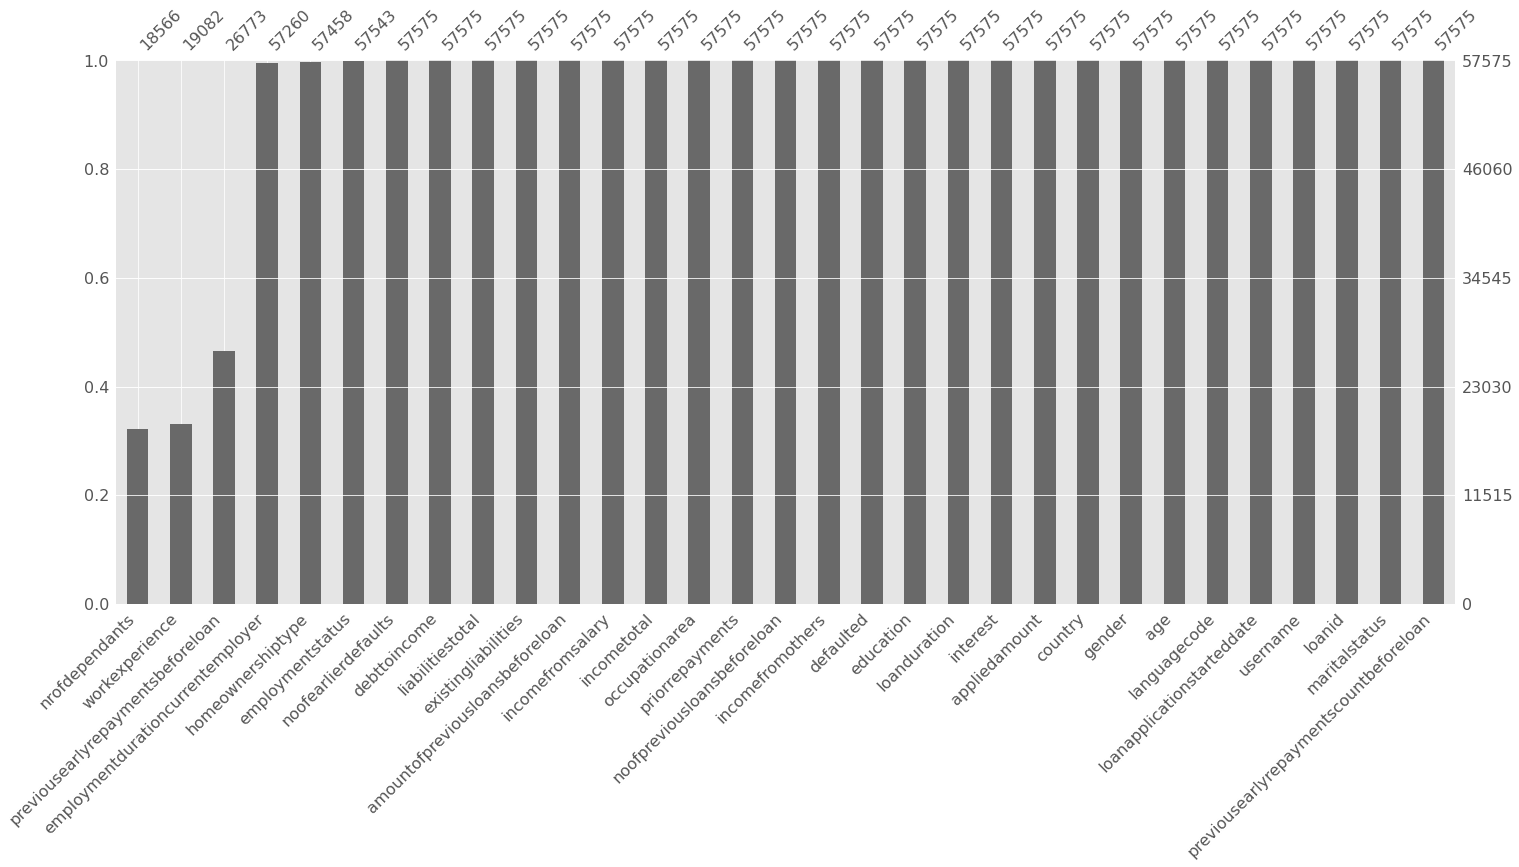

In [15]:
# plot missing values visualisation
plt.style.use('ggplot')
msno.bar(train, sort='ascending')
# plt.savefig('fig3.jpeg')
plt.show()

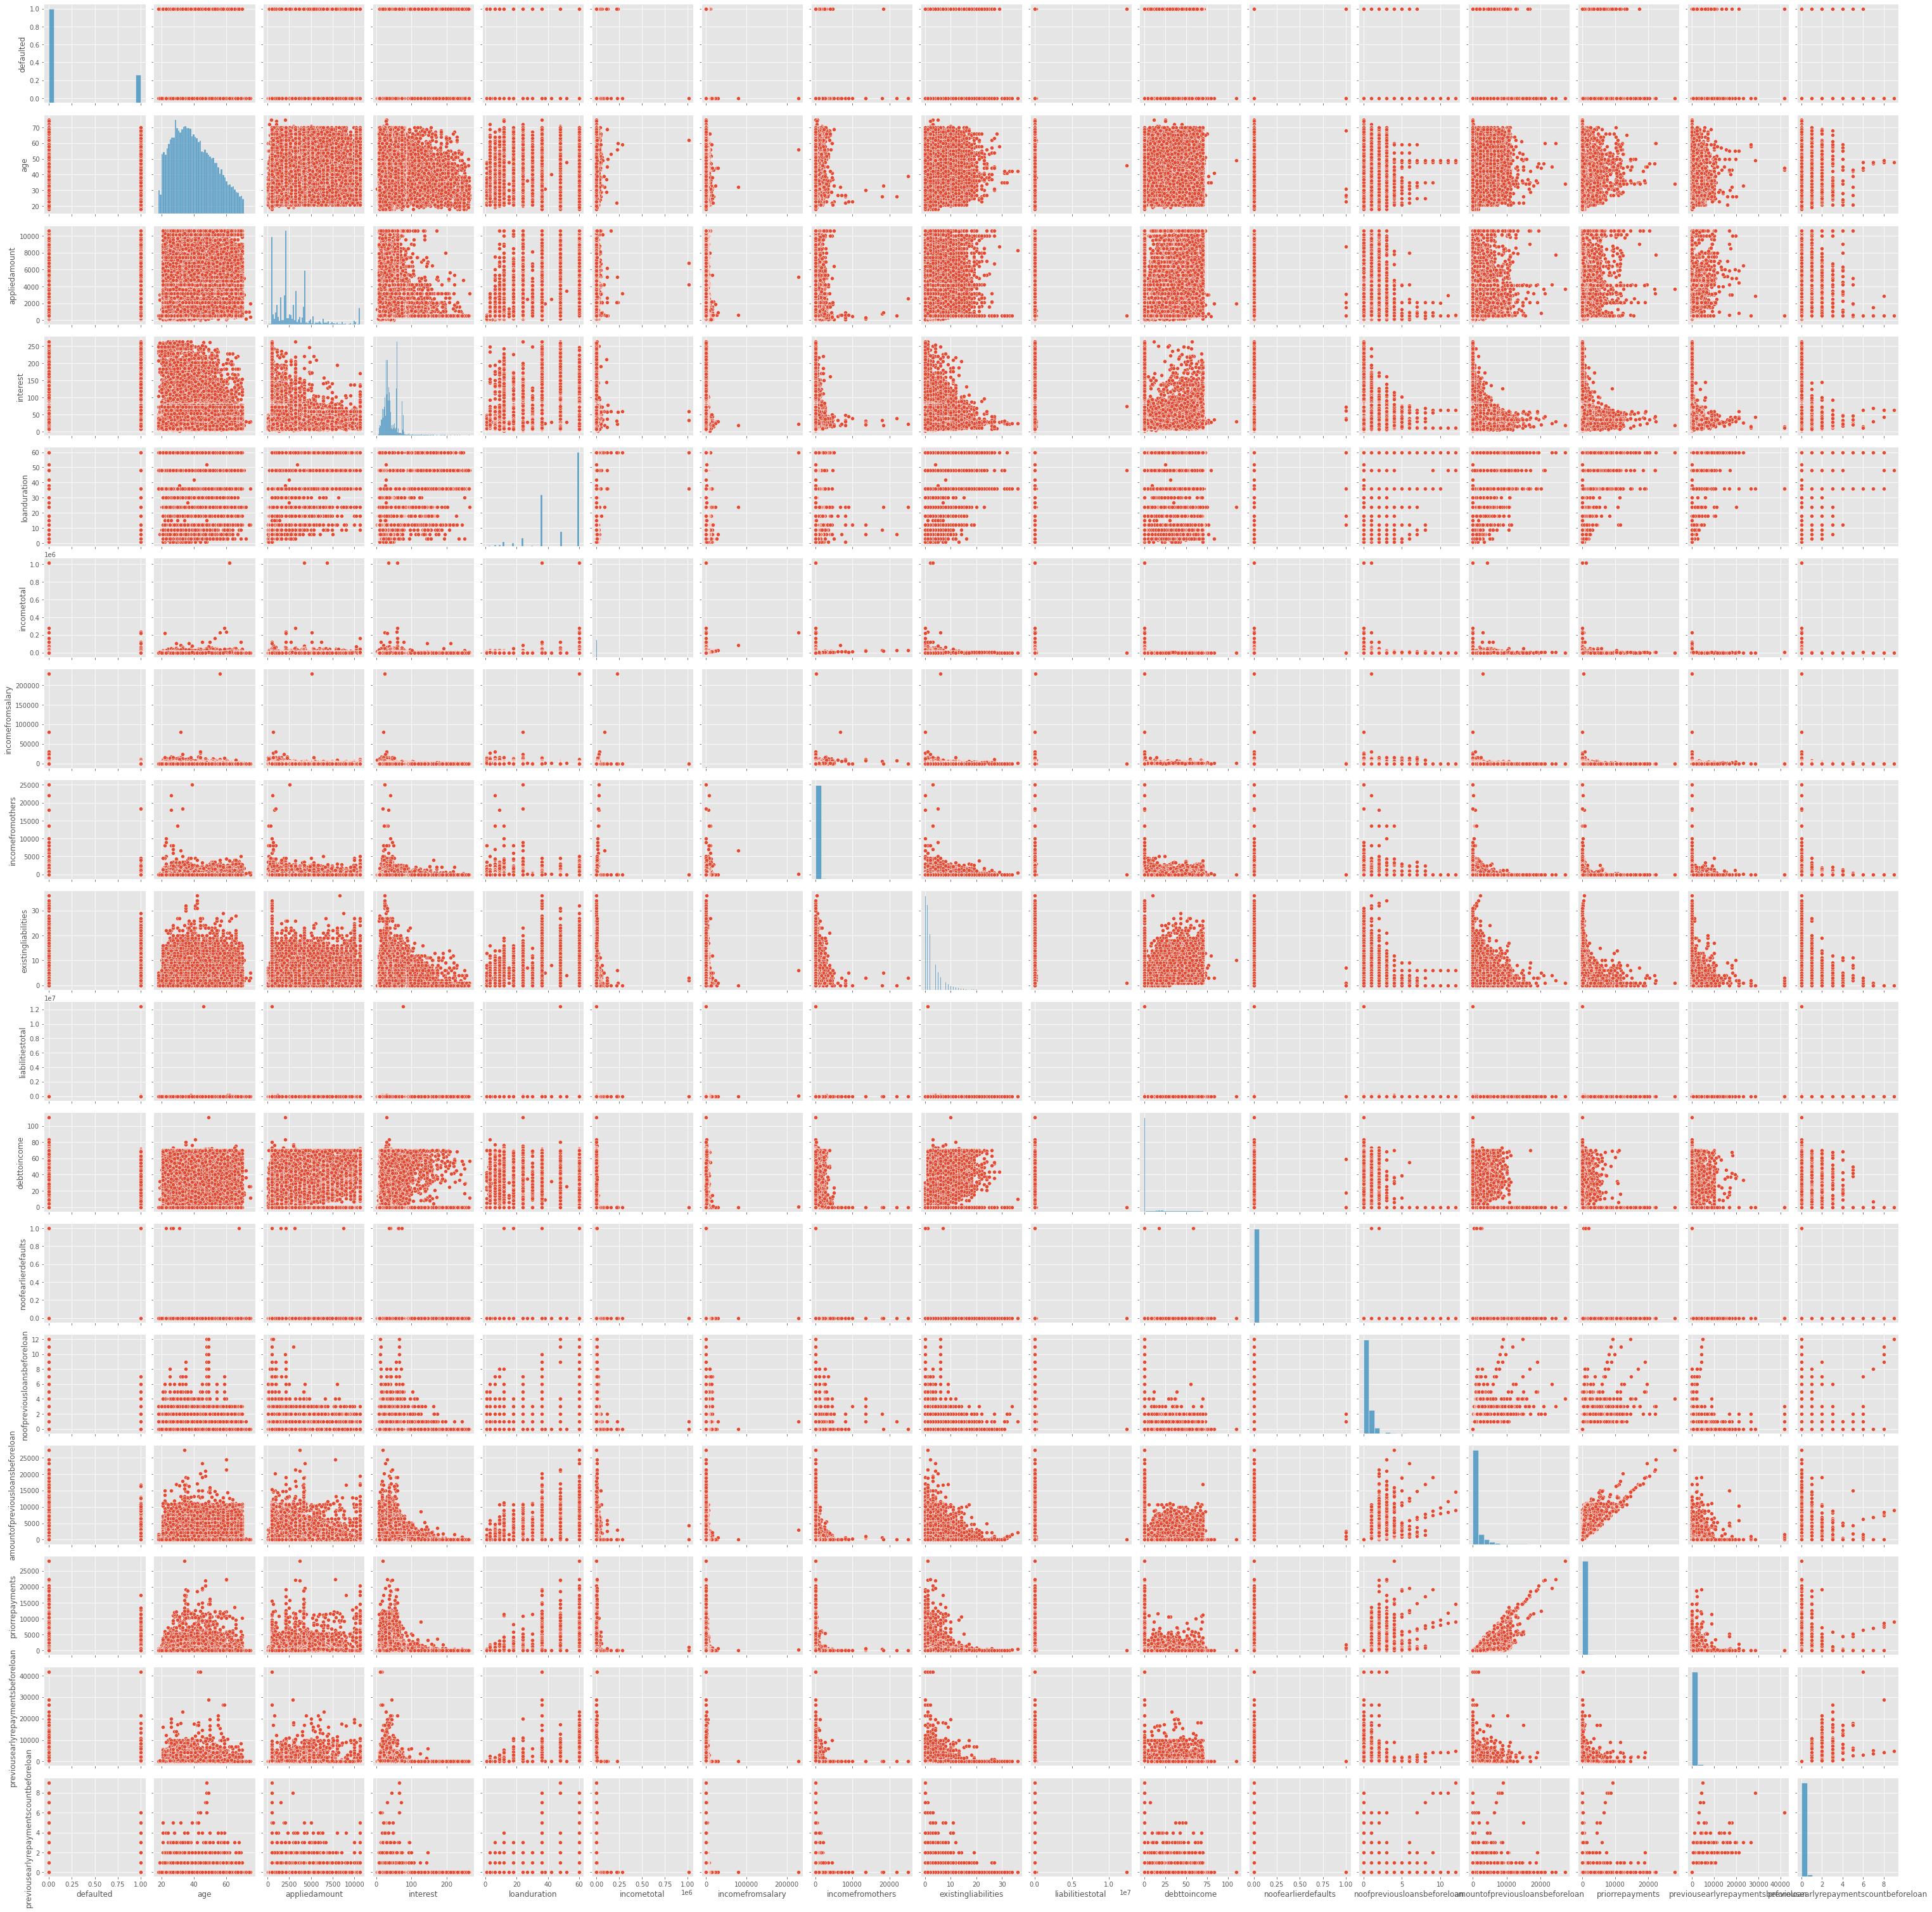

In [17]:
# pairplot visualisation
sns.pairplot(train)
# plt.savefig('fig4.jpeg')

In [18]:
# find pearson's correlation coefficient for each variable to target 'defaulted' variable
train.corr()['defaulted'].sort_values()

existingliabilities                      -0.099786
noofpreviousloansbeforeloan              -0.066894
debttoincome                             -0.052613
amountofpreviousloansbeforeloan          -0.051912
appliedamount                            -0.043398
priorrepayments                          -0.040415
incomefromsalary                         -0.036396
age                                      -0.025521
previousearlyrepaymentsbeforeloan        -0.025319
incomefromothers                         -0.023788
previousearlyrepaymentscountbeforeloan   -0.020704
incometotal                               0.002058
noofearlierdefaults                       0.003832
liabilitiestotal                          0.007216
loanduration                              0.029592
interest                                  0.315382
defaulted                                 1.000000
Name: defaulted, dtype: float64

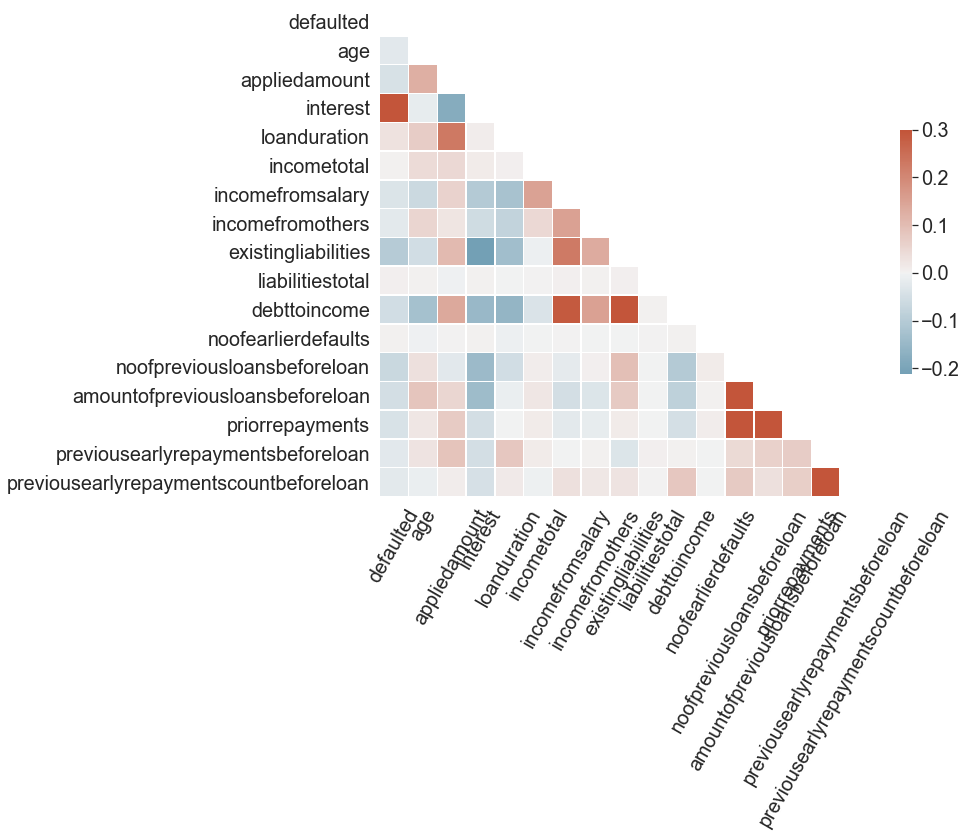

In [19]:
# plot correlation visualisation
# sns.set_theme(style="white")
sns.set(font_scale=1.8, style='white')

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=60)
# plt.savefig('fig5.jpeg')

plt.show()

In [20]:
# check the test data set
test.describe()

defaulted           age  appliedamount      interest  loanduration  \
count  14394.000000  14394.000000   14394.000000  14394.000000  14394.000000   
mean       0.124774     40.138669    2737.902737     37.974539     48.433306   
std        0.330474     12.728575    1780.845113     18.917180     13.813877   
min        0.000000     18.000000     518.000000      7.290000      3.000000   
25%        0.000000     30.000000    1037.000000     24.570000     36.000000   
50%        0.000000     39.000000    2764.000000     36.840000     60.000000   
75%        0.000000     50.000000    4150.000000     42.610000     60.000000   
max        1.000000     70.000000   10632.000000     79.510000     60.000000   

         incometotal  incomefromsalary  incomefromothers  existingliabilities  \
count   14394.000000           14394.0           14394.0         14394.000000   
mean     1686.265801               0.0               0.0             1.368001   
std      2711.837966               0.0               0.0             1.514141   
min         0.330000               0.0               0.0             0.000000   
25%      1000.000000               0.0               0.0             0.000000   
50%      1300.000000               0.0               0.0             1.000000   
75%      1950.000000               0.0               0.0             2.000000   
max    160041.000000               0.0               0.0            18.000000   

       liabilitiestotal  debttoincome  noofearlierdefaults  \
count      14394.000000       14394.0         14394.000000   
mean         305.694745           0.0             0.000278   
std         3678.858308           0.0             0.016668   
min            0.000000           0.0             0.000000   
25%            0.000000           0.0             0.000000   
50%          115.840000           0.0             0.000000   
75%          340.595000           0.0             0.000000   
max       250151.290000           0.0             1.000000   

       noofpreviousloansbeforeloan  amountofpreviousloansbeforeloan  \
count                 14394.000000                     14394.000000   
mean                      0.622343                      1743.711408   
std                       0.820051                      2729.682323   
min                       0.000000                         0.000000   
25%                       0.000000                         0.000000   
50%                       0.000000                         0.000000   
75%                       1.000000                      2802.000000   
max                       8.000000                     29435.000000   

       priorrepayments  previousearlyrepaymentsbeforeloan  \
count     14394.000000                         154.000000   
mean        352.891428                        3741.435065   
std        1063.946618                        3577.393026   
min           0.000000                         287.000000   
25%           0.000000                        1060.500000   
50%           0.000000                        3149.000000   
75%         302.602500                        4253.000000   
max       21082.160000                       21260.000000   

       previousearlyrepaymentscountbeforeloan  
count                            14394.000000  
mean                                 0.016743  
std                                  0.171426  
min                                  0.000000  
25%                                  0.000000  
50%                                  0.000000  
75%                                  0.000000  
max                                  5.000000

In [21]:
# check amount of missing values in test dataset
test.isna().sum()

defaulted                                     0
loanid                                        0
username                                      0
loanapplicationstarteddate                    0
languagecode                                  0
age                                           0
gender                                        0
country                                       0
appliedamount                                 0
interest                                      0
loanduration                                  0
education                                     0
maritalstatus                                 0
nrofdependants                            14394
employmentstatus                              0
employmentdurationcurrentemployer             0
workexperience                            14394
occupationarea                                0
homeownershiptype                             0
incometotal                                   0
incomefromsalary                        

We have split the dataset into at 80:20 ratio. However, here see a number of issues already, i.e. the `nrofdependents`and `workexperience` variables in the test set are completely empty, while they are largely empty in the train dataset. We also see a number of features which have a value of -1, which is not a represented value according to the data dictionary.

Lets carry out an EDA on the train dataset to develop a procedure to deal with this issues. The procedure developed should and would be subsequently applied to the test dataset as part of the data pipeline and modelling for evaluation. Such a process would mimic real life operation

In [22]:
# save train and test dataset
train.to_csv("../../Data/Processed/POATrain.csv", index=False)
test.to_csv("../../Data/Processed/POATest.csv", index=False)

# Load Functions

In [23]:
# shaprio wilk's test for age
def shapirotest(var:str, df=train):
    '''
    Shapiro test function to test for normality. As a default, takes in the dataframe train and a user input
    name of a variable belonging to the dataframe and returns the result of the test on that variable.
    '''
    
    stat, p = shapiro(df[var])
    print('Statistics = %.3f, p = %.3f' % (stat, p))
    
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
        
# number of outliers outside q1/q3 +/- IQR
def no_of_iqr_outliers(var, df=train):
    '''
    A simple utility function to calculate the number of outliers defined as existing outside the Q1-Q3 +/- 1.5 * IQR range.
    As a default, it takes in the pandas dataframe train and a user input name of a variable belonging to the dataframe.
    
    '''
    
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1

    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    nr = len(df.loc[(df[var] > Upper_Whisker)| (df[var] < Lower_Whisker)])
    
    print(f"Q1: {Q1}\nQ3: {Q3}\nIQR :{round(IQR, 3)}\nNumber of Outliers: {nr}")
    
    
# let define a chi-square-test
def chi_square(table, prob = 0.95):
    '''
    A utility function that performs a chi-square correlation test on a contingency table.
    '''
    
    stat, p, dof, expected = chi2_contingency(table)

    # interpret test-statistic
    critical = chi2.ppf(prob, dof)
    
    print('probability = %.3f, critical = %.3f, stat = %.3f' % (prob, critical, stat))
    
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    # interpret p-value
    alpha = 1.0 - prob
    print('significance = %.3f, p = %.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
        
# lets further define a cramers_v function which quantifies the correlation between 2 cat:

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    v =  np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    print(v)
    return v


In [24]:
# qq plot
def qq_plot(var, ax=None, df=train):
    '''
    Function which plots the QQ plot of a variable (var) belonging to a pandas dataframe (df, default = train)
    '''

    plt.style.use('ggplot')

    qqplot(df[var], line='s', ax=ax)
    
    plt.title('QQ Plot - ' + str(var).capitalize())

    plt.show()    


    
# numerical distribution plots
def numerical_plot(var, discrete=False, sparse=False, box_by=None, bins=100, dist_yscale='linear', df=train):
    '''
    Function which plots various plots of a numerical variable (var) belonging to a pandas dataframe (df, default = train),
    such as the barplot or histogram, qq plot and box plot.
    
    discrete:   False - whether the numerical variable is a discrete numerical or a continuos 
    sparse:     False - whether the numerical variable has a huge proportion of zeros
    box_by:     None - group by variable for the box plot
    bins:       100 - default number of bins
    dist_yscale:'linear' - whether the barplot/histogram yscale should be linear or others.
    
    '''
    
    # set up plot area
    plt.style.use('ggplot')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), gridspec_kw={'width_ratios': [3, 1.5, 1.5]})

    # continuous bar or discrete hist
    if discrete:
    
        data = df[var].value_counts(dropna=False).sort_index()
        if sparse:
            ax1.bar(data.index, data)
        
        else:
            data.plot(kind='bar', ax=ax1, rot=0)
                
    else:
        
        data = df[var]
        ax1.hist(data, bins=bins)
    
    # quantile lines
    quantile_list = [0, .25, .5, .75, 1.]
    quantiles = df[var].quantile(quantile_list)
        
    for quantile in quantiles:
        ax1.axvline(quantile, color='grey', linestyle=':')
    
    
    # boxplot
    box = df.boxplot(var, by=box_by, ax=ax2, showmeans=True, meanline=True, patch_artist=False)
        
    # labels
    xlabel = str(data.name).capitalize()
    grouplabel = str(box_by).capitalize()
    grouptitle = ' Grouped by '+ grouplabel
    
    # skewness
    ax1.text(0.9,0.9, s=f'Skew = {round(df[var].skew(),2)}', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes)
    ax1.set_title(xlabel +' Distribution')
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel("Counts")
    ax1.set_yscale(dist_yscale)
    
    box.get_figure().suptitle('')
    ax2.set_title(xlabel + grouptitle)
    ax2.set_xlabel(grouplabel)
    ax2.set_yscale(dist_yscale)

    # qq_plot
    qq_plot(var, ax=ax3, df=df)
    
#     plt.savefig('fig_'+xlabel +'_Distribution.jpeg')
    
    plt.show()

    
# cat plot
def cat_plot(var, grp_by='defaulted', df=train):
    '''
    Function which plots bar plots of a categorical variable (var) belonging to a pandas dataframe (df, default = train),
    and calculate the cramer's v and chhi-square coefficient with the 'defaulted' target variable. 
    
    grp_by:   'defaulted' - group by variable for the plot
    
    '''    
    # use style
    plt.style.use('ggplot')
    df = df.copy()
    
    # make crosstab table to calculate cramer's v and chi_square
    table = pd.crosstab(df[var], df["defaulted"]).to_numpy()
    cramers_v(table)
    chi_square(table)
    
    # fillna with 'NaN' as otherwise the missing values will not be plotted.
    data = pd.crosstab(df[grp_by].fillna('NaN'), df[var].fillna('NaN'), dropna=False)
    
    xlabels = data.columns
    x = np.arange(len(xlabels))  # the label locations
    width = 0.35  # the width of the bars
    
    # set up canvas
    fig, ax = plt.subplots(figsize=(10,5))
    
    # barplots
    rects1 = ax.bar(x - width/2, data.values[0], width, label=data.index[0])
    rects2 = ax.bar(x + width/2, data.values[1], width, label=data.index[1])  
     
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Counts')
    ax.set_title(str(var).capitalize() + ' Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel(str(var).capitalize())
    ax.legend(title=str(grp_by))
    
    # bar labelling function
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()


def grouped_boxplot(x, y, hue='defaulted', data=train, yscale='linear'):
    '''
    Plot grouped box plots for variables y against x, grouped by 'defaulted' for pandas dataframe df (default = train)
    
    hue:    'defaulted' - the variable to group by
    yscale: 'linear' - y-axis scale, whether linear or otherwise
    
    '''
    
    # make a view of train dataset
    data = train.copy()
    # fillna with -1 values, since NaN and -1 values are undefined
    data[x] = data[x].fillna('NaN')
    
    
    plt.style.use('ggplot')
    sns.set(rc={'figure.figsize':(15,8)})

    # plot boxplot of incometotal vs homeownershiptype and defaulted state
    ax = sns.boxplot(x=x, y=y, hue=hue, data=data, palette="Set1")

    ax.set_yscale(yscale)

    plt.show()
    

def kde_target(var_name, df):
    '''
    Function plots the kernel density estimate (KDE) plots for a variable given according to the respective 'defaulted' status.
    
    It also prints out the pearson's correlation value for the variable and the target 'defaulted' variable.
    
    '''
    
    plt.style.use('ggplot')
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['defaulted'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_non_default = df.loc[df['defaulted'] == 0, var_name].median()
    avg_defaulted = df.loc[df['defaulted'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['defaulted'] == 1, var_name], label = 'defaulted == 1')
    sns.kdeplot(df.loc[df['defaulted'] == 0, var_name], label = 'defaulted == 0')
    
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that is non-default = %0.4f' % avg_non_default)
    print('Median value for loan that defaulted =     %0.4f' % avg_defaulted)

In [25]:
# define a function that gets the latest non-nan value for a var from a database and fillna of the data dataframe
def fill_with_earlier(data, database, data_var:str, 
                      database_var:str, 
                      fill_val:list=None,
                      data_group_key:str='username', 
                      database_group_key:str='UserName',
                      lowercase=False):
    '''
    A function that gets the latest non-nan var value from a database and fills in the nan values of the var of the data dataframe.
    
    '''
    
    data = data.copy()
    database = database.copy()
    
    data_merge_col = 'loanid'
    database_merge_col = 'LoanId'
    database_date_col = 'LoanApplicationStartedDate'
    
    if lowercase:
        database_var = database_var.lower()
        database.columns = database.columns.str.lower()
        database_merge_col = database_merge_col.lower()
        database_date_col = database_date_col.lower()
        database_group_key = database_group_key.lower()
        
    # get corresponding loans belonging to these usernames from db_df
    database_miss = database.loc[database[database_group_key].isin(set(data[data_group_key]))].copy()
    
    if fill_val != None:
        database_miss.loc[database_miss[database_var].isin(fill_val), database_var] = np.nan

    # sort these loans according to username and date
    database_miss = database_miss.sort_values([database_group_key, database_date_col])

    # implement a little trick here, we will use the fillna(method='ffill') method followed by pd.merge according to the loanid
    # to simulate the querying of database for ast records to impute, which is what we see in actual operation. 
    # For the test dataset, they will also have a view of the database

    # for each username group, find earlier non-nan values to impute nan values, i.e. fillna(method='ffill')
    database_miss[database_var] = database_miss.groupby(database_group_key)[database_var].fillna(method='ffill')

    # use pd.merge between data and db_df_miss on the loanid to simulate the querying
    data = pd.merge(data, database_miss[[database_merge_col, database_var]], how='left', left_on=data_merge_col, right_on=database_merge_col)
   
    # assign the queried values to the loans with missing homeownershiptype values
    if lowercase:
        data[data_var+'_x'] = data[database_var+'_y'].copy()
        data.drop(columns=[database_var+'_y'], inplace=True)
        data.rename(columns={data_var+'_x':data_var}, inplace=True)
    else:
        data[data_var] = data[database_var].copy()
        data.drop(columns=[database_merge_col, database_var], inplace=True)
    
    return data

# EDA

## Pandas Profiling

Lets carry out a quick and dirty EDA on the train set with pandas profiling

In [26]:
# create report instance, with explorative option set True
report = ProfileReport(df=train, title='POA Train Set', explorative=True)

In [27]:
# export to html
report.to_file("../../Docs/DataReport/POATrainEDA.html")

__Refer to [POATrainEDA](../../Docs/DataReport/POATrainEDA.html) for the EDA results__

## Variable Types

From the above EDA, we are able to categorise our features as either categorical or numerical

In [33]:
train.columns
# len(train.columns)

Index(['defaulted', 'loanid', 'username', 'loanapplicationstarteddate',
       'languagecode', 'age', 'gender', 'country', 'appliedamount', 'interest',
       'loanduration', 'education', 'maritalstatus', 'nrofdependants',
       'employmentstatus', 'employmentdurationcurrentemployer',
       'workexperience', 'occupationarea', 'homeownershiptype', 'incometotal',
       'incomefromsalary', 'incomefromothers', 'existingliabilities',
       'liabilitiestotal', 'debttoincome', 'noofearlierdefaults',
       'noofpreviousloansbeforeloan', 'amountofpreviousloansbeforeloan',
       'priorrepayments', 'previousearlyrepaymentsbeforeloan',
       'previousearlyrepaymentscountbeforeloan'],
      dtype='object')

In [42]:
# exclude 'loanid', 'username', 'loanapplicationstarteddate'
# categorical variable
cat_var = ['homeownershiptype', 'languagecode', 'maritalstatus', 'nrofdependants', 'education', 'employmentdurationcurrentemployer',
           'employmentstatus', 'occupationarea', 'workexperience', 'country', 'gender' ]
# numerical variables
num_var = ['age', 'appliedamount', 'interest', 'loanduration', 'incometotal','incomefromsalary', 'incomefromothers',
           'noofpreviousloansbeforeloan','amountofpreviousloansbeforeloan', 'priorrepayments','noofearlierdefaults', 'defaulted',
           'existingliabilities', 'liabilitiestotal', 'previousearlyrepaymentsbeforeloan', 'previousearlyrepaymentscountbeforeloan']

Lets convert the cat_var to object data types and num_var as float

In [43]:
train[cat_var] = train[cat_var].astype(object)
train[num_var] = train[num_var].astype(float)

## Data Issues

Here we see some issues highlighted that are worth us having a deeper look:

|  |  |  |  |
|-|-|-|-|
| 1. `age`<br><br>    1. Interesting histogram plot, there seems to be multiple peaks.<br>    2. No missing values | 2. `homeownershiptype`<br><br>    1. 0.2% Missing values<br>    2. 2 instances of -1 values which is undefined in the data dictionary<br>    3. Should be categorical variable | 3. `languagecode`<br><br>    1. Instances of values (7, 10, 13, 15, 21, 22) which are undefined in the data dictionary<br>    2. Should be categorical variable | 4. `maritalstatus`<br><br>    1. High amount of undefined value (-1) - 66.8%<br>    2. Shows high correlation with `employmentstatus`<br>    3. Should be categorical variable |
| 5. `nrofdependants`<br><br>    1. 67.8% missing values<br>    2. Categorical variable with large number of categories, some of which have very little instances | 6. `education`<br><br>    1. Instances of values (-1) which are undefined in the data dictionary<br>    2. Should be categorical variable | 7. `employmentdurationcurrentemployer`<br><br>    1. 0.5% missing values<br>    2. Complicated categorical variable values | 8. `employmentstatus`<br><br>    1. High amount of undefined value (-1, 0) - 66.8%<br>    2. Shows high correlation with `maritalstatus`<br>    3. 0.1% mising values<br>    4. Should be categorical variable |
| 9. `ocupationarea`<br><br>    1. High amount of undefined value (-1) - 66.9%<br>    2. Should be categorical variable | 10. `workexperience`<br><br>    1. 66.9% missing values<br>    2. Complicated categorical variable values | 11. `interest`<br><br>    1. Interesting histogram plot, there seems to be multiple peaks. | 12. `appliedamount`<br><br>    1. Interesting histogram plot, there seems to be multiple peaks |
| 13. `incometotal`<br><br>    1. Highly skewed data - 117 skewness | 14. `incomefromsalary`<br><br>    1. 68.6% zeros<br>    2. Highly skewed data - 89 skewness | 15. `incomefromothers` <br>    <br>    1. 88.5% zeros<br>    2. Highly skewed data - 27 skewness | 16. `country`<br><br>    1. High correlation with `languagecode` |
| 17. `noofpreviousloansbeforeloan`<br><br>    1. 75.6% zeros | 18. `amountofpreviousloansbeforeloan`<br><br>    1. 75.6% zeros<br>  | 19. `priorrepayments ` <br>    <br>    1. 76.0% zeros<br>     | 20. `previousearlyrepaymentscountbeforeloan ` <br>    <br>    1. 97.2% zeros <br>    |


Lets explore these features and issues to decide on how to deal with them.

### Age (Num)

Lets first look at the distribution of the `age` variable which does not have any missing values, but had a curious histogram plot in the earlier EDA.

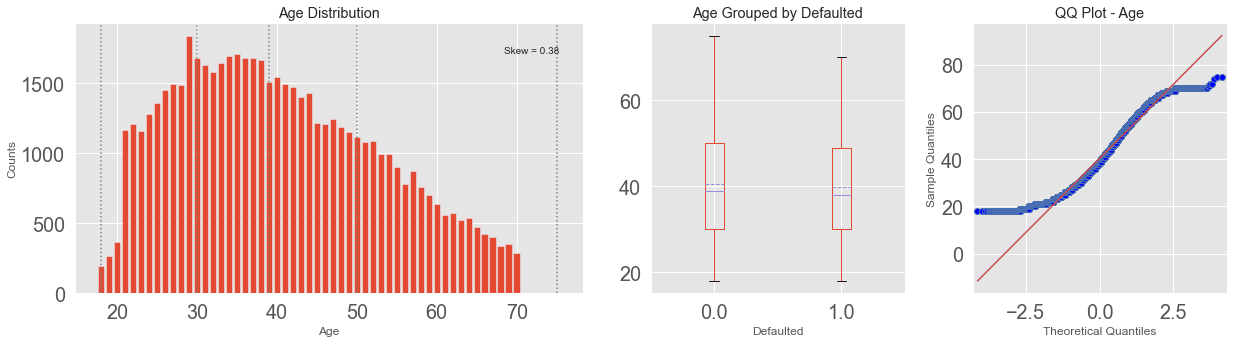

<Figure size 432x288 with 0 Axes>

In [44]:
# plot distribution
numerical_plot('age', True, sparse=True, box_by='defaulted')

Here we see that the distribution of applicants `age` does not seem to have an issue, as opposed to what we see in the pandas profiling. The median value of `age` is slightly below 40 at 39, while the mean is slightly over 40. There does not seem to be any outliers.

We see from the distribution qqplot that age distribution deviates from normal distribution. The same conclusion is supported by the Shapiro-wilk's test. 

In [45]:
shapirotest('age')

Statistics = 0.969, p = 0.000
Sample does not look Gaussian (reject H0)


C:\Users\marti\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Overall, there are no further issues with the `age` feature that require treatment.

The correlation between age and the TARGET is -0.0255
Median value for loan that is non-default = 39.0000
Median value for loan that defaulted =     38.0000


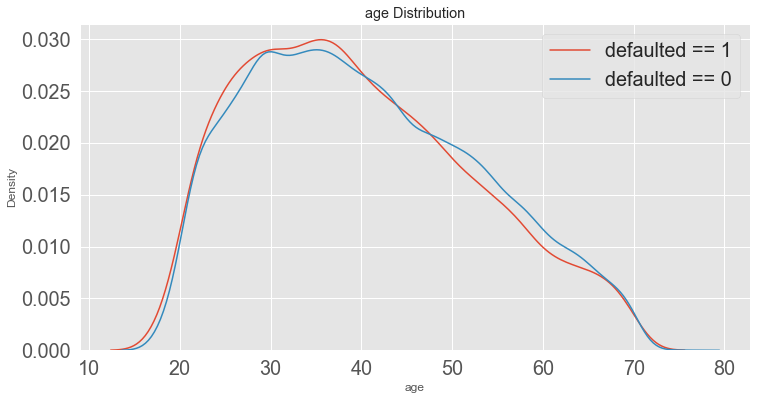

In [46]:
kde_target('age', train)

We see that there isn't much of a correlation with the target variable. Lets try to bin the ages into groups and find the average loan default for each age group.

In [47]:
def min_max_bin_default_plot(var, bin_num=10):
    '''
    Bin variable into bin_num of bins, with the smallest and largest limits as the min and max values of the variable
    and plot the bar plot.
    '''

    plt.style.use('ggplot')
    
    # Bin the var
    x = train.copy()

    x[str(var)+'_binned'] = pd.cut(x[var], bins = np.linspace(x[var].min(), x[var].max(), num = bin_num + 1))
    x_grp  = x.groupby(str(var)+'_binned').mean()

    plt.figure(figsize = (8, 5))

    # Graph the age bins and the average of the target as a bar plot
    plt.bar(x_grp.index.astype(str), 100 * x_grp['defaulted'])

    # Plot labeling
    plt.xticks(rotation = 75); plt.xlabel(str(var) + ' Group'); plt.ylabel('Defaulted (%)')
    plt.title('% Defaulted with '+ str(var) + ' bins')

    plt.show()

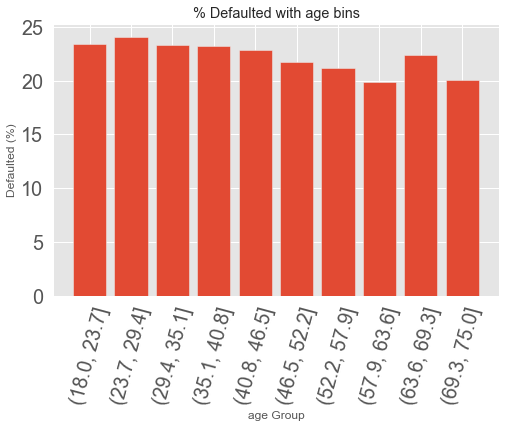

In [48]:
min_max_bin_default_plot('age')

We see that there is some semblance of a trend with the `default` variable. Lets do an adpative quantile binning

In [49]:
def quantile_bin_default_plot(var, quantile_list = [0, .25, .5, .75, 1.]):
    '''
    Quantile based binning, i.e. each bin has varible width to ensure that each bin contains roughly the same amount of samples
    '''
    
    plt.style.use('ggplot')
    x = train.copy()
    ql = quantile_list
    # create quantile labels
    quantile_labels = [str(round(ql[i]*100))+ '-' +str(round(ql[i+1]*100)) + 'Q' for i in range(len(ql)-1)]

    x[str(var) + '_quantile'] = pd.qcut(x[var], q=quantile_list, labels=quantile_labels)

    
    data = x.groupby(str(var) + '_quantile')['defaulted'].mean().sort_index()

    xlabel = str(data.index.name)

    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 5))

    data.plot(kind='bar', rot=0)

    ax.set_title('% Defaulted with '+ xlabel +' bins')
    ax.set_xlabel(xlabel)
    ax.set_ylabel("% defaulted")
    plt.show()

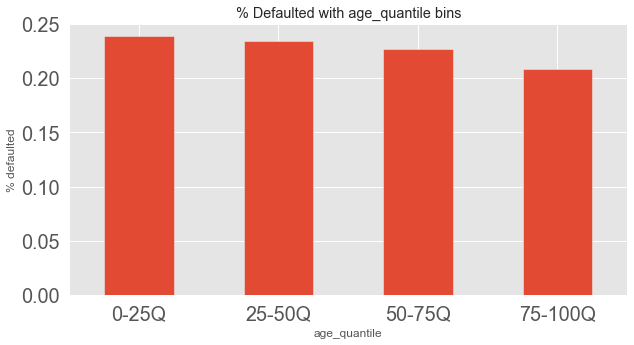

In [50]:
quantile_bin_default_plot('age')

We see that young loan applicants tend to default at a greater rate than older applicants

### Interest (Num)

From pandas-profiling, we see that there were multiple peaks in the interest rate distribution. Lets explore this

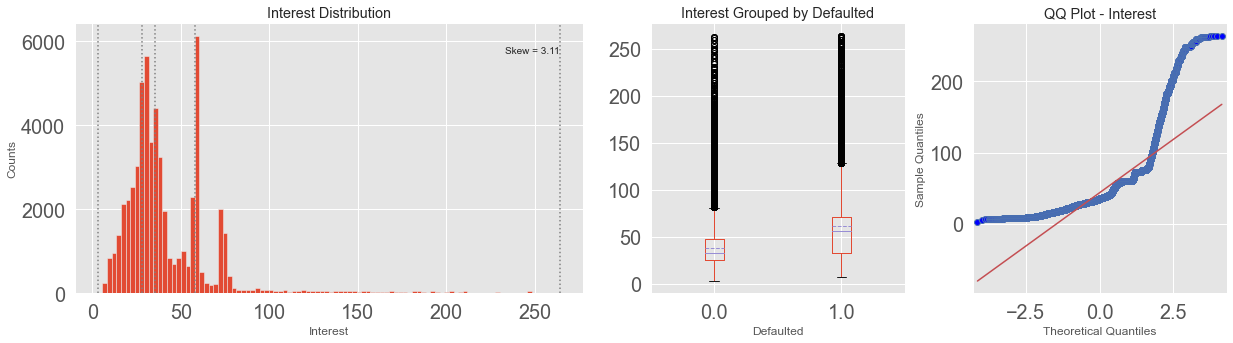

<Figure size 432x288 with 0 Axes>

In [51]:
# numerical plots
numerical_plot('interest', False, box_by='defaulted')

In [52]:
# number of outliers
no_of_iqr_outliers('interest')

Q1: 28.0
Q3: 57.76
IQR :29.76
Number of Outliers: 2053


We see that there are 3 peaks, one close to the median, another around 60% interest and the last about 75% interest. A large proportion of the `interest` rate distribution lies between the values of 0 to slightly over 100 %.

We see that there is a large proportion of interest values lying outside 1.5IQR from the 1st and 3rd quantiles and is a highly right skewed data.

We take the log of the interest values and the resulting distribution now seems more regular, with a lower skew value.

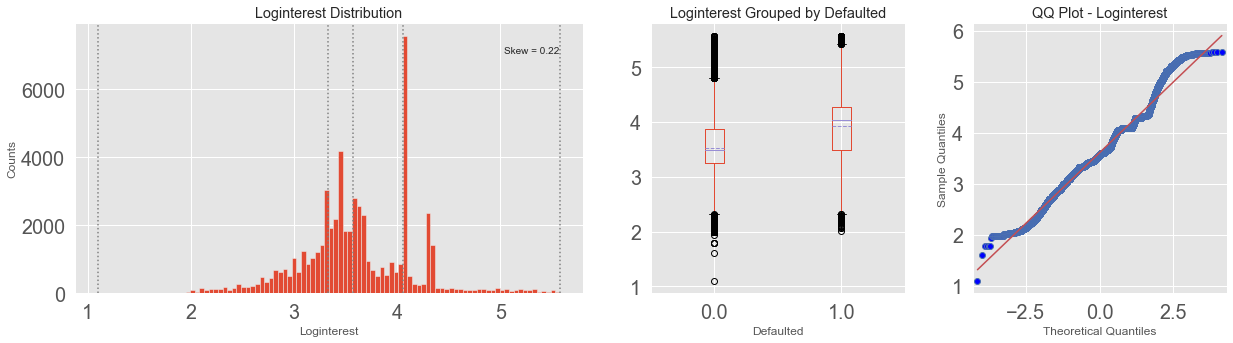

<Figure size 432x288 with 0 Axes>

In [53]:
# log interest 
x = train.copy()
x['loginterest'] = np.log(x['interest'])
# check distribution
numerical_plot('loginterest', box_by='defaulted', df=x)

In [54]:
# number of outliers
no_of_iqr_outliers('loginterest', df=x)

Q1: 3.332204510175204
Q3: 4.05629649458457
IQR :0.724
Number of Outliers: 1397


One of the major difficulty in credit/loan datasets is the issue of outlier detection. It is rather difficult to identify if some values are outliers or just extreme values. We see that despite our log transformation, there are still a number of outliers from the boxplots.

The correlation between interest and the TARGET is 0.3154
Median value for loan that is non-default = 32.8800
Median value for loan that defaulted =     56.3950


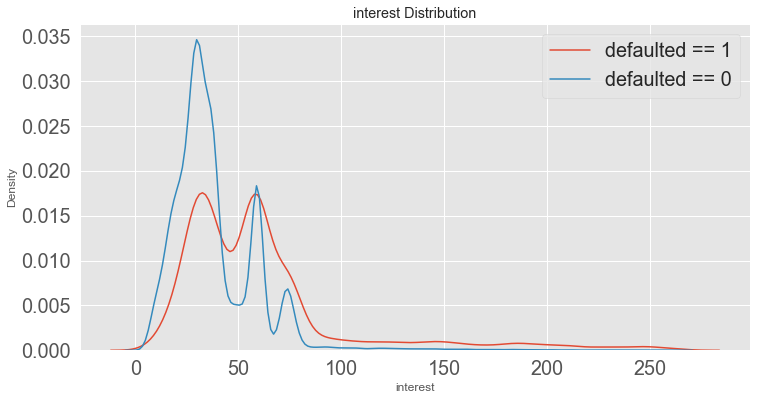

In [55]:
kde_target('interest', train)

The correlation between loginterest and the TARGET is 0.3118
Median value for loan that is non-default = 3.4929
Median value for loan that defaulted =     4.0324


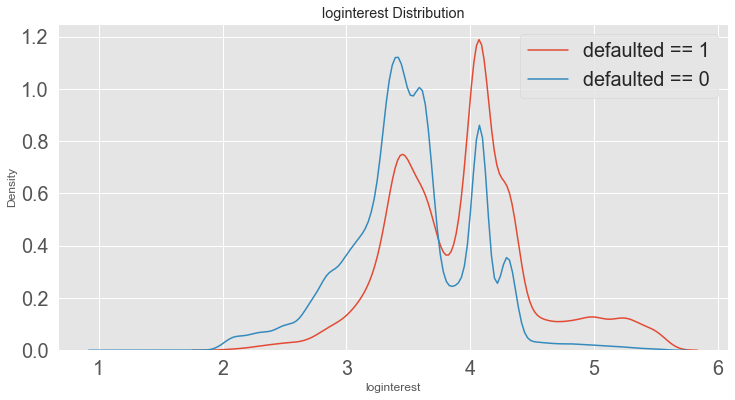

In [56]:
kde_target('loginterest', x)

Here we see that there is a strong correlation between interst and the default. With `loginterest`, the difference in the kde plot is accentuated. This will be something that we will want to do at the data processing stage.

We can also the amounts into specific categories to normalise the distribution and also identify the trends with `defaulted`.

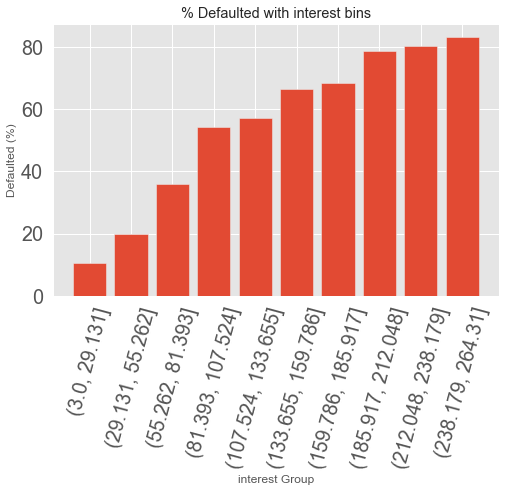

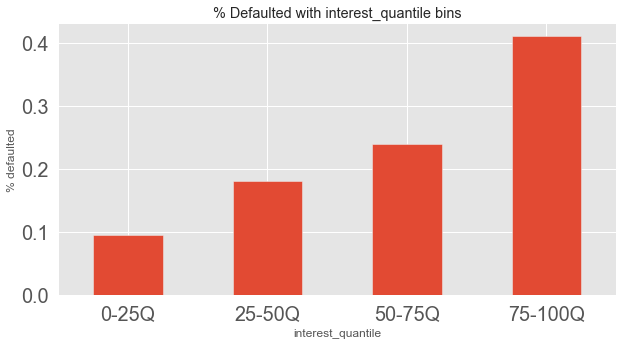

In [57]:
min_max_bin_default_plot('interest')
quantile_bin_default_plot('interest')

We see that with increasing interest, the default rates do indeed increase. We can try to bin the interest rate subsequently during feature engineering.

> __However, an important point to note is that the `interest` values are typically provided by the banks after it has assessed on the various risk of the loan applicants, i.e. it has already incorporated some form of loan risk assessment. As such, the variable `interest` should not be used for further modelling.__

### Appliedamount (Num)

From pandas-profiling, we see that the distribution of the `appliedamount` is not regular. Lets explore this

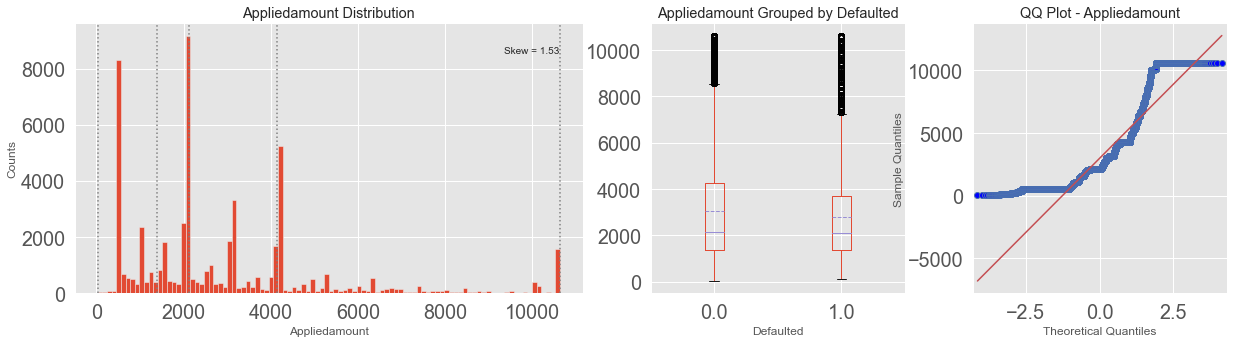

<Figure size 432x288 with 0 Axes>

In [58]:
# numerical_plot
numerical_plot('appliedamount', box_by='defaulted')

In [59]:
no_of_iqr_outliers('appliedamount')

Q1: 1380.0
Q3: 4150.0
IQR :2770.0
Number of Outliers: 3088


We see that there are peaks which correspond to the high occuring `appliedamount` values. There are also a large number of outliers

The correlation between appliedamount and the TARGET is -0.0434
Median value for loan that is non-default = 2126.0000
Median value for loan that defaulted =     2125.0000


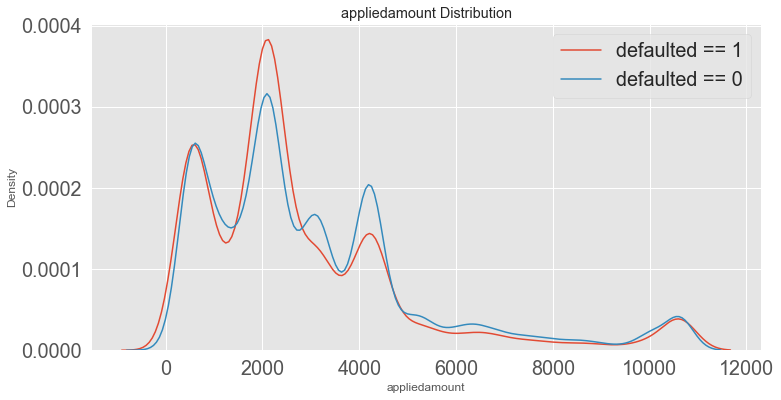

In [60]:
kde_target('appliedamount', train)

Here we see a pretty weak correlation 0.0434 bewteen the `appliedamount` and `defaulted`.

The correlation between logappliedamount and the TARGET is -0.0451
Median value for loan that is non-default = 7.6620
Median value for loan that defaulted =     7.6615


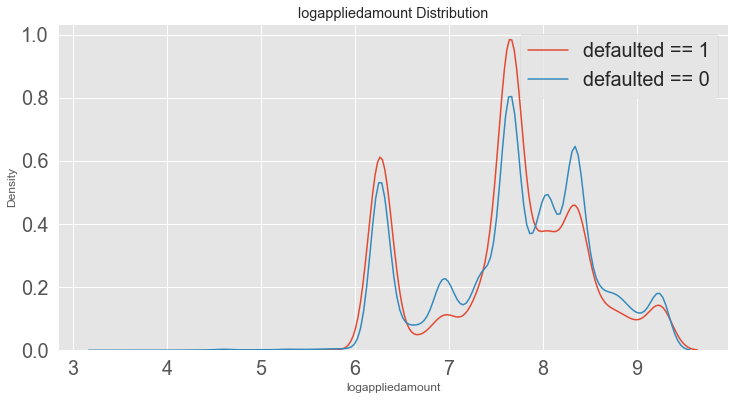

In [61]:
x = train.copy()
x['logappliedamount'] = np.log(x['appliedamount'])
kde_target('logappliedamount', x)

We see that even with a log transformation, the target variable distribution is not as distinct as with the interest variable. Nevertheless, we will maintain this variable and carry out a log transformation.

We can also bin the amounts, though the trend with `defaulted` is still not obvious.

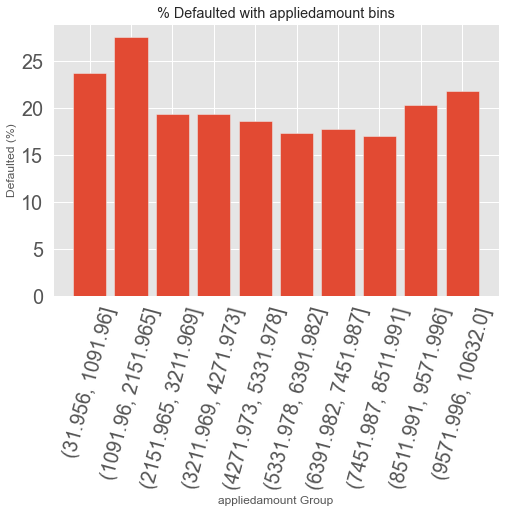

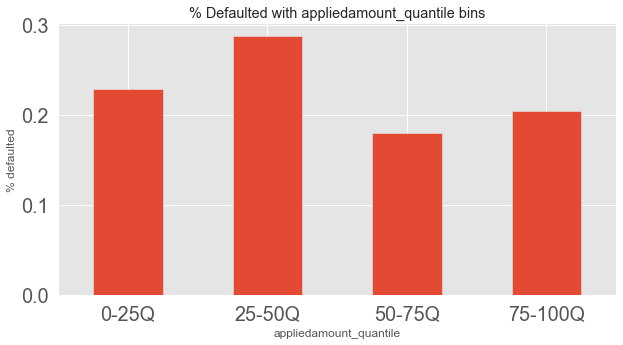

In [62]:
min_max_bin_default_plot('appliedamount', 10)
quantile_bin_default_plot('appliedamount')

### Incometotal, Incomefromsalary, Incomefromothers (Num)

We found that the income features were highly skewed, with `incomefromsalary`, `incomefromothers` having large amount of zeros.

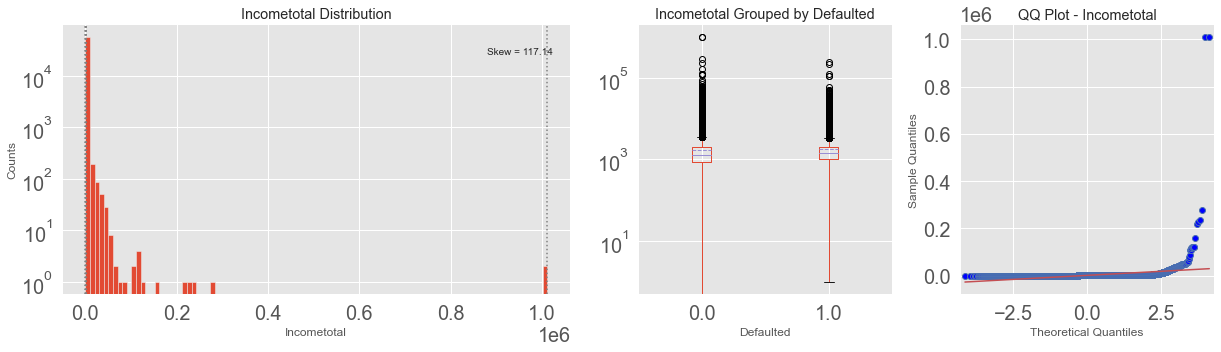

<Figure size 432x288 with 0 Axes>

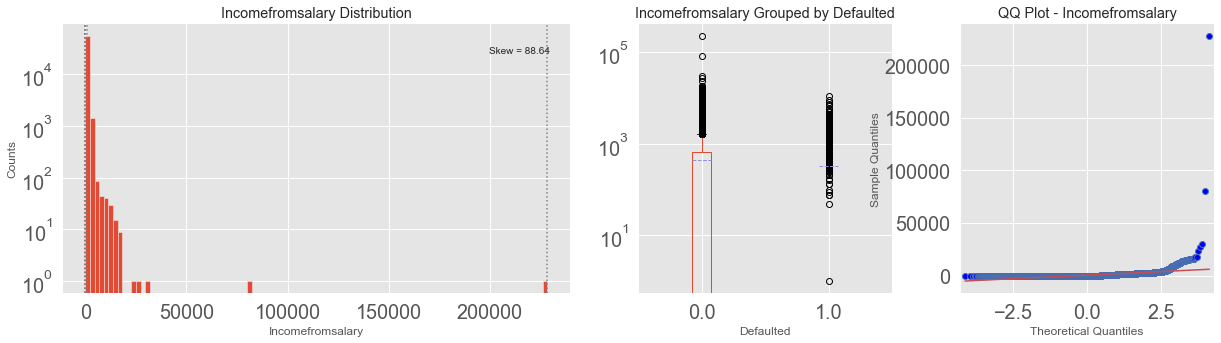

<Figure size 432x288 with 0 Axes>

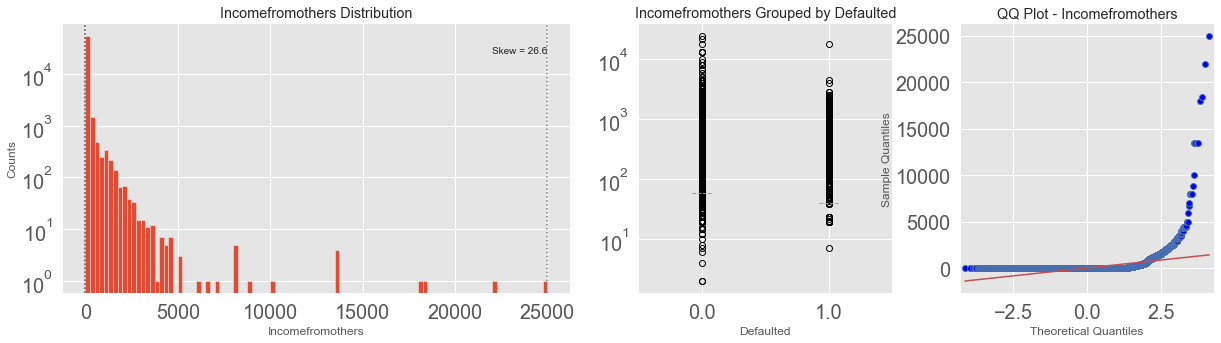

<Figure size 432x288 with 0 Axes>

In [63]:
# numerical plots
numerical_plot('incometotal', box_by='defaulted', dist_yscale='log')
numerical_plot('incomefromsalary', box_by='defaulted', dist_yscale='log')
numerical_plot('incomefromothers', box_by='defaulted', dist_yscale='log')

Here we see that the features are highly skewed and have a large amount of small values, leading to large amounts of outliers

In [64]:
no_of_iqr_outliers('incometotal')
no_of_iqr_outliers('incomefromsalary')
no_of_iqr_outliers('incomefromothers')

Q1: 900.0
Q3: 1962.0
IQR :1062.0
Number of Outliers: 1950
Q1: 0.0
Q3: 600.0
IQR :600.0
Number of Outliers: 5015
Q1: 0.0
Q3: 0.0
IQR :0.0
Number of Outliers: 6632


Lets also check if these values are related. Theoretically, `incometotal` == `incomefromsalary` + `incomefromothers`

In [65]:
(train['incometotal'] == train['incomefromothers']+train['incomefromsalary']).value_counts(dropna=False)

False    38489
True     19086
dtype: int64

We see that there are a number of applications where the above does not hold. Which is very curious. It is highly possible that the `incomefromsalary` and `incomefromothers` features may have been constructed from sub-features which have missing values or unspecified values.

> __Given that there are some doubts as to whether the `incomefromsalary` and `incomefromothers` features are properly constructed, and/or if there are missing values, we will drop these 2 features.__

The correlation between incometotal and the TARGET is 0.0021
Median value for loan that is non-default = 1300.0000
Median value for loan that defaulted =     1400.0000


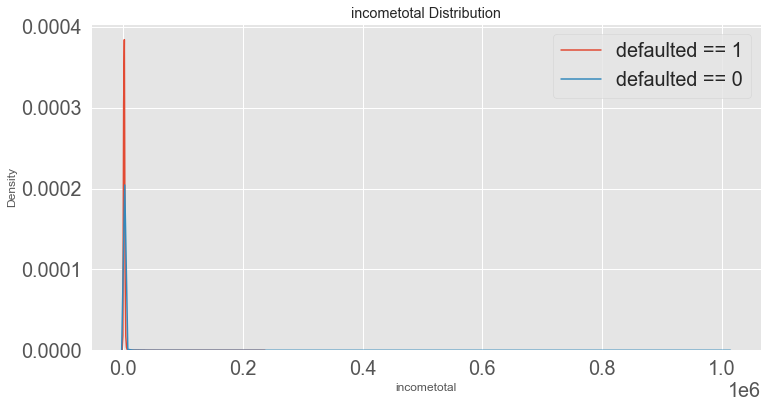

In [66]:
kde_target('incometotal', train)

We see a pretty weak correlation unexpectedly (0.0021). We also see that there are a few abnormalies, where the `incometotal` = 0, which is unlikely.

In [67]:
train.loc[train['incometotal'] == 0, ['username', 'incometotal','employmentstatus']]

username  incometotal employmentstatus
47   TAAWOKAS          0.0                3
481   slavauk          0.0                3

Lets explore these further.

In [68]:
train.loc[train['username'].isin(['TAAWOKAS', 'slavauk']), ['username','loanapplicationstarteddate','incometotal','incomefromsalary', 'incomefromothers','employmentstatus', 'occupationarea']]

username loanapplicationstarteddate  incometotal  incomefromsalary  \
2    TAAWOKAS        2010-03-11 20:48:00      15000.0           15000.0   
7    TAAWOKAS        2010-03-28 13:30:00      15000.0           15000.0   
14   TAAWOKAS        2010-04-20 20:49:00      15000.0           15000.0   
38   TAAWOKAS        2010-06-16 19:27:00      15000.0           15000.0   
47   TAAWOKAS        2010-07-12 21:37:00          0.0               0.0   
64   TAAWOKAS        2010-08-18 18:51:00      15000.0           15000.0   
74   TAAWOKAS        2010-09-12 19:05:00      14000.0           14000.0   
102  TAAWOKAS        2010-10-06 18:51:00      15500.0           15500.0   
481   slavauk        2012-04-03 13:52:00          0.0               0.0   

     incomefromothers employmentstatus occupationarea  
2                 0.0                3              1  
7                 0.0                3              3  
14                0.0                3              3  
38                0.0                3              1  
47                0.0                3              1  
64                0.0              NaN              1  
74                0.0                3              1  
102               0.0                3              3  
481               0.0                3              7

We see that in actual fact, TAAWOKAS's 0 `incometotal`, should not be zero. In order to generalise a method to handle this sort of situation, we will set a filter where any `incometotal` with zero will be imputed with the median value

In [69]:
# get the median
median = train.loc[(train['incometotal'] != 0), 'incometotal'].median()
train.loc[(train['incometotal'] == 0), 'incometotal'] = median

Lets take the log of incometotal to see if we can reduce the skewness.

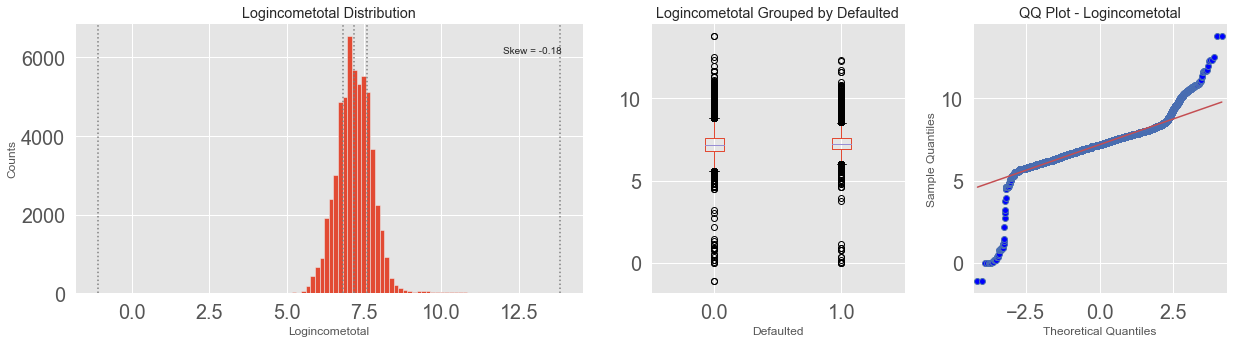

<Figure size 432x288 with 0 Axes>

In [70]:
# lets log incometotal
x = train.copy()

x['logincometotal'] = np.log(x['incometotal']) 
# check distribution
numerical_plot('logincometotal', box_by='defaulted', df=x)

In [71]:
no_of_iqr_outliers('logincometotal', df=x)

Q1: 6.802394763324311
Q3: 7.581719640125308
IQR :0.779
Number of Outliers: 779


In [72]:
shapirotest('logincometotal', df=x)

Statistics = 0.932, p = 0.000
Sample does not look Gaussian (reject H0)


C:\Users\marti\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The correlation between logincometotal and the TARGET is 0.0479
Median value for loan that is non-default = 7.1701
Median value for loan that defaulted =     7.2442


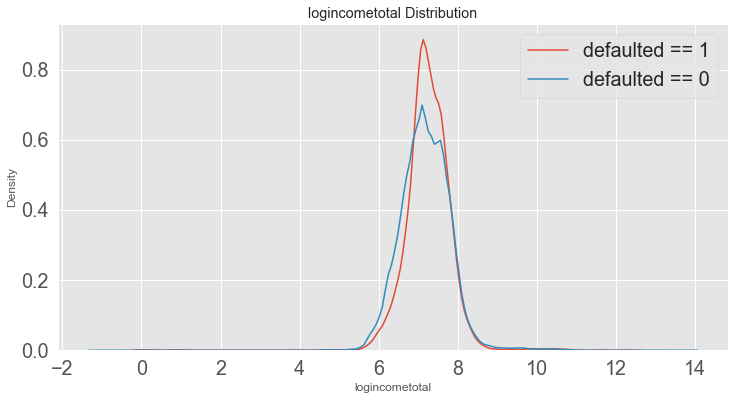

In [73]:
kde_target('logincometotal', x)

We see that log transformation of `incometotal` helps reduce the skewness and also reduces the number of interpreted outliers. Furthermore, the log transformation increases the correlation with `defaulted`.

Lets try the box-cox transformation

In [74]:
income = np.array(train['incometotal'])
l, opt_lambda = boxcox(income)
print('Optimal lambda value:', opt_lambda)

Optimal lambda value: 0.017766919404491936


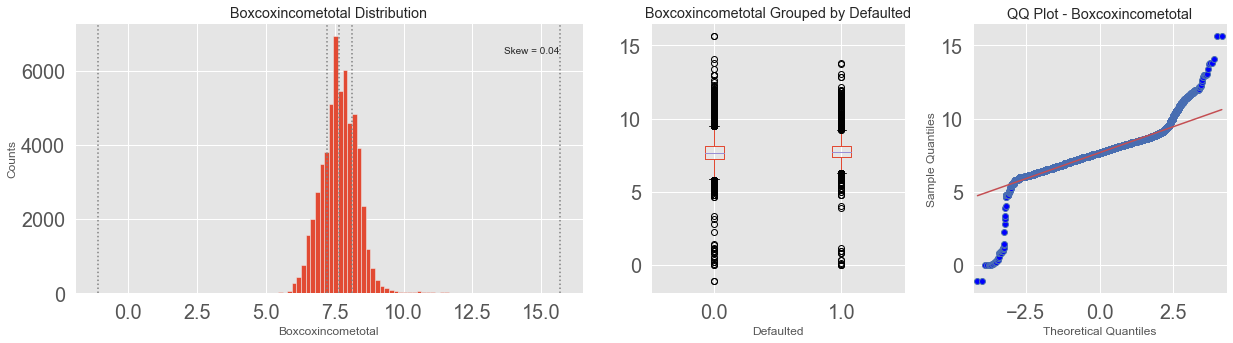

<Figure size 432x288 with 0 Axes>

In [75]:
# boxcox transform
x = train.copy()
x['boxcoxincometotal'] = boxcox(x['incometotal'], lmbda=opt_lambda)
# check distribution
numerical_plot('boxcoxincometotal', box_by='defaulted', df=x)

In [76]:
no_of_iqr_outliers('boxcoxincometotal', df=x)
shapirotest('boxcoxincometotal', df=x)

Q1: 7.230527935266761
Q3: 8.116084816268723
IQR :0.886
Number of Outliers: 783
Statistics = 0.934, p = 0.000
Sample does not look Gaussian (reject H0)


C:\Users\marti\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The correlation between boxcoxincometotal and the TARGET is 0.0475
Median value for loan that is non-default = 7.6469
Median value for loan that defaulted =     7.7311


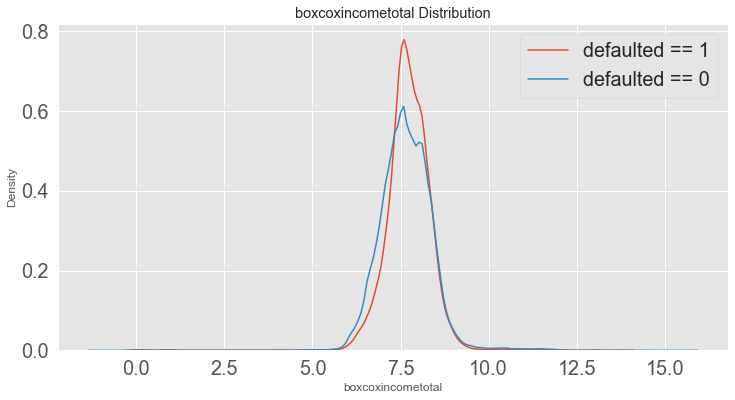

In [78]:
kde_target('boxcoxincometotal', x)

Overall we see that box log and boxcox transformation are posibble methods to reduce the skewness and also improve the correlation with the target variable.

We do however, need to filter and impute records with zero incometotal which is deemed to be an anomaly.

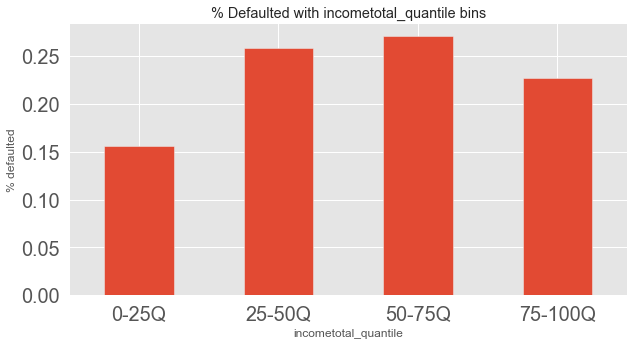

In [77]:
# for binning, it makes more sense to do quantile based binning
quantile_bin_default_plot('incometotal')

### Loanduration (Num)

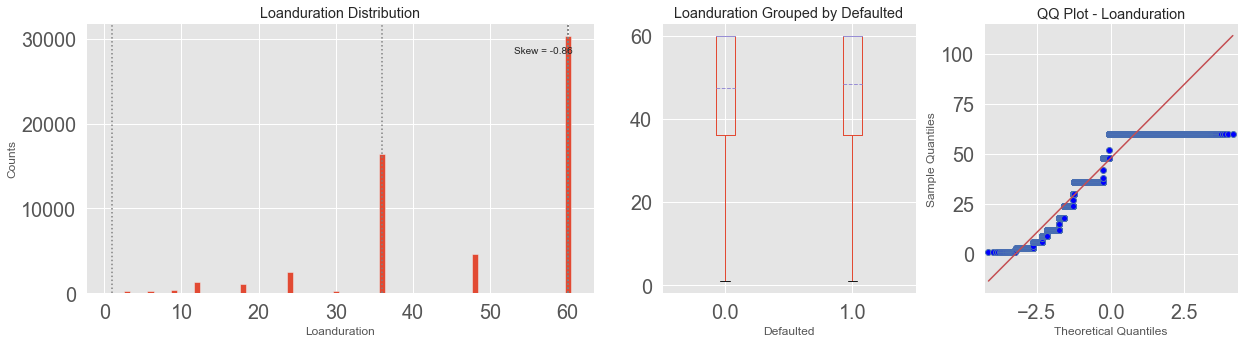

<Figure size 432x288 with 0 Axes>

In [79]:
numerical_plot('loanduration', discrete=True, sparse=True, box_by='defaulted')

Here we see that while loanduration is a continuous variable, there are a few popular values, which result in the severe deviation of the distribution from normal. It is understandable that the majority of the loan applicants choose to have the longest loanduration as it eases their monthly payment amount, though not so much the total amount

The correlation between loanduration and the TARGET is 0.0296
Median value for loan that is non-default = 60.0000
Median value for loan that defaulted =     60.0000


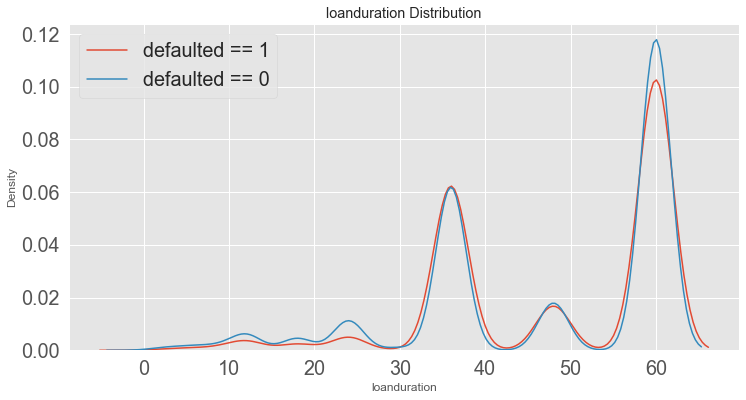

In [80]:
kde_target('loanduration', train)

Here we see that `loanduration` has a very weak correlation with the target variable and the kde does not suggest a very distinct distribution of the said variable when the target variable is 0 or 1.

Lets try binning.

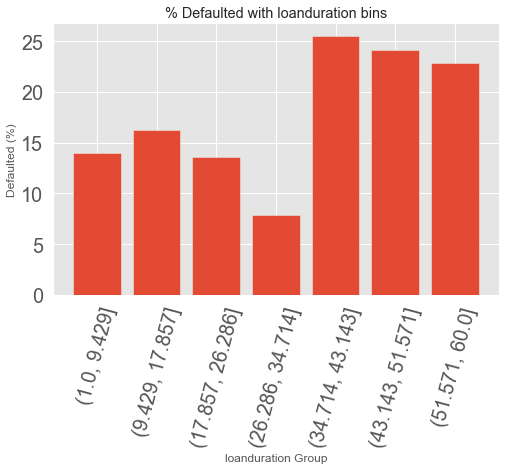

In [81]:
# through iteration, we find that a bin of 7 seems to be a good number.
min_max_bin_default_plot('loanduration', 7)

We could bin the `loanduration` as above.

### Amountofpreviousloansbeforeloan (Num)

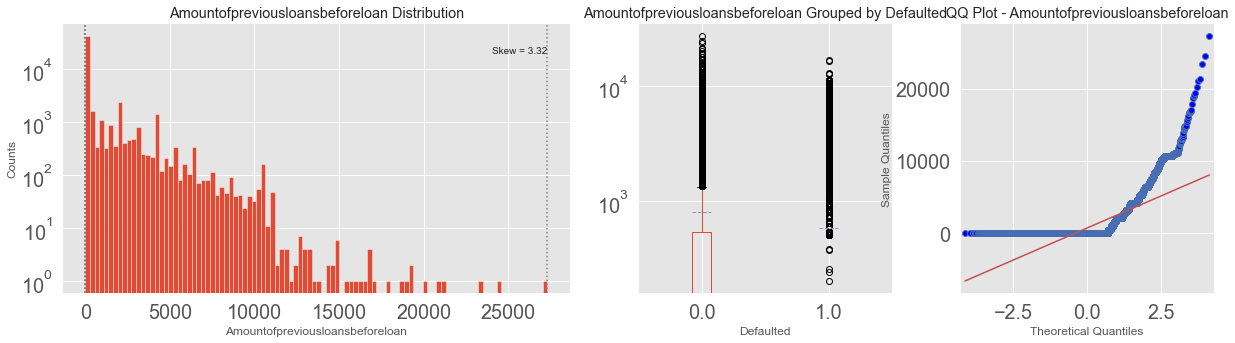

<Figure size 432x288 with 0 Axes>

In [82]:
numerical_plot('amountofpreviousloansbeforeloan', dist_yscale='log', box_by='defaulted')

In [83]:
no_of_iqr_outliers('amountofpreviousloansbeforeloan')

Q1: 0.0
Q3: 0.0
IQR :0.0
Number of Outliers: 14021


We see that a large proportion of `amountofpreviousloansbeforeloan` have zero values, approximately, 43000 out of 57500. This results in a large porportion of values lying outside the 1.5 x IQR +/- Q1/Q3. Such is the nature of the data and it is not recommended to impute or otherwise.

It may be better to create a separate feature capturing indicating if those with `amountofpreviousloansbeforeloan` is zero and those without. This is conincidentally captured by the feature `noofpreviousloansbeforeloan`.

Also as this is basically a zero-inflation issue, certain classifcation algorithms such as tree-based models are highly appropriate to handle such data.

Alternatively, we will have to find a zero-inflated model to model the feature.

In [84]:
train.loc[train['noofpreviousloansbeforeloan'] == 0, 'amountofpreviousloansbeforeloan'].value_counts(dropna=False)

0.0    43554
Name: amountofpreviousloansbeforeloan, dtype: int64

The correlation between amountofpreviousloansbeforeloan and the TARGET is -0.0519
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


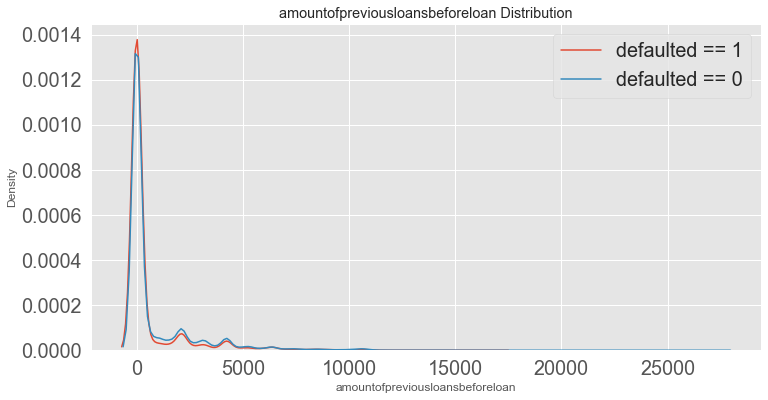

In [85]:
kde_target('amountofpreviousloansbeforeloan', train)

We see a weak correlation. Lets try some transformations: log1p, cbrt, sqrt and yeo johnson

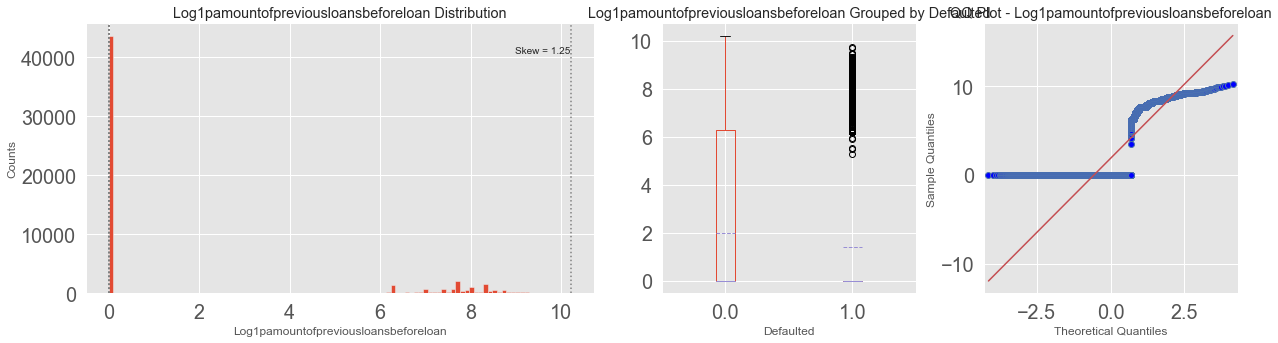

<Figure size 432x288 with 0 Axes>

The correlation between log1pamountofpreviousloansbeforeloan and the TARGET is -0.0741
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


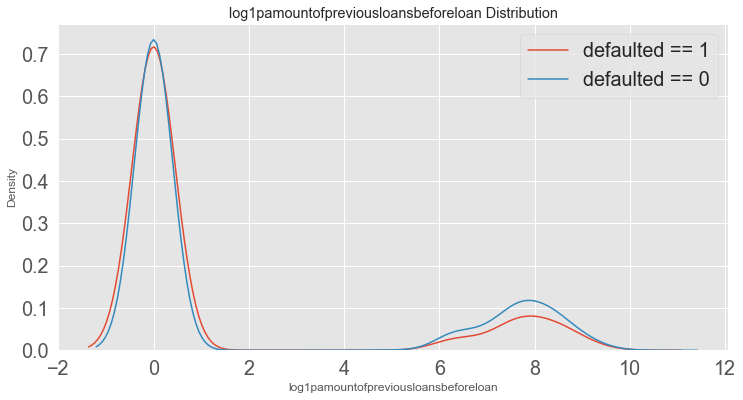

In [86]:
x = train.copy()
x['amountofpreviousloansbeforeloan'] = x['amountofpreviousloansbeforeloan'] + 1
x['log1pamountofpreviousloansbeforeloan'] = np.log(x['amountofpreviousloansbeforeloan'])
numerical_plot('log1pamountofpreviousloansbeforeloan', box_by='defaulted', df=x)
kde_target('log1pamountofpreviousloansbeforeloan', x)

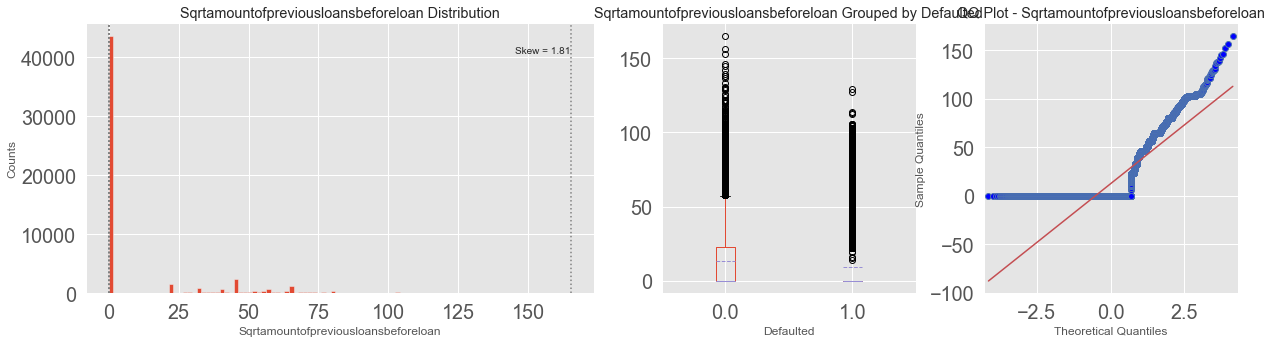

<Figure size 432x288 with 0 Axes>

The correlation between sqrtamountofpreviousloansbeforeloan and the TARGET is -0.0656
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


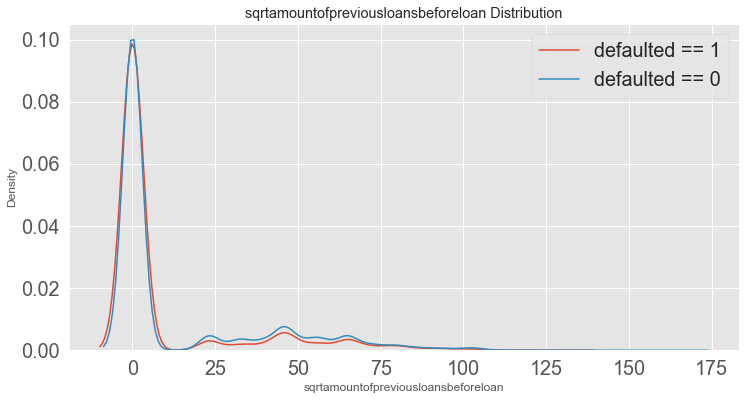

In [87]:
x = train.copy()
x['sqrtamountofpreviousloansbeforeloan'] = np.sqrt(x['amountofpreviousloansbeforeloan'])
numerical_plot('sqrtamountofpreviousloansbeforeloan', box_by='defaulted', df=x)
kde_target('sqrtamountofpreviousloansbeforeloan', x)

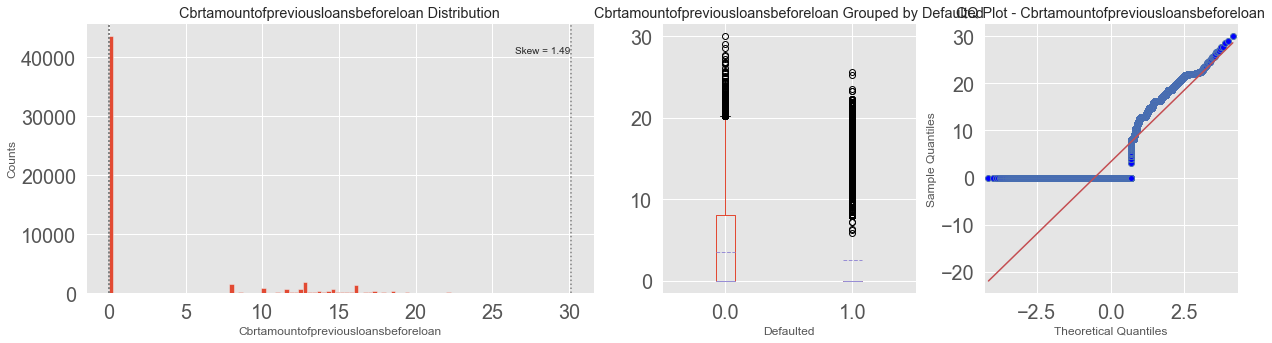

<Figure size 432x288 with 0 Axes>

The correlation between cbrtamountofpreviousloansbeforeloan and the TARGET is -0.0700
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


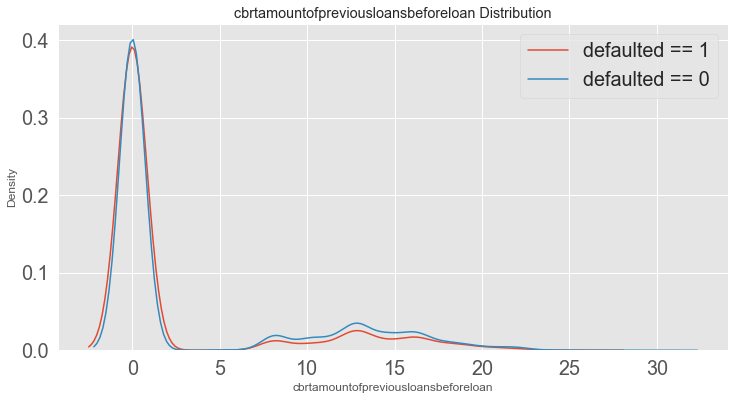

In [88]:
x = train.copy()
x['cbrtamountofpreviousloansbeforeloan'] = np.cbrt(x['amountofpreviousloansbeforeloan'])
numerical_plot('cbrtamountofpreviousloansbeforeloan', box_by='defaulted', df=x)
kde_target('cbrtamountofpreviousloansbeforeloan', x)

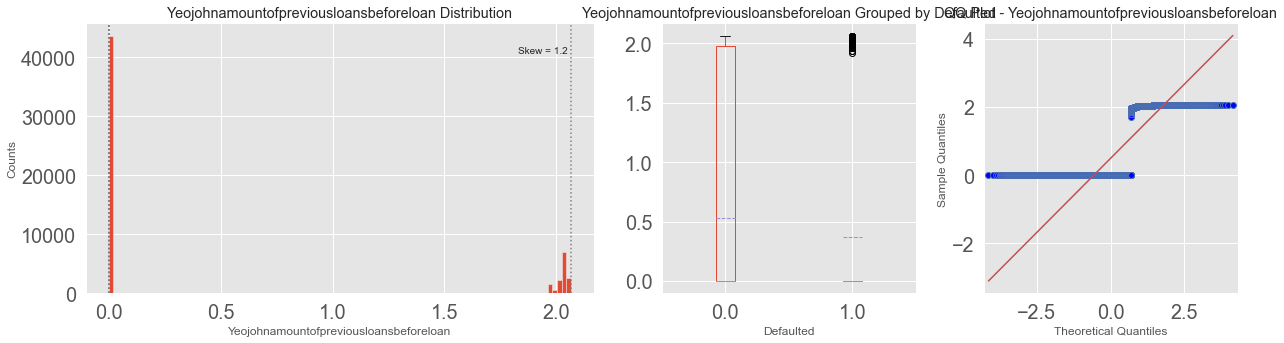

<Figure size 432x288 with 0 Axes>

The correlation between yeojohnamountofpreviousloansbeforeloan and the TARGET is -0.0756
Median value for loan that is non-default = -0.0000
Median value for loan that defaulted =     -0.0000


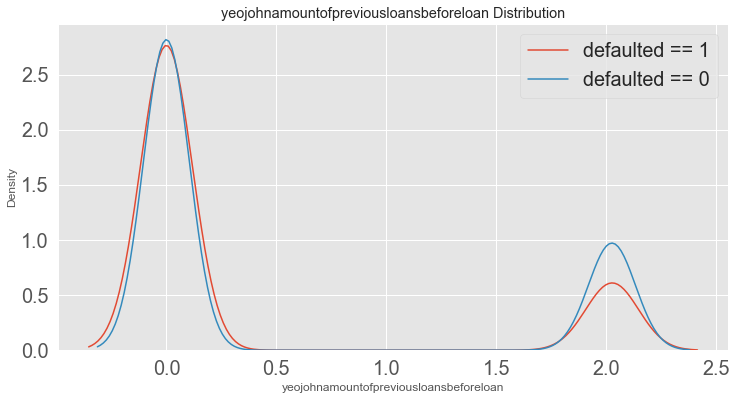

In [89]:
# boxcox transform
x = train.copy()
x['yeojohnamountofpreviousloansbeforeloan'], _ = yeojohnson(x['amountofpreviousloansbeforeloan'])
# check distribution
numerical_plot('yeojohnamountofpreviousloansbeforeloan', box_by='defaulted', df=x)
kde_target('yeojohnamountofpreviousloansbeforeloan', x)

We see that the yeojohnson transformation for `amountofpreviousloansbeforeloan` is the best to reduce the skewness and also improve the correlation to `defaulted`

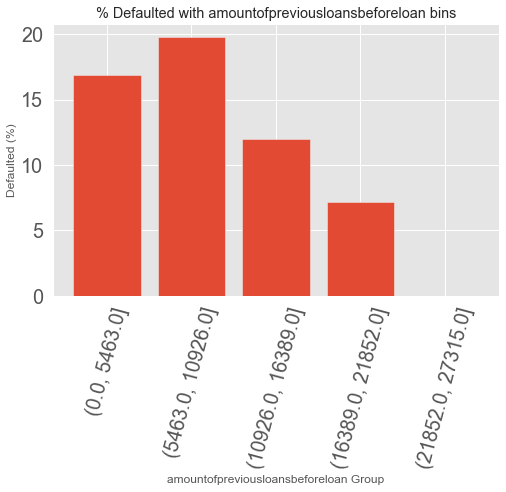

In [90]:
# by iteration, it seems that 5 bins is reasonable
min_max_bin_default_plot('amountofpreviousloansbeforeloan', 5)

Overall, for `amountofpreviousloansbeforeloan`, we can do a powertransformation including yeojohnson and a binning, which showed that in general with increasing amount of previous loans, the date of default decreases, but it is also possible that the low rates could be an artifact of the naturally low occurence of high `amountofpreviousloansbeforeloan`.

### Priorrepayments (Num)

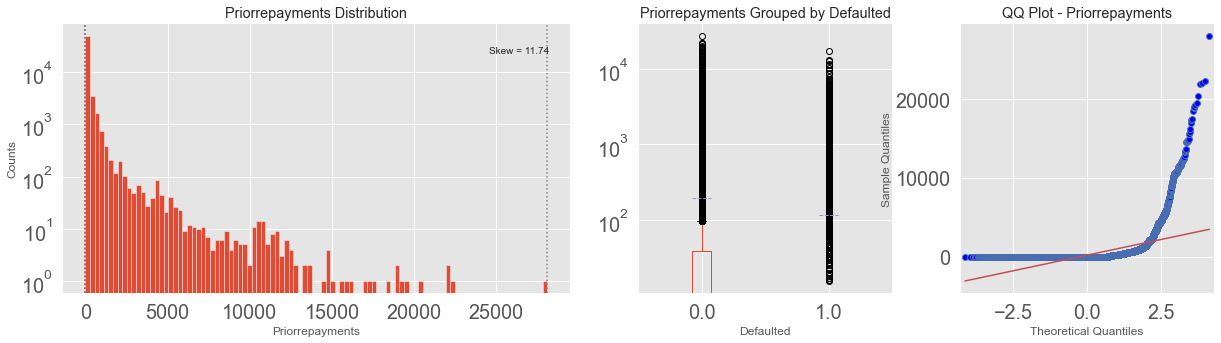

<Figure size 432x288 with 0 Axes>

In [91]:
numerical_plot('priorrepayments', dist_yscale='log', box_by='defaulted')

In [92]:
no_of_iqr_outliers('priorrepayments')

Q1: 0.0
Q3: 0.0
IQR :0.0
Number of Outliers: 13842


In [93]:
train.loc[train['priorrepayments'] == 0, 'noofpreviousloansbeforeloan'].value_counts(dropna=False)

0.0    43554
1.0      163
2.0       13
3.0        1
5.0        1
4.0        1
Name: noofpreviousloansbeforeloan, dtype: int64

The correlation between priorrepayments and the TARGET is -0.0404
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


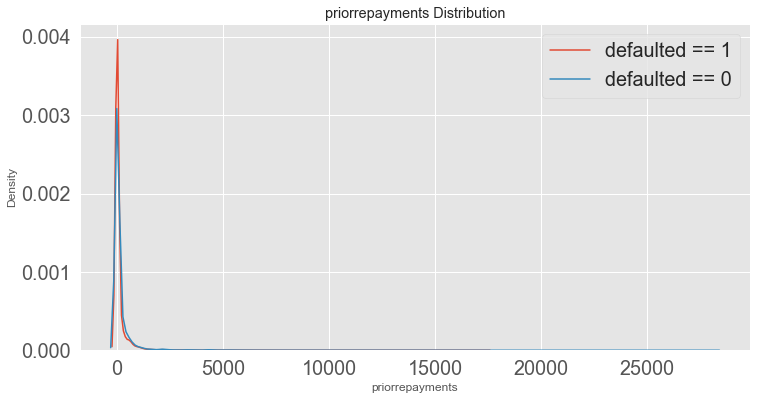

In [94]:
kde_target('priorrepayments', train)

Here we see the zero-inflation problems again. We see that a large proportion of `priorrepayments` have zero values, approximately, 43700 out of 57500. There is a high possibiliuty that these are genuine zeros, where there are no prior loans so there can be no prior repayments, while some the zeros are natural occurences where there is a prior loan but no payment was done.

We could create a separate feature capturing indicating if those with `priorrepayments` is zero and those not zero:

In [95]:
x = train.copy()
# create new feature priorrepaymentsmade - categorical feature
x['priorrepaymentsmade'] = x['priorrepayments'].copy()
# where priorrepaymentsmade = 1 means that there are priorrepayments
x.loc[x['priorrepaymentsmade'] != 0, 'priorrepaymentsmade'] = 1
x['priorrepaymentsmade'].value_counts(dropna=False)

0.0    43733
1.0    13842
Name: priorrepaymentsmade, dtype: int64

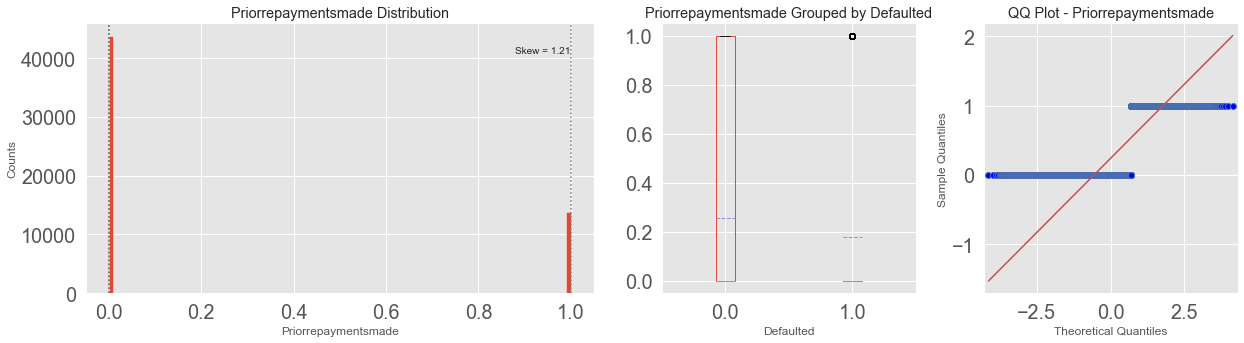

<Figure size 432x288 with 0 Axes>

The correlation between priorrepaymentsmade and the TARGET is -0.0755
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


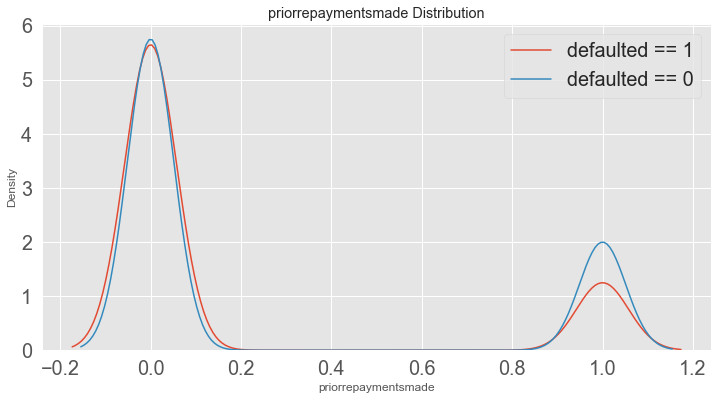

In [96]:
numerical_plot('priorrepaymentsmade', box_by='defaulted', df=x)
kde_target('priorrepaymentsmade', x)

We can also try doing some power transformations similar to `amountofpreviousloansbeforeloans`:

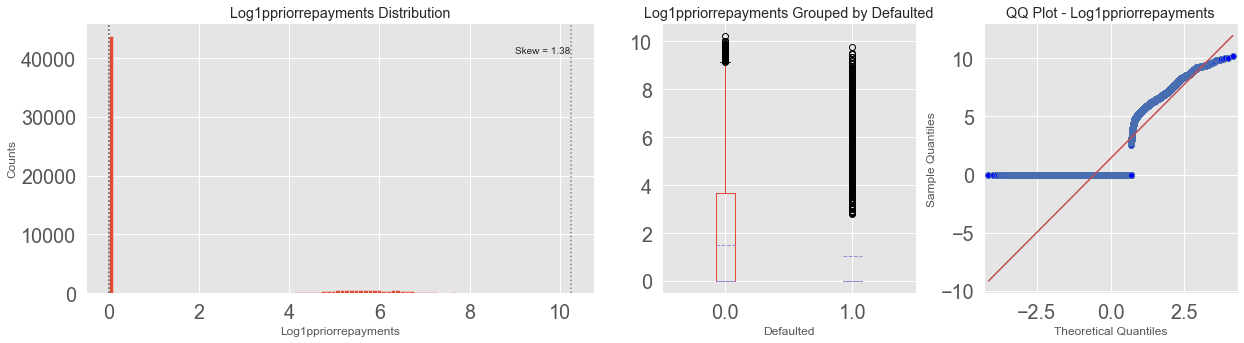

<Figure size 432x288 with 0 Axes>

The correlation between log1ppriorrepayments and the TARGET is -0.0721
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


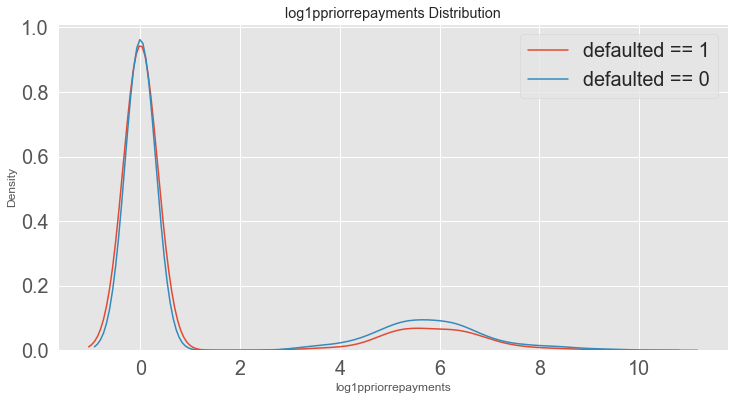

In [97]:
x = train.copy()
x['priorrepayments'] = x['priorrepayments'] + 1
x['log1ppriorrepayments'] = np.log(x['priorrepayments'])
numerical_plot('log1ppriorrepayments', box_by='defaulted', df=x)
kde_target('log1ppriorrepayments', x)

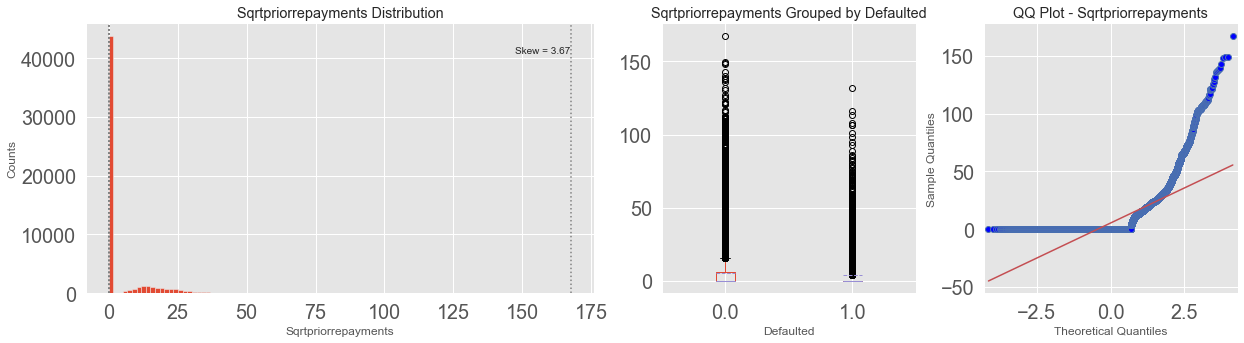

<Figure size 432x288 with 0 Axes>

The correlation between sqrtpriorrepayments and the TARGET is -0.0613
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


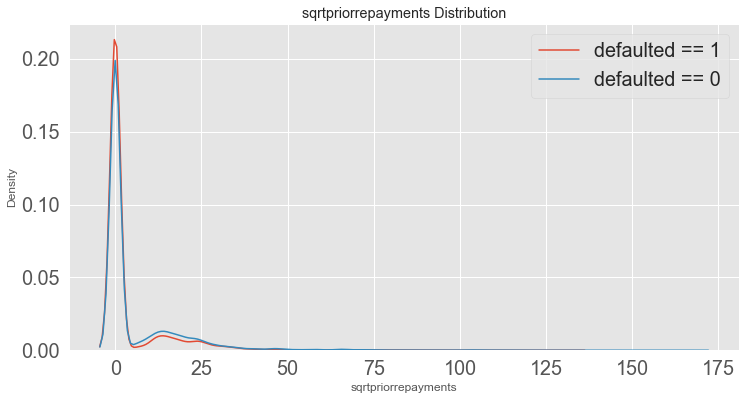

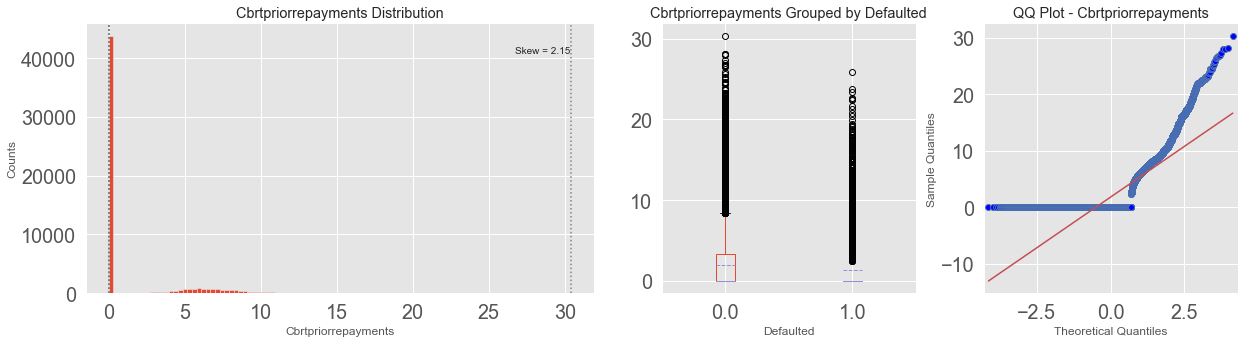

<Figure size 432x288 with 0 Axes>

The correlation between cbrtpriorrepayments and the TARGET is -0.0680
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


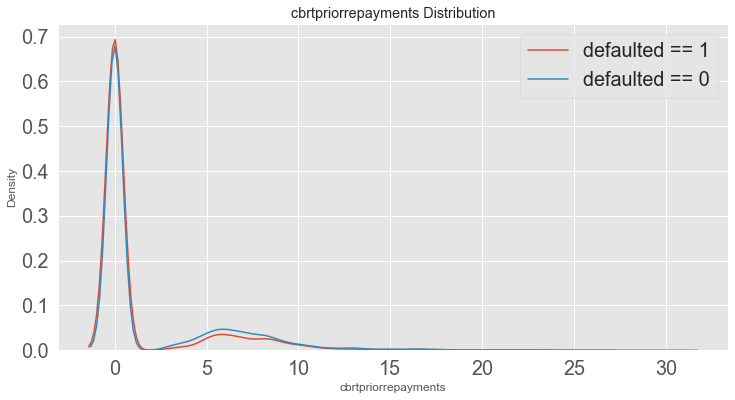

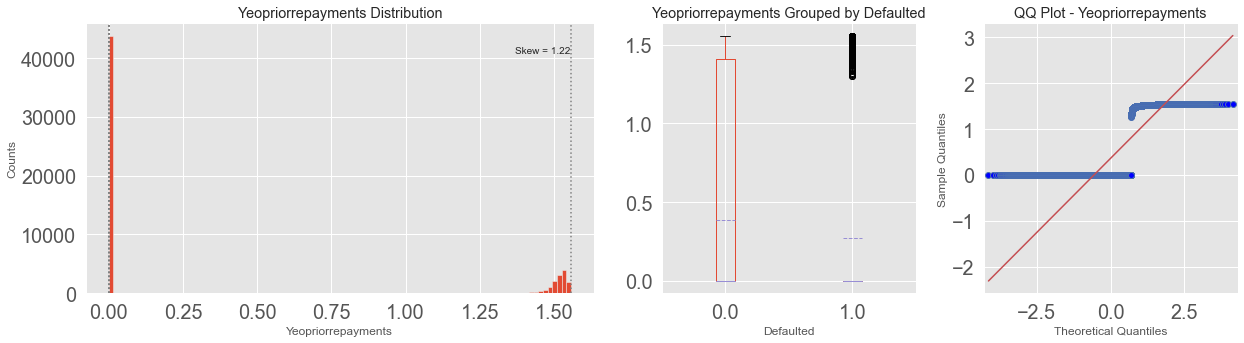

<Figure size 432x288 with 0 Axes>

The correlation between yeopriorrepayments and the TARGET is -0.0750
Median value for loan that is non-default = -0.0000
Median value for loan that defaulted =     -0.0000


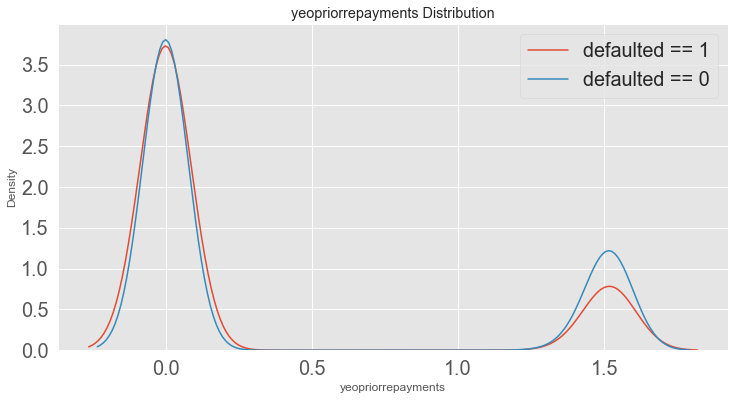

In [98]:
# sqrt
x = train.copy()
x['sqrtpriorrepayments'] = np.sqrt(x['priorrepayments'])
numerical_plot('sqrtpriorrepayments', box_by='defaulted', df=x)
kde_target('sqrtpriorrepayments', x)

#cbrt
x = train.copy()
x['cbrtpriorrepayments'] = np.cbrt(x['priorrepayments'])
numerical_plot('cbrtpriorrepayments', box_by='defaulted', df=x)
kde_target('cbrtpriorrepayments', x)

#yeojohnson
# boxcox transform
x = train.copy()
x['yeopriorrepayments'], _ = yeojohnson(x['priorrepayments'])
# check distribution
numerical_plot('yeopriorrepayments', box_by='defaulted', df=x)
kde_target('yeopriorrepayments', x)


In this case, it seems that while the powertransformation helps, binarizing the feature `priorrepayments` actually helps more.

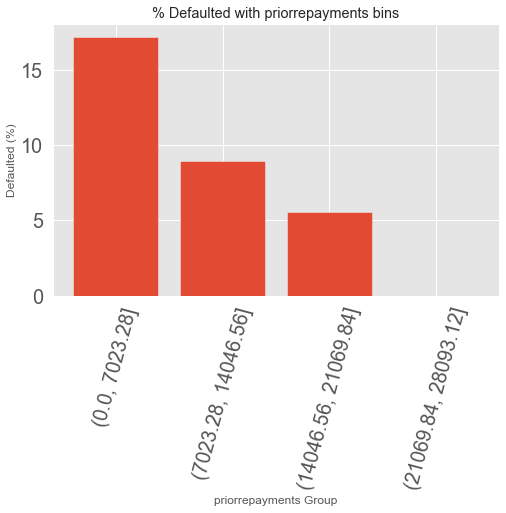

In [99]:
# we see that it is also possible to bin the feature into 4 bins
min_max_bin_default_plot('priorrepayments', 4)

### Noofpreviousloansbeforeloan (Num)

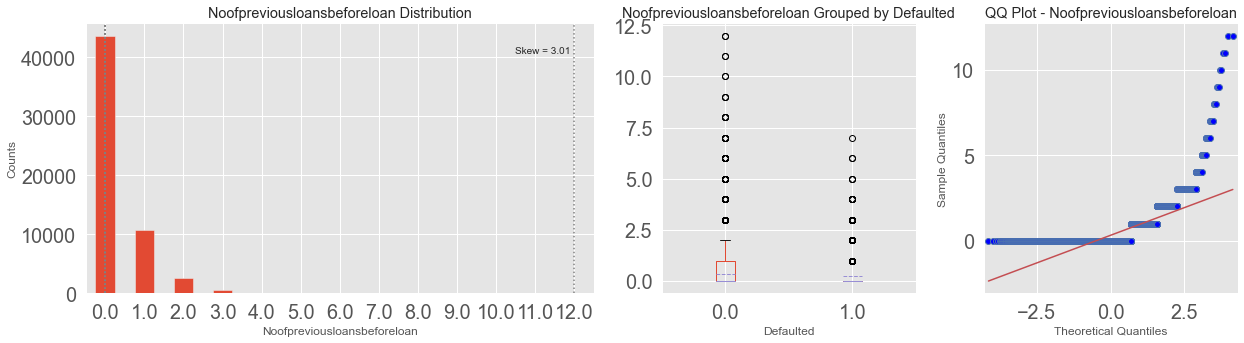

<Figure size 432x288 with 0 Axes>

Q1: 0.0
Q3: 0.0
IQR :0.0
Number of Outliers: 14021


In [100]:
numerical_plot('noofpreviousloansbeforeloan', discrete=True, box_by='defaulted')
no_of_iqr_outliers('noofpreviousloansbeforeloan')

Here we see the zero-inflation problem again. We have an option to binarize, i.e. previousloanstaken (yes/no) and powertransformations:

The correlation between noofpreviousloansbeforeloan and the TARGET is -0.0669
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


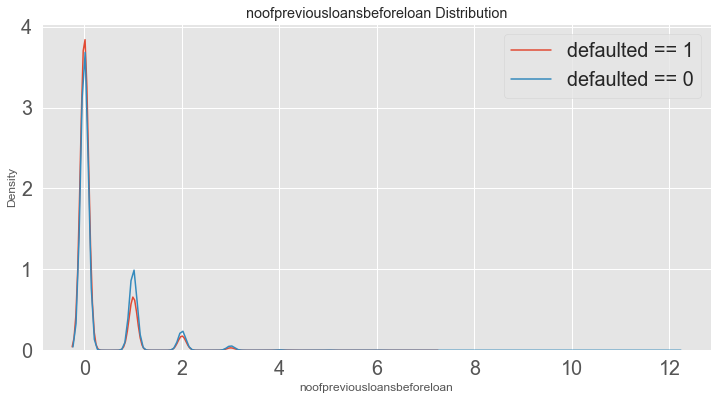

In [101]:
kde_target('noofpreviousloansbeforeloan', x)

In [102]:
x = train.copy()
# create new feature previousloanstaken - categorical feature
x['previousloanstaken'] = x['noofpreviousloansbeforeloan'].copy()
# where priorrepaymentsmade = 1 means that there are priorrepayments
x.loc[x['previousloanstaken'] != 0, 'previousloanstaken'] = 1
x['previousloanstaken'].value_counts(dropna=False)

0.0    43554
1.0    14021
Name: previousloanstaken, dtype: int64

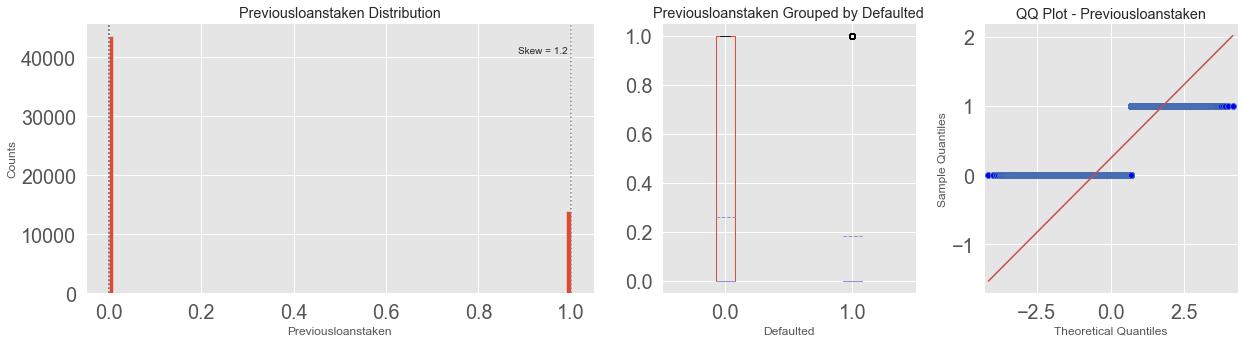

<Figure size 432x288 with 0 Axes>

The correlation between previousloanstaken and the TARGET is -0.0758
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


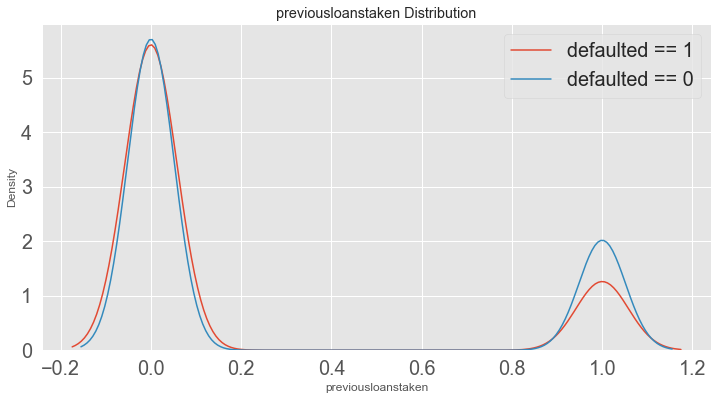

In [103]:
numerical_plot('previousloanstaken', box_by='defaulted', df=x)
kde_target('previousloanstaken', x)

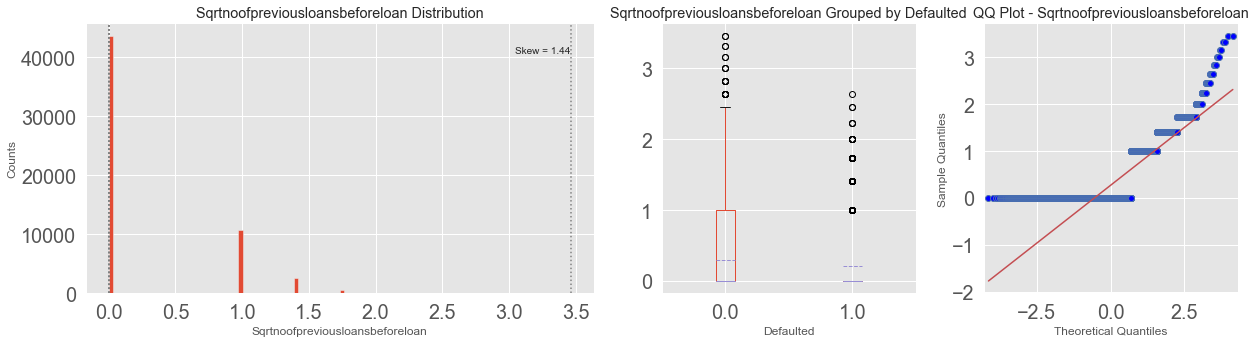

<Figure size 432x288 with 0 Axes>

The correlation between sqrtnoofpreviousloansbeforeloan and the TARGET is -0.0740
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


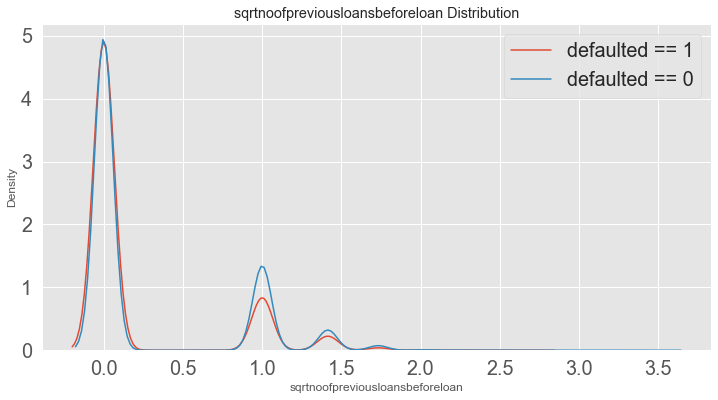

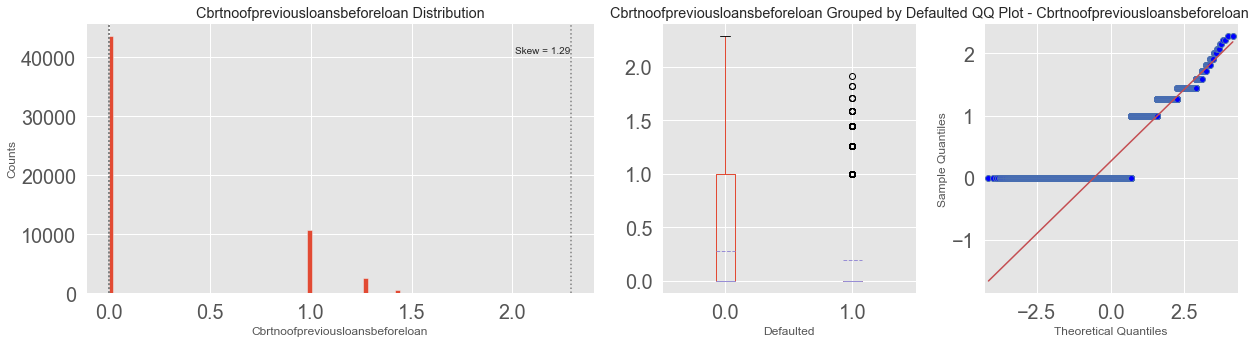

<Figure size 432x288 with 0 Axes>

The correlation between cbrtnoofpreviousloansbeforeloan and the TARGET is -0.0750
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


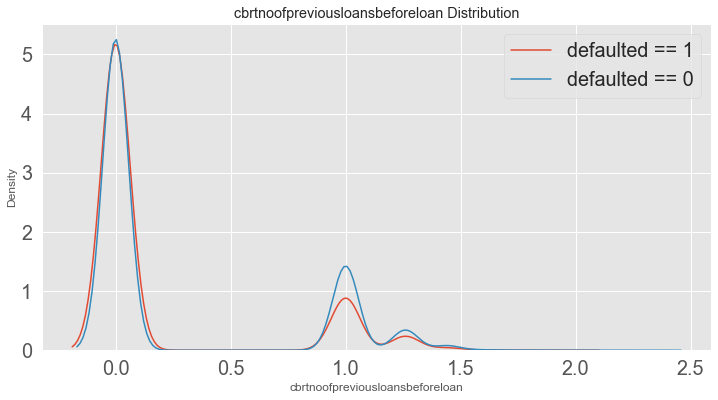

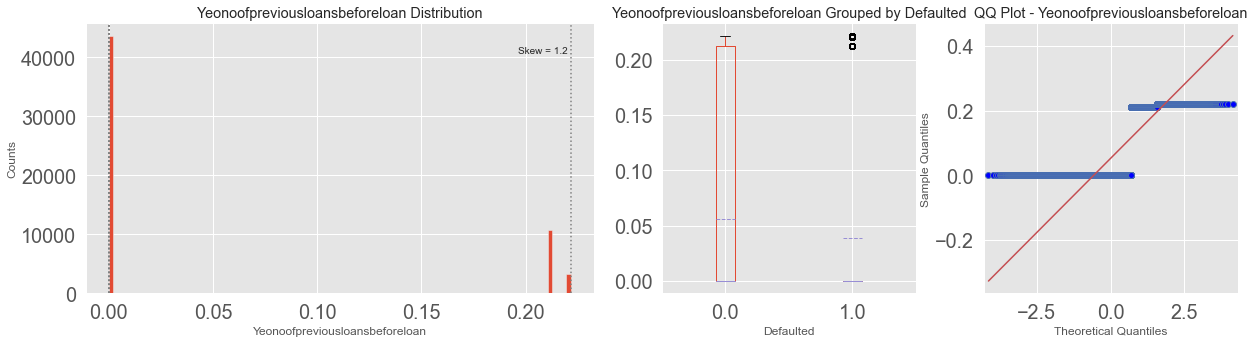

<Figure size 432x288 with 0 Axes>

The correlation between yeonoofpreviousloansbeforeloan and the TARGET is -0.0757
Median value for loan that is non-default = -0.0000
Median value for loan that defaulted =     -0.0000


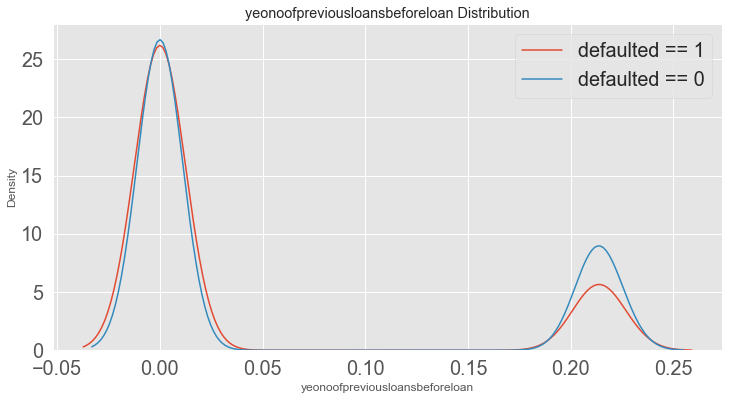

In [104]:
# sqrt
x = train.copy()
x['sqrtnoofpreviousloansbeforeloan'] = np.sqrt(x['noofpreviousloansbeforeloan'])
numerical_plot('sqrtnoofpreviousloansbeforeloan', box_by='defaulted', df=x)
kde_target('sqrtnoofpreviousloansbeforeloan', x)

#cbrt
x = train.copy()
x['cbrtnoofpreviousloansbeforeloan'] = np.cbrt(x['noofpreviousloansbeforeloan'])
numerical_plot('cbrtnoofpreviousloansbeforeloan', box_by='defaulted', df=x)
kde_target('cbrtnoofpreviousloansbeforeloan', x)

#yeojohnson
# boxcox transform
x = train.copy()
x['yeonoofpreviousloansbeforeloan'], _ = yeojohnson(x['noofpreviousloansbeforeloan'])
# check distribution
numerical_plot('yeonoofpreviousloansbeforeloan', box_by='defaulted', df=x)
kde_target('yeonoofpreviousloansbeforeloan', x)


We see that binarizing could be an option.

### Noofearlierdefaults (Num)

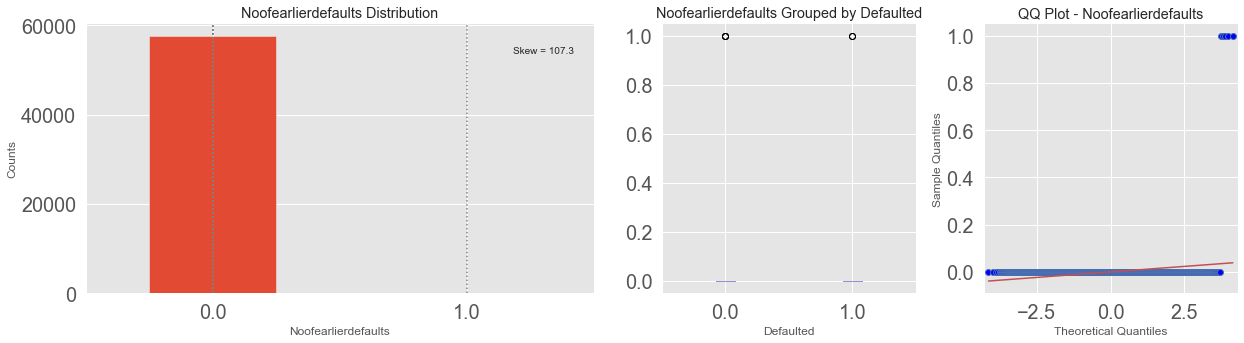

<Figure size 432x288 with 0 Axes>

Q1: 0.0
Q3: 0.0
IQR :0.0
Number of Outliers: 5


In [105]:
numerical_plot('noofearlierdefaults', discrete=True, box_by='defaulted')
no_of_iqr_outliers('noofearlierdefaults')

In [106]:
train['noofearlierdefaults'].value_counts(dropna=False)

0.0    57570
1.0        5
Name: noofearlierdefaults, dtype: int64

Here we see that there are actually only 5 counts of loanapplications with earlier defaults

The correlation between noofearlierdefaults and the TARGET is 0.0038
Median value for loan that is non-default = 0.0000
Median value for loan that defaulted =     0.0000


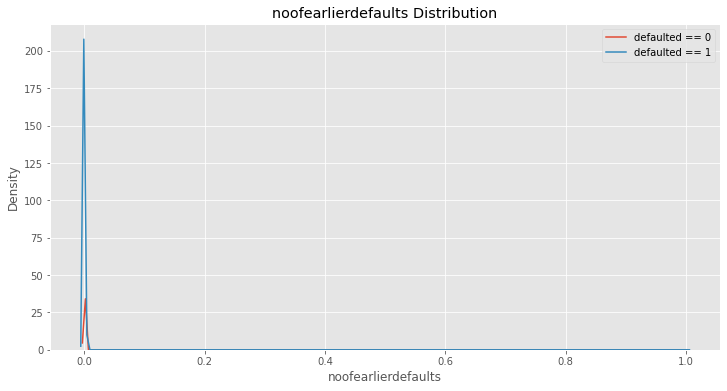

In [87]:
kde_target('noofearlierdefaults', train)

> __Expectedly, we see that the feature is actually not very useful. We should consider dropping this.__

### Homeownershiptype (Cat - Nominal)

Earlier we have identified that `homeownershiptype` has some missing values, have instances of undefined values, and is categorical in nature. Lets explore further.

0.11704905155294419
probability = 0.950, critical = 19.675, stat = 798.189
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


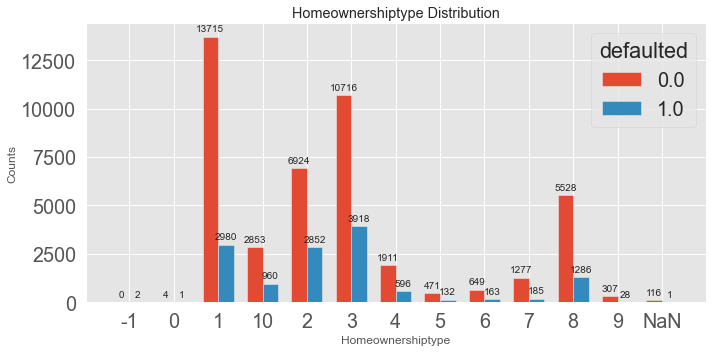

In [107]:
cat_plot('homeownershiptype', df=train)

It shows that `homeownershiptype` has a weak association with `defaulted`

Here we see that there are 117 missing values, and 2 instances of -1 values. From the data dictionary we know that:

- 0 : Homeless 
- 1 : Owner 
- 2 : Living with parents 
- 3 : Tenant, pre-furnished property 
- 4 : Tenant, unfurnished property 
- 5 : Council house 
- 6 : Joint tenant 
- 7 : Joint ownership 
- 8 : Mortgage 
- 9 : Owner with encumbrance 
- 10 : Other

While there are some differences in the different standards of housing types, there is however, no clear order across all the housing types. As such, the feature is a nominal variable. We also notice that there are 11 different classes, some with very small occurences (< 1%) across the whole train dataset.

Lets first understand the undefined value and the NaN values:

In [108]:
# lets check the loan applications with NaN homeownershiptype value
data = train[train['homeownershiptype'].isna()]
data.shape

(117, 31)

Given that there are 43554 distinct `username`s compared to 57575 total rows in the train dataset, there are some repeated clients. It is possible that some information fields that are currently absent in these `username`s' applications may be found in their other loan applications found in the database of the financial institution. Lets check this:

In [109]:
# filter from train dataset all the transactions belonging to usernames with nan homeownershiptype
train.loc[train['username'].isin(set(data['username'])), ['username', 'loanid', 'loanapplicationstarteddate', 'homeownershiptype']]

username                                loanid  \
0         lydric  BFD2FE92-ADE3-42D9-94F2-9D2C00E2C4FF   
1    13Maximus13  71828281-FD62-45B9-8C96-9D35014FE87F   
2       TAAWOKAS  28854CE8-269B-4103-ADA6-9D360156C8F0   
3         Fius24  DF9B0542-8324-4618-90E7-9D3D00BA91F2   
4          rraag  EF1FC55F-584E-434D-90C0-9D3E00D04536   
..           ...                                   ...   
224      Alkocen  8F8E7053-C4C0-41B2-B55D-9E8B00F31656   
233          bot  FC344159-CEC4-4D80-95A4-9E9F00F7CA73   
239       Onsola  773A4019-61FE-4770-BAE3-9EA701084A0B   
269        VALLY  3C826A1C-3357-4C0E-B896-9EC500F7E9AD   
272     peremees  D477A11B-0489-442C-B832-9ECA00B32902   

    loanapplicationstarteddate homeownershiptype  
0          2010-03-01 13:45:00               NaN  
1          2010-03-10 20:23:00               NaN  
2          2010-03-11 20:48:00               NaN  
3          2010-03-18 11:19:00               NaN  
4          2010-03-19 12:38:00               NaN  
..                         ...               ...  
224        2011-02-15 14:45:00                 2  
233        2011-03-07 15:02:00                 9  
239        2011-03-15 16:02:00                 8  
269        2011-04-14 15:02:00                 1  
272        2011-04-19 10:52:00                 7  

[170 rows x 4 columns]

Here we see that there are indeed some transactions with non-Nan `homeownershiptype` values belonging to usernames which have NaN `homeownershiptype` values. For example, loan applications belonging to bot and Alkocen:

In [110]:
train.loc[train['username']=='bot']

defaulted                                loanid username  \
94         0.0  D00FC400-CFD2-441B-966D-9DFF0183A4ED      bot   
135        0.0  62B79996-BF11-4298-AC19-9E2000DE7431      bot   
197        0.0  399DF3DF-1F84-4416-B7EA-9E620172F80D      bot   
233        0.0  FC344159-CEC4-4D80-95A4-9E9F00F7CA73      bot   

    loanapplicationstarteddate languagecode   age gender country  \
94         2010-09-28 23:31:00            3  43.0      0      EE   
135        2010-10-31 13:29:00            3  43.0      0      EE   
197        2011-01-05 22:30:00            3  43.0      0      EE   
233        2011-03-07 15:02:00            3  43.0      0      EE   

     appliedamount  interest  ...  incomefromothers existingliabilities  \
94        319.5582      25.0  ...               0.0                 3.0   
135       255.6466      30.0  ...               0.0                 4.0   
197       450.0000      30.0  ...               0.0                 4.0   
233      1000.0000      25.0  ...               0.0                 4.0   

    liabilitiestotal debttoincome noofearlierdefaults  \
94            2705.0          0.0                 0.0   
135           2973.0          0.0                 0.0   
197            206.0          0.0                 0.0   
233            233.0          0.0                 0.0   

    noofpreviousloansbeforeloan amountofpreviousloansbeforeloan  \
94                          0.0                          0.0000   
135                         1.0                        319.6377   
197                         2.0                        575.3982   
233                         3.0                       1025.3982   

    priorrepayments previousearlyrepaymentsbeforeloan  \
94           0.0000                               0.0   
135          0.0000                               0.0   
197         55.9905                               0.0   
233        150.8705                               0.0   

     previousearlyrepaymentscountbeforeloan  
94                                      0.0  
135                                     0.0  
197                                     0.0  
233                                     0.0  

[4 rows x 31 columns]

In [111]:
train.loc[train['username']=='Alkocen']

defaulted                                loanid username  \
69         0.0  DC356796-E9BF-420D-A16C-9DE800DEF843  Alkocen   
129        0.0  857B1A93-8368-4ABA-879E-9E1A00AD14FC  Alkocen   
224        0.0  8F8E7053-C4C0-41B2-B55D-9E8B00F31656  Alkocen   

    loanapplicationstarteddate languagecode   age gender country  \
69         2010-09-05 13:31:00            1  21.0      0      EE   
129        2010-10-25 10:30:00            1  21.0      0      EE   
224        2011-02-15 14:45:00            1  22.0      0      EE   

     appliedamount  interest  ...  incomefromothers existingliabilities  \
69         63.9116      40.0  ...               0.0                 0.0   
129        70.3028      30.0  ...               0.0                 0.0   
224       100.0000      28.0  ...               0.0                 0.0   

    liabilitiestotal debttoincome noofearlierdefaults  \
69               0.0          0.0                 0.0   
129              0.0          0.0                 0.0   
224              0.0          0.0                 0.0   

    noofpreviousloansbeforeloan amountofpreviousloansbeforeloan  \
69                          0.0                          0.0000   
129                         1.0                         63.9118   
224                         2.0                        134.2146   

    priorrepayments previousearlyrepaymentsbeforeloan  \
69           0.0000                               0.0   
129         67.8540                               0.0   
224        138.6203                               0.0   

     previousearlyrepaymentscountbeforeloan  
69                                      0.0  
129                                     0.0  
224                                     0.0  

[3 rows x 31 columns]

Here we observe that it is possible for `homeownershiptype` values to change with time for the same client, and it seems that most NaN `homeownershiptype` value occur at a very early `loanapplicationstarteddate`, but this may not neccessarily be the case for future loan applications.

Based on this we can have a number of conclusion for `homeownershiptype`:

1. `homeownershiptype` value changes with time
2. There are some clients who may have a mixture of nan and non-nan `homeownershiptype` values
-----


We thus propose a method to treat the missing `homeownershiptype` values:

1. For missing `homeownershiptype` value transactions, we propose to counter check with earlier loan applications belonging to the same `username`s for earlier `homeownershiptype` values. Note the empahsis on __earlier__.

    - The assumption here is that nan-value transactions will assume the latest possible non-nan `homeownershiptype` value.
    - This process must only obtain values from earlier transactions.
    
    
2. For remaining nan `homeownershiptype` values, we will carry out conventional treatments such as imputation or deletion.


----

Lets validate this. First lets the load earlier saved Database.csv that has not been split into train and test set, and contains some other credit history related features as the database. 

> To simulate the actual operation condition where every new loan applications entered into the system can only view data from __past loan applications__, an important rule that must be adhered to when carrying out any ETL processes would be that the new loan's `loanapplicationstarted` date __must be and can only be later__ than the past loan applications' loan disbursement date, `loandate`.

> In some ways, it is a variation to the Last Observation Carried Forward (LOCF) methodology

In [112]:
# get loans with missing homeownershiptype values
data = train.loc[train['homeownershiptype'].isna()].copy()

data = fill_with_earlier(data, db_df, data_var='homeownershiptype', database_var='HomeOwnershipType', lowercase=True)

In [113]:
data['homeownershiptype'].value_counts(dropna=False)

NaN    117
Name: homeownershiptype, dtype: int64

Unfortunately we see that of all the 117 loan applications with NAN `homeownershiptype` values, none of them have earlier non-NAN `homeownershiptype` values. Nevertheless, we can still keep the above process as part of the etl process. Lets check this using one of the `username` from above, `Fius24`

In [114]:
train.loc[train['username']=='Fius24']

defaulted                                loanid username  \
3          0.0  DF9B0542-8324-4618-90E7-9D3D00BA91F2   Fius24   
10         0.0  D2BC56F7-32BF-4790-80FA-9D4F0124023D   Fius24   
115        0.0  7CFC84A7-228A-45A2-9E05-9E0D01352F72   Fius24   

    loanapplicationstarteddate languagecode   age gender country  \
3          2010-03-18 11:19:00            1  26.0      0      EE   
10         2010-04-05 17:43:00            1  26.0      0      EE   
115        2010-10-12 18:45:00            1  27.0      0      EE   

     appliedamount  interest  ...  incomefromothers existingliabilities  \
3         127.8233      35.0  ...               0.0                 0.0   
10        639.1165      35.0  ...               0.0                 1.0   
115      1278.2330      35.0  ...               0.0                 1.0   

    liabilitiestotal debttoincome noofearlierdefaults  \
3                0.0          0.0                 0.0   
10               0.0          0.0                 0.0   
115              0.0          0.0                 0.0   

    noofpreviousloansbeforeloan amountofpreviousloansbeforeloan  \
3                           0.0                          0.0000   
10                          1.0                        127.8233   
115                         2.0                        766.9397   

    priorrepayments previousearlyrepaymentsbeforeloan  \
3            0.0000                               0.0   
10         129.7937                               0.0   
115        830.1569                               0.0   

     previousearlyrepaymentscountbeforeloan  
3                                       0.0  
10                                      0.0  
115                                     0.0  

[3 rows x 31 columns]

We see that the above statement holds true. Lets check the same for the loan applications with the undefined value (-1).

In [115]:
# create a mask to extract the loan applications of interest
mask = (train['homeownershiptype'] == '-1')

# get the masked loan applications
data = train[mask]

In [116]:
fill_with_earlier(data, db_df, 'homeownershiptype', 'HomeOwnershipType', lowercase=True)

defaulted                                loanid   username  \
0        1.0  BB82FE36-30C5-4BFB-B91A-A7ED00F4D5FF  BOKK94231   
1        1.0  0C0ED9DE-AC3F-4B4F-8DF3-A880013A1E38  BO627A5A7   

  loanapplicationstarteddate languagecode   age gender country  appliedamount  \
0        2017-09-13 14:51:00            6  57.0      0      ES          530.0   
1        2018-02-07 19:04:00            1  68.0      0      EE        10630.0   

   interest  ...  incomefromothers existingliabilities liabilitiestotal  \
0    146.36  ...               0.0                 0.0              0.0   
1     31.35  ...               0.0                 0.0              0.0   

  debttoincome noofearlierdefaults noofpreviousloansbeforeloan  \
0          0.0                 0.0                         0.0   
1          0.0                 0.0                         0.0   

  amountofpreviousloansbeforeloan priorrepayments  \
0                             0.0             0.0   
1                             0.0             0.0   

  previousearlyrepaymentsbeforeloan  previousearlyrepaymentscountbeforeloan  
0                               0.0                                     0.0  
1                               0.0                                     0.0  

[2 rows x 31 columns]

Here we see that both loan applications belong to two `username`s who do not have any earlier loan applications. As such for loan applications with NaN and -1 values, we will have to carry out other forms of conventional treatments.

In [117]:
train['homeownershiptype'].value_counts(dropna=False)

1      16695
3      14634
2       9776
8       6814
10      3813
4       2507
7       1462
6        812
5        603
9        335
NaN      117
0          5
-1         2
Name: homeownershiptype, dtype: int64

In [118]:
# generally, any homeownershiptype values not in 0:11 are all anomalies
error_trans = train[train['homeownershiptype'].isin(['-1', np.nan])].copy()

Since this list of loan applications have been checked to not possess any earlier loans, or any earlier loans with valid `homeownershiptype` values, we need to further understand why the data goes missing.

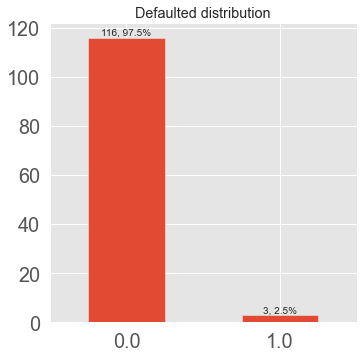

In [119]:
# plot distribution
data = error_trans['defaulted'].value_counts(dropna=False)

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(5.5, 5.5))
data.plot(kind='bar', rot=0, title='Defaulted distribution')

for i, v in enumerate(data):
    plt.text(i, v+1, str(round(v, 2))+', '+str(round(v/len(error_trans), 3)*100)+'%', horizontalalignment='center')

plt.show()

Here we see that the `defaulted` distribution is highly imbalanced and differs greatly with the normal train dataset distribution. While this is a small subset of data and may not be representative of the overall distribution belonging to the missing `homeownershiptype` value transactions, the difference is rather significant.

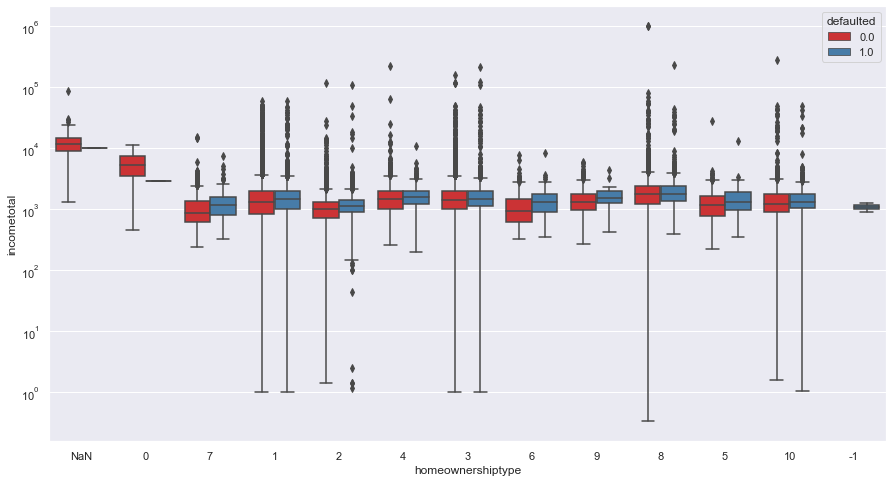

In [120]:
grouped_boxplot('homeownershiptype', 'incometotal', yscale='log')

We find that the it is difficult to see visually if the data missing is MCAR, MAR or MNAR. Lets perform a chi-square test between the `defaulted` target feature and the presence/absence of missing `homeownershiptype` data.

In [121]:
# make copy of data data
x = train.copy()

# relabel those with non -1 values as 1
x.loc[x['homeownershiptype'].isna(), 'homeownershiptype'] = '-1'
x.loc[x['homeownershiptype'] != '-1', 'homeownershiptype'] = '1'

# create a contigency table between the defaulted status and the presence/absence of homeownershiptype
table = pd.crosstab(x["homeownershiptype"], x["defaulted"]).to_numpy()
table

array([[  116,     3],
       [44355, 13101]], dtype=int64)

In [122]:
chi_square(table)

probability = 0.950, critical = 3.841, stat = 26.643
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


This means that there is some dependency between the missingness of the `homeownershiptype` and `defaulted` values.

In [123]:
cramers_v(table)

0.02110430364524823


0.02110430364524823

So from the Cramer's V test, we see that the `defaulted` and presence/absence of `homeownershipytype` does not have strong association, which is contradictory to the earlier Chi-square test. This may be a result of an increasing sample size, which will lead to a smaller p-value for the Chi-Square test.

As a middle ground, we will assume that the missingness is MAR, and we will use imputation methods to resolve.

As a base example, we can use Sklearn's SimpleImputer to impute the mode category

In [124]:
train.loc[train['homeownershiptype'].isin(['-1', np.nan]), 'homeownershiptype'] = np.nan

In [125]:
# use simpleimputer
# create instance
imp_mode = SimpleImputer(missing_values = np.nan, strategy='most_frequent') # mode
# fit to train[['test']]
imp_mode.fit(train[['homeownershiptype']])

SimpleImputer(strategy='most_frequent')

In [126]:
train['homeownershiptype'] = imp_mode.transform(train[['homeownershiptype']])

In [127]:
train['homeownershiptype'].value_counts(dropna=False)

1     16814
3     14634
2      9776
8      6814
10     3813
4      2507
7      1462
6       812
5       603
9       335
0         5
Name: homeownershiptype, dtype: int64

Imputation is successful.

For our datapipeline, we will first convert `homeownershiptype` column to categorical, followed by passing the column through our earlier defined fill_with_earlier function, followed by imputation.

Given the `homeownershiptype` variable is a nominal catgorical feature, we might also want to then onehot encode the variable. we will perhaps explore consolidating some of these lower % classess at a later stage.

0.1174720644851192
probability = 0.950, critical = 18.307, stat = 804.503
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


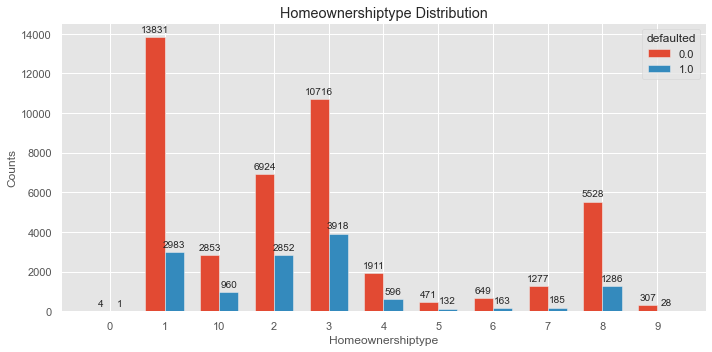

In [128]:
cat_plot('homeownershiptype', df=train)

### Nrofdependants (Cat - Ordinal)

`nrofdependants` was found to have 67% missing values. Lets explore the variable:

- 0 :  No dependants
- 1 :  1 dependant
- 2 :  2 dependants
- 3 :  3 dependants
- 4 :  4 dependants
- 5 : 5 dependants
- 6 : 6 dependants
- 7 : 7 dependants
- 8 : 8 dependants
- 9 : 9 dependants
- 10 : 10 dependants
- 10Plus : More than 10 dependants

0.08482164621119336
probability = 0.950, critical = 16.919, stat = 142.570
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


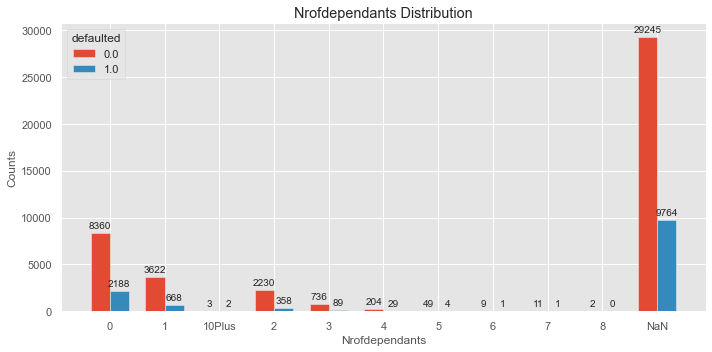

In [129]:
cat_plot('nrofdependants', df=train)

Here we see a number of issues other than the NaN issue. There are a number of categories which have very low occurences, i.e. less than 1% of the total dataset. We wiill consider what to do with them at a later stage.

Overall, the feature is a ordinal variable.

Lets first decide on how to treat the NaN values.

In [130]:
train['nrofdependants'].value_counts(dropna=False)

NaN       39009
0         10548
1          4290
2          2588
3           825
4           233
5            53
7            12
6            10
10Plus        5
8             2
Name: nrofdependants, dtype: int64

In [131]:
# lets call our fill_with_earlier function
train = fill_with_earlier(train,db_df, data_var='nrofdependants', database_var='NrOfDependants', lowercase=True)

In [132]:
# we managed to reduce some na values.
train['nrofdependants'].value_counts(dropna=False)

NaN       38344
0         10948
1          4447
2          2662
3           842
4           244
5            59
7            12
6            10
10Plus        5
8             2
Name: nrofdependants, dtype: int64

We have managed to reduce the amount of missing data using the fill_with_earlier function. However, the amount of missing data still exceeds 60% of the total records.

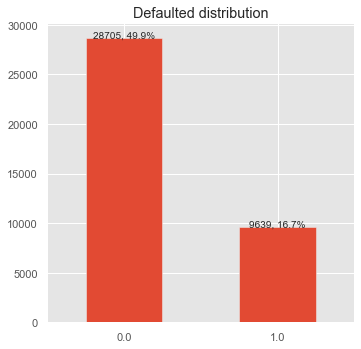

In [133]:
# plot distribution
data = train.loc[train['nrofdependants'].isna(), 'defaulted'].value_counts()

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(5.5, 5.5))
data.plot(kind='bar', rot=0, title='Defaulted distribution')

for i, v in enumerate(data):
    plt.text(i, v+1, str(round(v, 2))+', '+str(round(v/len(train), 3)*100)+'%', horizontalalignment='center')

plt.show()

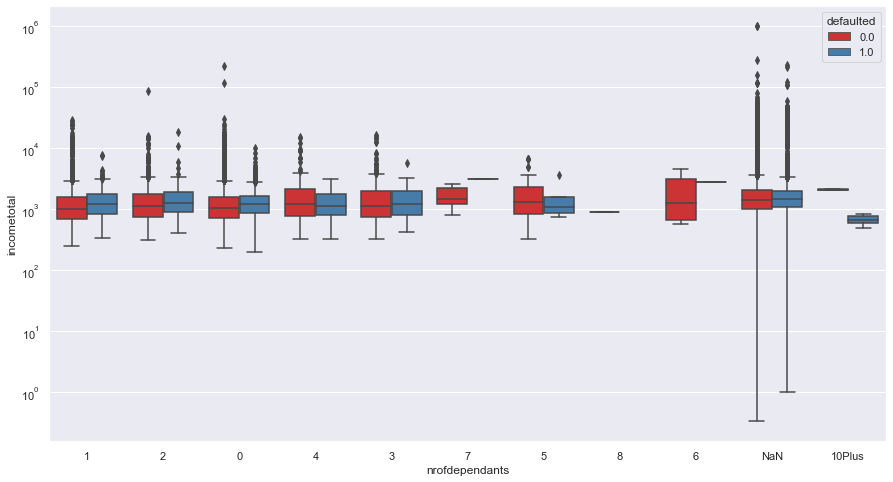

In [134]:
grouped_boxplot('nrofdependants', 'incometotal', yscale='log')

We also see that there is a difference in the distribution of the target feature for the missing `nrofdependants` records. It is unlikely that the data is MCAR, and more possibly MNAR and MAR.

In [135]:
# make copy of data data
x = train.copy()

# relabel those with nan values as -1
x.loc[x['nrofdependants'].isna(), 'nrofdependants'] = '-1'

# relabel those with non-nan values as 1
x.loc[x['nrofdependants'] != '-1', 'nrofdependants'] = '1'

# create a contigency table between the defaulted status and the presence/absence of homeownershiptype
table = pd.crosstab(x["nrofdependants"], x["defaulted"]).to_numpy()
table

array([[28705,  9639],
       [15766,  3465]], dtype=int64)

In [136]:
chi_square(table)
cramers_v(table)

probability = 0.950, critical = 3.841, stat = 368.969
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)
0.07994517527894814


0.07994517527894814

The conclusions of the chi-square test and the cramers_v test are similar to that of the `homeownershiptype` feature. It is unlikely that the `nrofdependants` feature is MCAR.

It is a fairly common occurence for applicants not to provide such personal information if they deem that the feature is not important to the credit application. In such a case, we may consider assigning them to a unique value, e.g. unknown. However, this may increase the variance in the data and may negatively affect the performance of the ML model.

Alternatively, we can remove the feature as it is missing a huge proportion and imputation may only increase the error introduced.

As earlier discussed, we can also consider reconsolidating the lower occurence categories to better represent them 

In [137]:
# consolidate categories with counts less than 1%
train['nrofdependants'].value_counts(dropna=False) < 0.01*len(train)

NaN       False
0         False
1         False
2         False
3         False
4          True
5          True
7          True
6          True
10Plus     True
8          True
Name: nrofdependants, dtype: bool

In [138]:
# consolidate all the classes above 3 into new class 3Plus, we will first impute the NaN with a new class 'unspecified'
train['nrofdependants'] = train['nrofdependants'].fillna('unspecified')

In [139]:
# new classes
new_class = ['unspecified', '0', '1', '2', '3', '3Plus']

train.loc[~train['nrofdependants'].isin(new_class), 'nrofdependants'] = '3Plus'

In [140]:
train['nrofdependants'].value_counts(dropna=False)

unspecified    38344
0              10948
1               4447
2               2662
3                842
3Plus            332
Name: nrofdependants, dtype: int64

0.09080691896964783
probability = 0.950, critical = 11.070, stat = 479.749
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


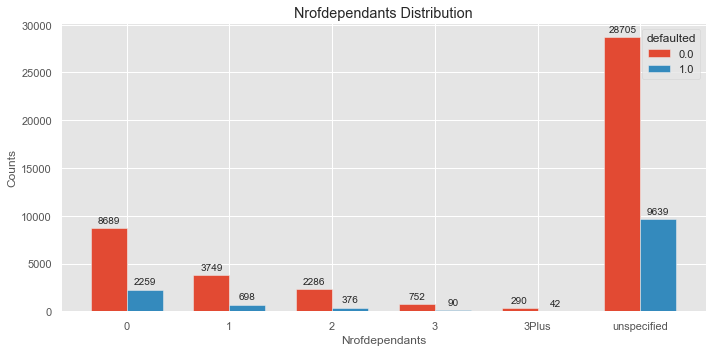

In [141]:
cat_plot('nrofdependants', df=train)

We see that the correlation has improved slightly

### Workexperience (Cat - Ordinal)

We found that there was 66.9% missing values in the workexperience feature. We also found that the categorical feature values are a little complicated.

- LessThan2Years
- 2To5Years
- 5To10Years
- 15To25Years
- 10To15Years
- MoreThan25Years



0.04469423370429841
probability = 0.950, critical = 11.070, stat = 43.116
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


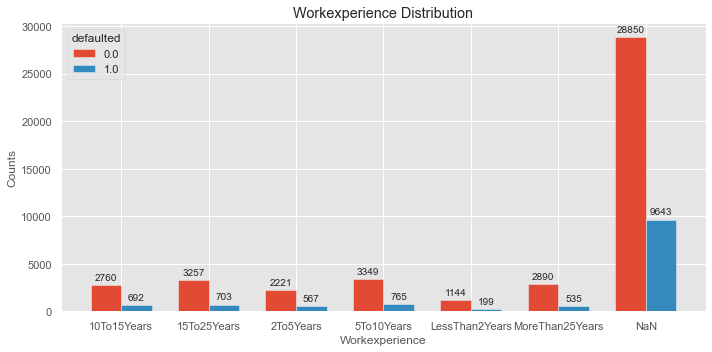

In [142]:
cat_plot('workexperience', df=train)

We see that the correlation with the target variable is rather weak

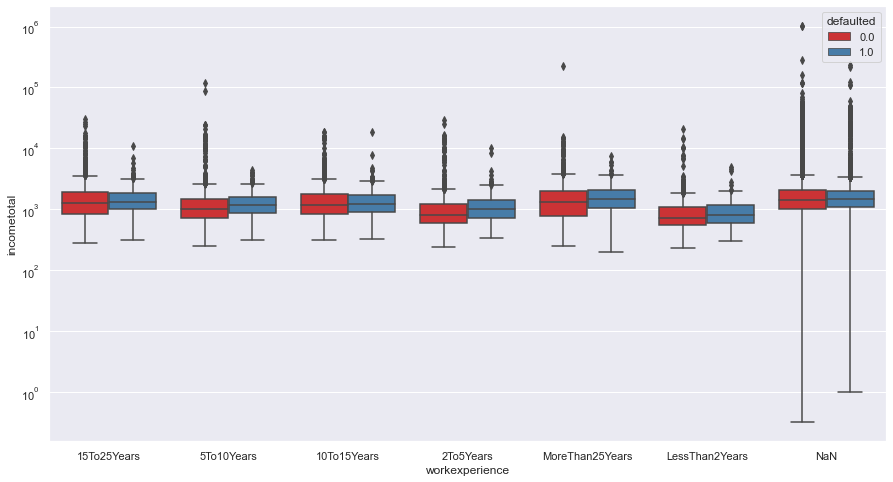

In [143]:
grouped_boxplot('workexperience', 'incometotal', yscale='log')

The variable is an ordinal one. Lets first pass the feature through the fill_with_earlier function

In [144]:
train = fill_with_earlier(data=train, database=db_df, data_var='workexperience', database_var='WorkExperience', lowercase=True)

In [145]:
train['workexperience'].value_counts(dropna=False)

NaN                37881
5To10Years          4225
15To25Years         4112
10To15Years         3582
MoreThan25Years     3544
2To5Years           2869
LessThan2Years      1362
Name: workexperience, dtype: int64

Once again, we find that there are still a large number of missing values. We have 2 options as with `nrofdependants`, i.e. to drop the feature or to impute with a new missing value.

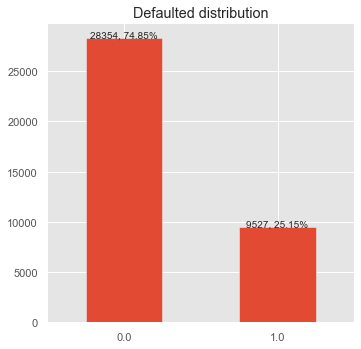

In [146]:
# plot distribution
data = train.loc[train['workexperience'].isna(), 'defaulted'].value_counts(dropna=False)

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(5.5, 5.5))
data.plot(kind='bar', rot=0, title='Defaulted distribution')

for i, v in enumerate(data):
    plt.text(i, v+1, str(round(v, 2))+', '+str(round(v/37881 *100, 2))+'%', horizontalalignment='center')

plt.show()

In [147]:
# make copy of data data
x = train.copy()

# relabel those with nan values as -1
x.loc[x['workexperience'].isna(), 'workexperience'] = -1

# relabel those with non-nan values as 1
x.loc[x['workexperience'] != -1, 'workexperience'] = 1

# create a contigency table between the defaulted status and the presence/absence of homeownershiptype
table = pd.crosstab(x["workexperience"], x["defaulted"]).to_numpy()
table

array([[28354,  9527],
       [16117,  3577]], dtype=int64)

In [148]:
cramers_v(table)
chi_square(table)

0.0789008784599614
probability = 0.950, critical = 3.841, stat = 359.418
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


We see that the missing values does have some weak association with the target variable. 

In [149]:
# impute with unspecified
train['workexperience'] = train['workexperience'].fillna('unspecified')

In [150]:
train['workexperience'].value_counts(dropna=False)

unspecified        37881
5To10Years          4225
15To25Years         4112
10To15Years         3582
MoreThan25Years     3544
2To5Years           2869
LessThan2Years      1362
Name: workexperience, dtype: int64

0.08229506400743242
probability = 0.950, critical = 12.592, stat = 395.919
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


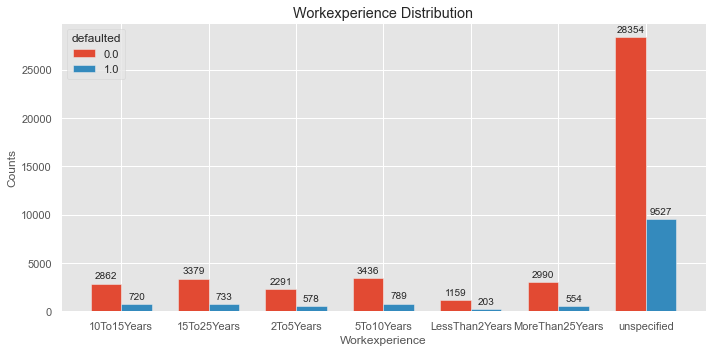

In [151]:
cat_plot('workexperience', df=train)

We see that imputation with another missing value improves correlation

### Maritalstatus (Cat - Nominal)

We found that `marital status` has a high amount of undefined value, -1 (66.8%), which likely resulted in a high correlation with `employmentstatus`. The feature should also be a categorical nominal variable.

- 1 : Married 
- 2 : Cohabitant
- 3 : Single
- 4 : Divorced
- 5 : Widow


Lets first explore the feature:

0.10836618570806218
probability = 0.950, critical = 11.070, stat = 681.105
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


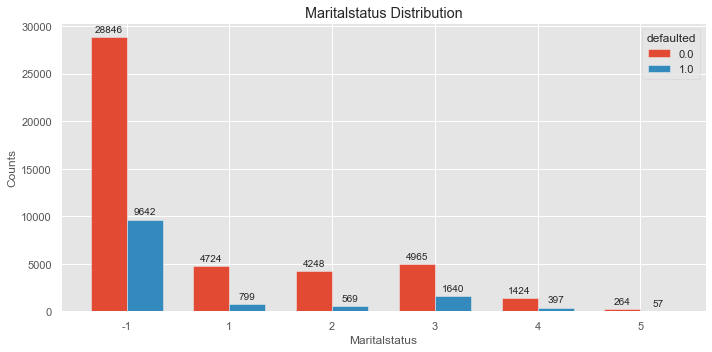

In [152]:
cat_plot('maritalstatus', df=train)

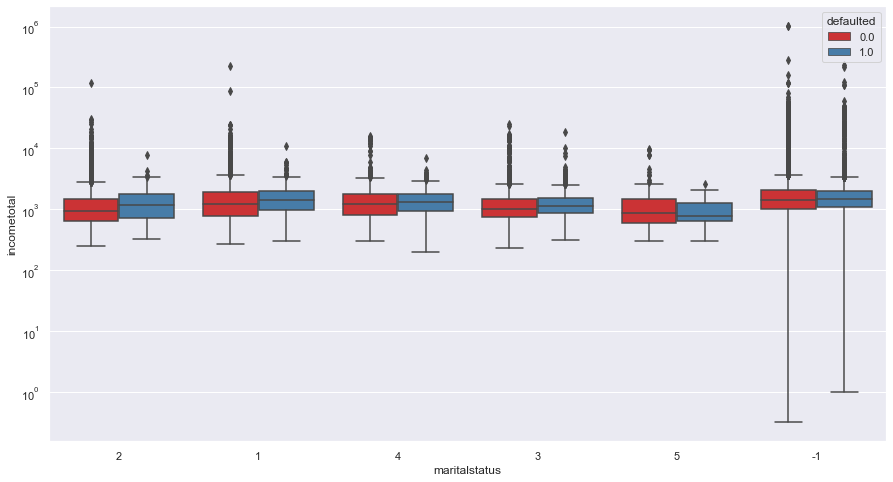

In [153]:
grouped_boxplot('maritalstatus', 'incometotal', yscale='log')

Lets check what the -1 values represent, first by taking a look at some examples

In [154]:
train[train['maritalstatus'] == '-1'].head()

defaulted                                loanid   username  \
19084        1.0  BFE13908-43DE-4183-A7B2-A7850009D853  BO765A111   
19085        0.0  9E233421-10BD-4EBA-B5CC-A785008AFE67  BO3672293   
19089        1.0  4A7AF85B-9DA8-40A8-A5B3-A78500B31B7B  BO53K2471   
19090        0.0  D96A24D8-2E97-483A-AD75-A78500CF9030  BOA9A2471   
19091        0.0  C2B425D2-1C94-463C-91FE-A78500E32734  BO1112471   

      loanapplicationstarteddate languagecode   age gender country  \
19084        2017-06-01 00:35:00            6  36.0      2      ES   
19085        2017-06-01 08:26:00            1  32.0      1      EE   
19089        2017-06-01 10:52:00            6  35.0      2      ES   
19090        2017-06-01 12:35:00            3  42.0      1      EE   
19091        2017-06-01 13:47:00            4  43.0      0      FI   

       appliedamount  interest  ...  incomefromothers existingliabilities  \
19084         2550.0    118.20  ...               0.0                 9.0   
19085         1700.0     26.78  ...               0.0                 7.0   
19089          530.0    218.01  ...               0.0                12.0   
19090         6590.0     15.78  ...               0.0                 4.0   
19091         5315.0     38.91  ...               0.0                11.0   

      liabilitiestotal debttoincome noofearlierdefaults  \
19084          2223.35          0.0                 0.0   
19085           754.91          0.0                 0.0   
19089          1312.24          0.0                 0.0   
19090           965.68          0.0                 0.0   
19091          1839.34          0.0                 0.0   

      noofpreviousloansbeforeloan amountofpreviousloansbeforeloan  \
19084                         0.0                             0.0   
19085                         1.0                          1060.0   
19089                         0.0                             0.0   
19090                         0.0                             0.0   
19091                         0.0                             0.0   

      priorrepayments previousearlyrepaymentsbeforeloan  \
19084            0.00                               0.0   
19085          118.95                               0.0   
19089            0.00                               0.0   
19090            0.00                               0.0   
19091            0.00                               0.0   

       previousearlyrepaymentscountbeforeloan  
19084                                     0.0  
19085                                     0.0  
19089                                     0.0  
19090                                     0.0  
19091                                     0.0  

[5 rows x 31 columns]

There does not seem to be any discernable issue. Lets run it through the fill_with_earlier function, to see if there are any earlier value for these `username`s.

In [155]:
# run through the fill_with_earlier
train = fill_with_earlier(data=train, database = db_df, data_var='maritalstatus', database_var='MaritalStatus', fill_val=['-1'], lowercase=True)

In [156]:
train['maritalstatus'].value_counts(dropna=False)

NaN    37876
3       6804
1       5706
2       4978
4       1877
5        334
Name: maritalstatus, dtype: int64

Here we see that there are still a large number of rows (> 60%) with undefined `maritalstatus` values, of which we have two options, impute with a new missing class for the variable or drop the variable all together.

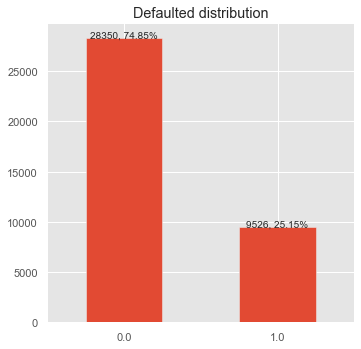

In [157]:
# plot distribution
data = train.loc[train['maritalstatus'].isna(), 'defaulted'].value_counts(dropna=False)

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(5.5, 5.5))
data.plot(kind='bar', rot=0, title='Defaulted distribution')

for i, v in enumerate(data):
    plt.text(i, v+1, str(round(v, 2))+', '+str(round(v/37876 *100, 2))+'%', horizontalalignment='center')

plt.show()

In [158]:
# make copy of data data
x = train.copy()

# relabel those with nan values as -1
x.loc[x['maritalstatus'].isna(), 'maritalstatus'] = -1

# relabel those with non-nan values as 1
x.loc[x['maritalstatus'] != -1, 'maritalstatus'] = 1

# create a contigency table between the defaulted status and the presence/absence of homeownershiptype
table = pd.crosstab(x["maritalstatus"], x["defaulted"]).to_numpy()

cramers_v(table)
chi_square(table)

0.07890812396661277
probability = 0.950, critical = 3.841, stat = 359.484
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


In [159]:
# lets impute with unspecified value
train['maritalstatus']=train['maritalstatus'].fillna('unspecified')

0.10953172963508472
probability = 0.950, critical = 11.070, stat = 695.727
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


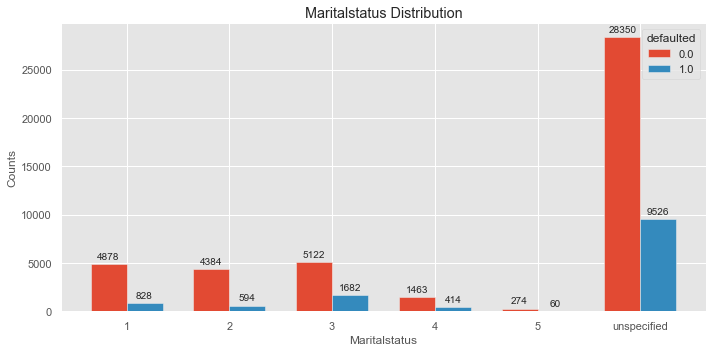

In [160]:
cat_plot('maritalstatus', df=train)

### Education (Cat - Ordinal)

`education` feature was found to have instances of values (-1) which are undefined in the data dictionary and should be redefined as categorical ordinal value:

- 1 : Primary education 
- 2 : Basic education 
- 3 : Vocational education 
- 4 : Secondary education
- 5 : Higher education


0.03640390686337447
probability = 0.950, critical = 11.070, stat = 81.300
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


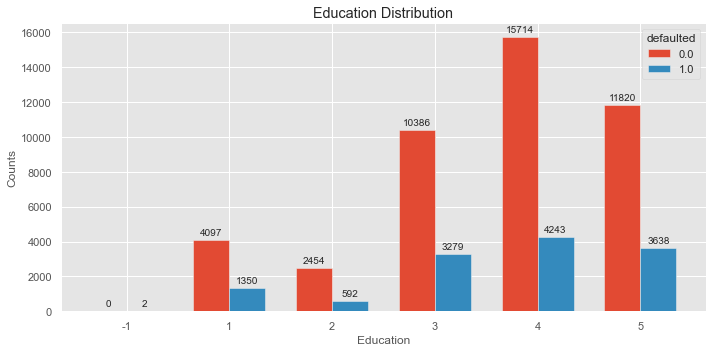

In [161]:
cat_plot('education', df=train)

Lets pass it through the fill_with_earlier function

In [162]:
train = fill_with_earlier(data=train,database = db_df, data_var='education', database_var='Education', fill_val=['-1'], lowercase=True)

In [163]:
train['education'].value_counts(dropna=False)

4      19957
5      15458
3      13665
1       5447
2       3046
NaN        2
Name: education, dtype: int64

We find that the 2 instances of -1 `education` values belong to `username`s who do not have any prior records with valid `education` values

In [164]:
train[train['education'].isna()]

defaulted                                loanid   username  \
21844        1.0  BB82FE36-30C5-4BFB-B91A-A7ED00F4D5FF  BOKK94231   
25170        1.0  0C0ED9DE-AC3F-4B4F-8DF3-A880013A1E38  BO627A5A7   

      loanapplicationstarteddate languagecode   age gender country  \
21844        2017-09-13 14:51:00            6  57.0      0      ES   
25170        2018-02-07 19:04:00            1  68.0      0      EE   

       appliedamount  interest  ...  incomefromothers existingliabilities  \
21844          530.0    146.36  ...               0.0                 0.0   
25170        10630.0     31.35  ...               0.0                 0.0   

      liabilitiestotal debttoincome noofearlierdefaults  \
21844              0.0          0.0                 0.0   
25170              0.0          0.0                 0.0   

      noofpreviousloansbeforeloan amountofpreviousloansbeforeloan  \
21844                         0.0                             0.0   
25170                         0.0                             0.0   

      priorrepayments previousearlyrepaymentsbeforeloan  \
21844             0.0                               0.0   
25170             0.0                               0.0   

       previousearlyrepaymentscountbeforeloan  
21844                                     0.0  
25170                                     0.0  

[2 rows x 31 columns]

We find that these 2 loan applications also contain many undefined or missing values in the other features such as `maritalstatus`, `nrofdependants`, `employmentstatus`, `occupationarea` and `workexperience`. We will decide what to do with these later.

For the missing values, we will impute them with the mode.

In [165]:
# use simpleimputer
# create instance
imp_mode = SimpleImputer(missing_values = np.nan, strategy='most_frequent') # mode
# fit to train[['test']]
imp_mode.fit(train[['education']])
train['education'] = imp_mode.transform(train[['education']])

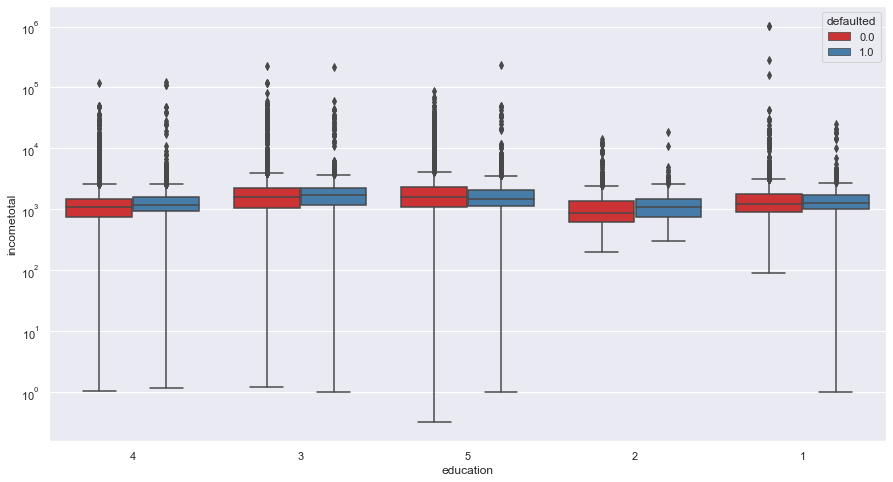

In [166]:
grouped_boxplot('education', 'incometotal', yscale='log')

0.034930149697584394
probability = 0.950, critical = 9.488, stat = 74.247
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


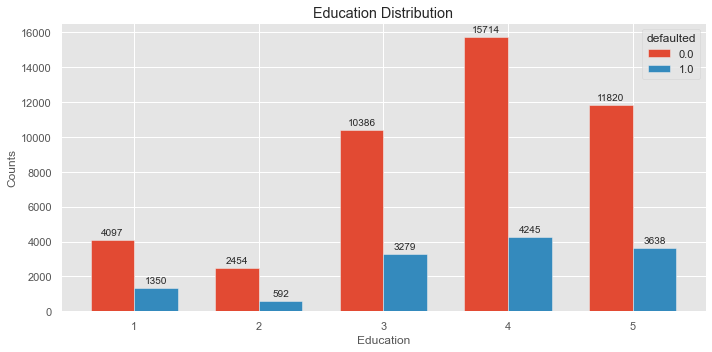

In [167]:
cat_plot('education', df=train)

### Employmentdurationcurrentemployer (Cat - Nominal)

`employmentdurationcurrentemployer` has 0.5% missing values and is a categorical value with a large number of classes. Given that there is no clear distinction/superiority of one over the other, it is a nominal variable:
- TrialPeriod
- UpTo1Year
- UpTo2Years
- UpTo3Years
- UpTo4Years
- UpTo5Years
- MoreThan5Years
- Retiree
- Other

0.04102977227454707
probability = 0.950, critical = 15.507, stat = 104.392
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


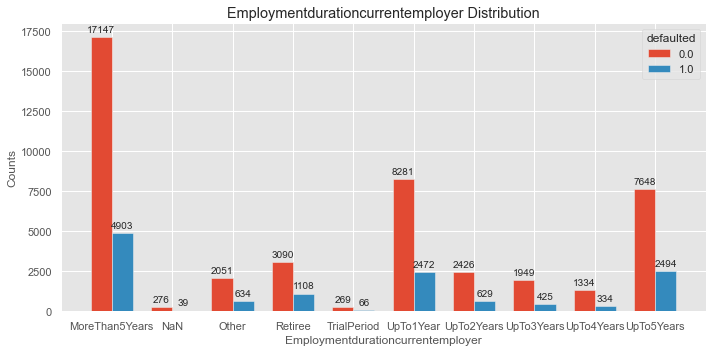

In [168]:
cat_plot('employmentdurationcurrentemployer', df=train)

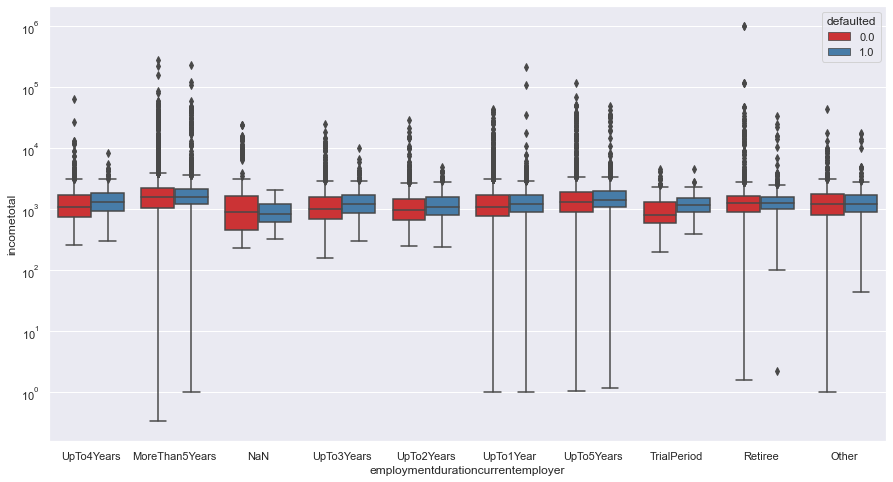

In [169]:
grouped_boxplot('employmentdurationcurrentemployer', 'incometotal', yscale='log')

Lets look at the distribution of the target variable when the values are nan.

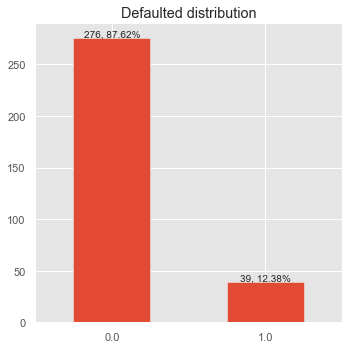

In [170]:
# plot distribution
data = train.loc[train['employmentdurationcurrentemployer'].isna(), 'defaulted'].value_counts(dropna=False)

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(5.5, 5.5))
data.plot(kind='bar', rot=0, title='Defaulted distribution')

for i, v in enumerate(data):
    plt.text(i, v+1, str(round(v, 2))+', '+str(round(v/315 *100, 2))+'%', horizontalalignment='center')

plt.show()

Lets run it through the fill_with_earlier function

In [171]:
train = fill_with_earlier(data=train,database = db_df, data_var='employmentdurationcurrentemployer', database_var='EmploymentDurationCurrentEmployer', lowercase=True)

In [172]:
train['employmentdurationcurrentemployer'].value_counts(dropna=False)

MoreThan5Years    22055
UpTo1Year         10760
UpTo5Years        10143
Retiree            4198
UpTo2Years         3064
Other              2685
UpTo3Years         2376
UpTo4Years         1668
TrialPeriod         335
NaN                 291
Name: employmentdurationcurrentemployer, dtype: int64

We see that there are still a number of missing values. For these, we will impute with the mode values as the base model

In [173]:
# use simpleimputer
# create instance
imp_mode = SimpleImputer(missing_values = np.nan, strategy='most_frequent') # mode
# fit to train[['test']]
imp_mode.fit(train[['employmentdurationcurrentemployer']])
train['employmentdurationcurrentemployer'] = imp_mode.transform(train[['employmentdurationcurrentemployer']])

0.041495354308136355
probability = 0.950, critical = 15.507, stat = 107.135
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


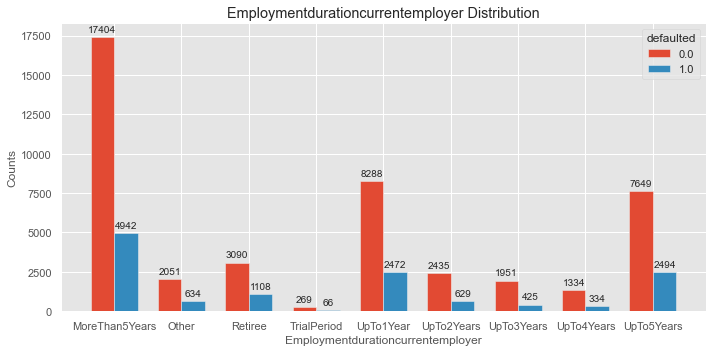

In [174]:
cat_plot('employmentdurationcurrentemployer', df=train)

### Employmentstatus (Cat - Nominal)

`employmentstatus`has a high amount of undefined value (-1, 0), 66.8% with 0.1% mising values and is a categorical nominal variable.
- 1 Unemployed 
- 2 Partially employed 
- 3 Fully employed 
- 4 Self-employed 
- 5 Entrepreneur 
- 6 Retiree

0.08539844981754582
probability = 0.950, critical = 12.592, stat = 425.648
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


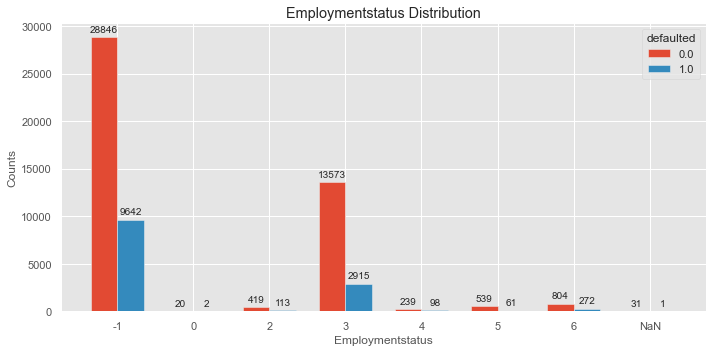

In [175]:
cat_plot('employmentstatus', df=train)

We will classify -1, nan and 0 values as undefined, and we will pass these to the fill_with_earlier function

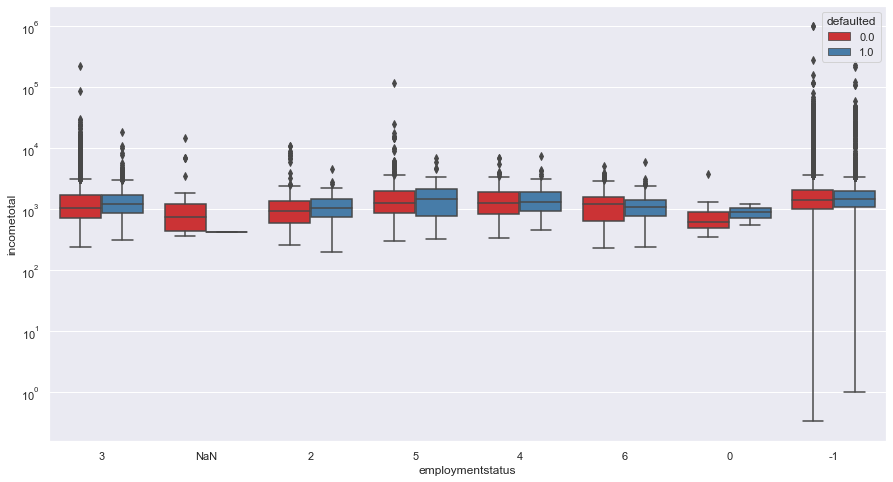

In [176]:
grouped_boxplot('employmentstatus', 'incometotal', yscale='log')

In [177]:
train = fill_with_earlier(data=train,database = db_df, data_var='employmentstatus', database_var='EmploymentStatus', fill_val=['0','-1'], lowercase=True)

In [178]:
train['employmentstatus'].value_counts(dropna=False)

NaN    37924
3      17000
6       1114
5        622
2        550
4        365
Name: employmentstatus, dtype: int64

For the remaining missing values, we will either impute with a new missing value category or remove the feature.

In [179]:
# make copy of data data
x = train.copy()

# relabel those with nan values as -1
x.loc[x['employmentstatus'].isna(), 'employmentstatus'] = '-1'

# relabel those with non-nan values as 1
x.loc[x['employmentstatus'] != '-1', 'employmentstatus'] = '1'

# create a contigency table between the defaulted status and the presence/absence of homeownershiptype
table = pd.crosstab(x["employmentstatus"], x["defaulted"]).to_numpy()

cramers_v(table)
chi_square(table)
table

0.07817372720020853
probability = 0.950, critical = 3.841, stat = 352.842
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


array([[28396,  9528],
       [16075,  3576]], dtype=int64)

In [181]:
# impute with unspecified
train['employmentstatus'] = train['employmentstatus'].fillna('unspecified')

0.08661610650909023
probability = 0.950, critical = 11.070, stat = 436.940
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


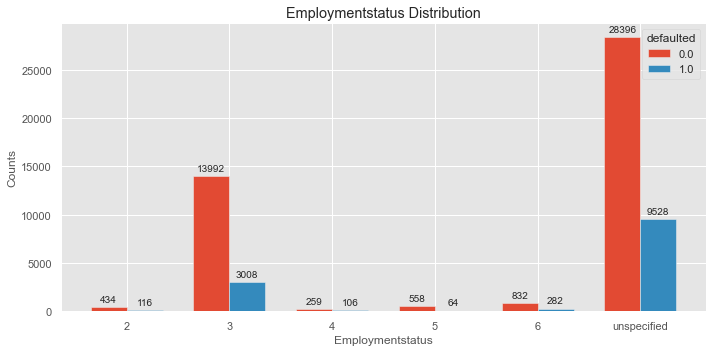

In [182]:
cat_plot('employmentstatus', df=train)

### Occupationarea (Cat - Nominal)

`occupationarea` was found to have a high amount of undefined value (-1) - 66.9% and is a categorical nominal variable with a large number of classes:

- 1 Other 
- 2 Mining 
- 3 Processing 
- 4 Energy 
- 5 Utilities 
- 6 Construction 
- 7 Retail and wholesale 
- 8 Transport and warehousing 
- 9 Hospitality and catering 
- 10 Info and telecom 
- 11 Finance and insurance 
- 12 Real-estate 
- 13 Research 
- 14 Administrative 
- 15 Civil service & military 
- 16 Education 
- 17 Healthcare and social help 
- 18 Art and entertainment 
- 19 Agriculture, forestry and fishing

0.0961164035285575
probability = 0.950, critical = 30.144, stat = 550.890
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


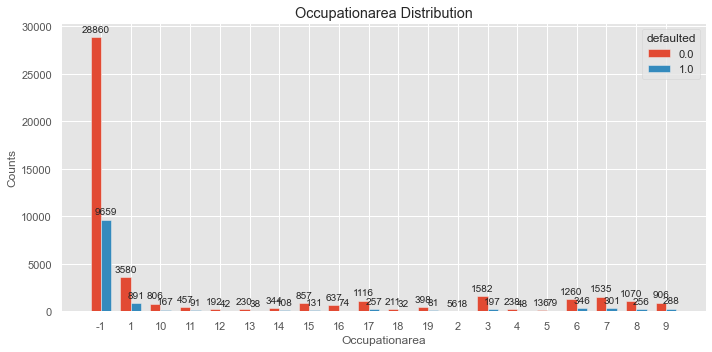

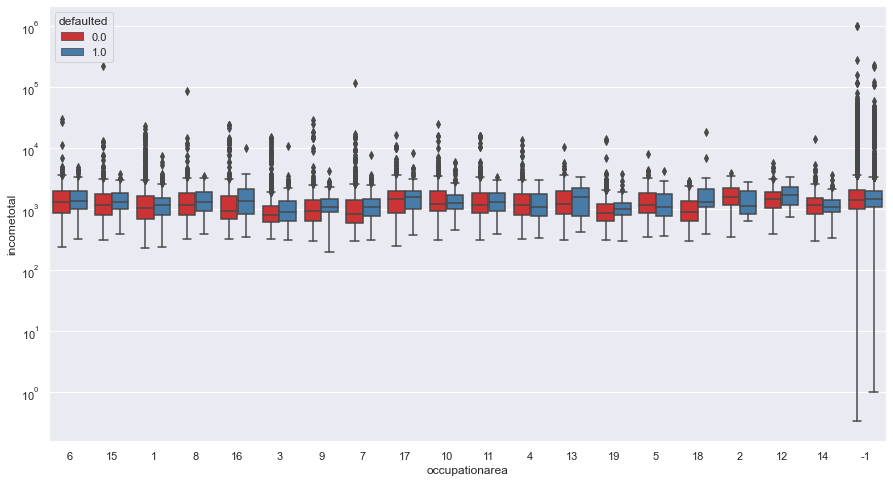

In [183]:
cat_plot('occupationarea', df=train)
grouped_boxplot('occupationarea', 'incometotal', yscale='log')

We will classify -1 value as undefined, and we will pass these to the fill_with_earlier function

In [184]:
train = fill_with_earlier(data=train, database = db_df, data_var='occupationarea', database_var='OccupationArea', fill_val=['-1'], lowercase=True)

In [185]:
train['occupationarea'].value_counts(dropna=False)

NaN    37906
1       4640
7       1889
3       1810
6       1658
17      1430
8       1369
9       1237
15      1007
10       995
16       736
11       570
19       503
14       463
4        299
13       284
18       246
12       241
5        217
2         75
Name: occupationarea, dtype: int64

For the remaining missing values, we will either impute with a new missing value category or remove the feature.

In [186]:
# make copy of train data
x = train.copy()

# relabel those with nan values as -1
x.loc[x['occupationarea'].isna(), 'occupationarea'] = '-1'

# relabel those with non-nan values as 1
x.loc[x['occupationarea'] != '-1', 'occupationarea'] = '1'

# create a contigency table between the defaulted status and the presence/absence of homeownershiptype
table = pd.crosstab(x["occupationarea"], x["defaulted"]).to_numpy()

chi_square(table)
cramers_v(table)
table

probability = 0.950, critical = 3.841, stat = 367.077
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)
0.07973936576154543


array([[28364,  9542],
       [16107,  3562]], dtype=int64)

In [187]:
train['occupationarea'] = train['occupationarea'].fillna('unspecified')

### Languagecode (Cat - Nominal)

`languagecode` has a number of Instances of values (7, 10, 13, 15, 21, 22) which are undefined in the data dictionary. It is also a nominal categorical variable.

- 1 : Estonian
- 2 : English
- 3 : Russian
- 4 : Finnish
- 5 : German
- 6 : Spanish
- 9 : Slovakian

0.3004197006017377
probability = 0.950, critical = 21.026, stat = 5208.169
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


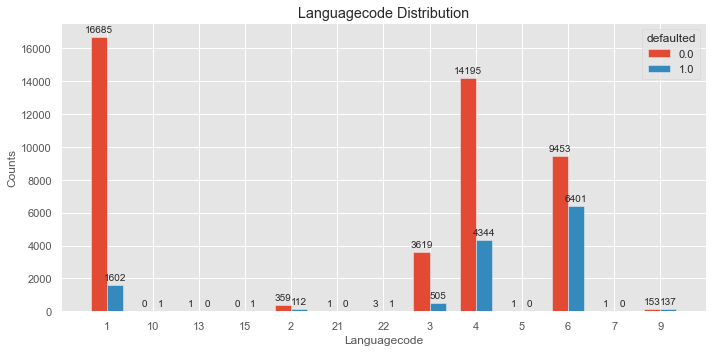

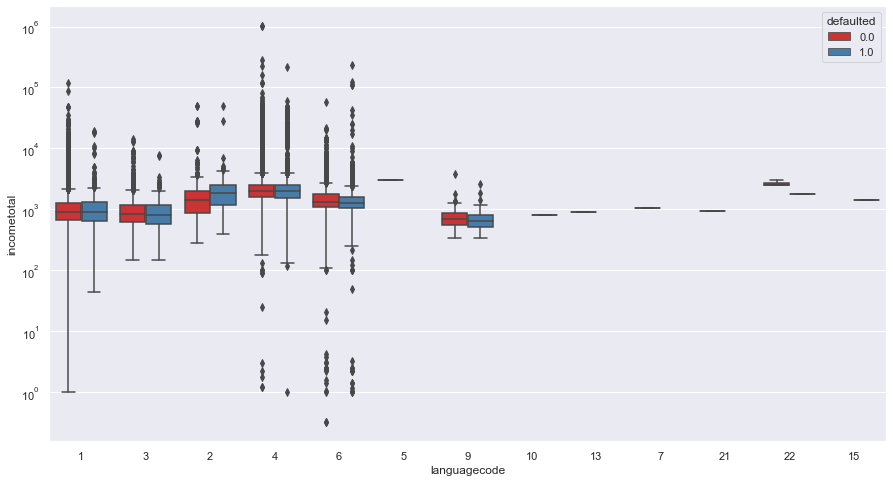

In [188]:
cat_plot('languagecode', df=train)
grouped_boxplot('languagecode', 'incometotal', yscale='log')

Raher high association with defaulted. Pass these undefined values to the fill_with_earlier function

In [189]:
train['languagecode'].value_counts(dropna=False)

4     18539
1     18287
6     15854
3      4124
2       471
9       290
22        4
13        1
15        1
5         1
10        1
21        1
7         1
Name: languagecode, dtype: int64

In [190]:
train = fill_with_earlier(data=train,database = db_df, data_var='languagecode', database_var='LanguageCode', fill_val=['7', '10', '13', '15','21','22'], lowercase=True)

In [191]:
train['languagecode'].value_counts(dropna=False)

4      18539
1      18287
6      15854
3       4124
2        471
9        290
NaN        9
5          1
Name: languagecode, dtype: int64

We find that these values belong to `username` which have no other prior defined `languagecode` values. Because they have such a small occurence, we will impute them as a seprate class - others.

For the low occurence values, we will also consolidate them into the 'others' class.

In [192]:
# consolidate categories with counts less than 1%
train['languagecode'].value_counts(dropna=False) < 0.01*len(train)

4      False
1      False
6      False
3      False
2       True
9       True
NaN     True
5       True
Name: languagecode, dtype: bool

In [193]:
x = train.copy()

new_col = ['1', '2', '3', '4', '6', '9', 'others']
x.loc[~x['languagecode'].isin(new_col), 'languagecode'] = 'others'
x['languagecode'].value_counts(dropna=False)

4         18539
1         18287
6         15854
3          4124
2           471
9           290
others       10
Name: languagecode, dtype: int64

0.3003711551911076
probability = 0.950, critical = 12.592, stat = 5200.489
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


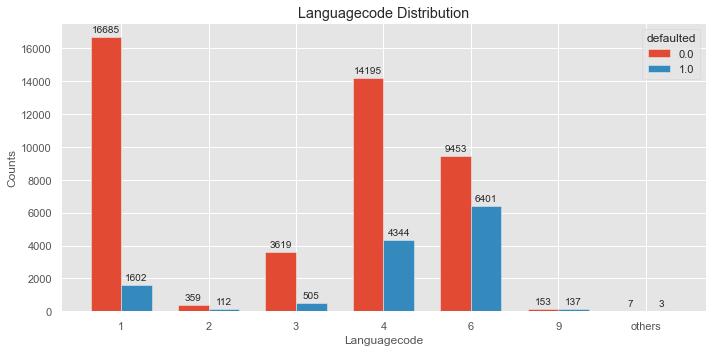

In [194]:
cat_plot('languagecode', df=x)

### Country (Cat - Nominal)

We found that `country` has a very high correlation with `languagecode` which is reasonable.

- EE Estonia
- FI Finland
- ES Spain
- SK Slovakia

0.301340361749205
probability = 0.950, critical = 7.815, stat = 5231.065
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


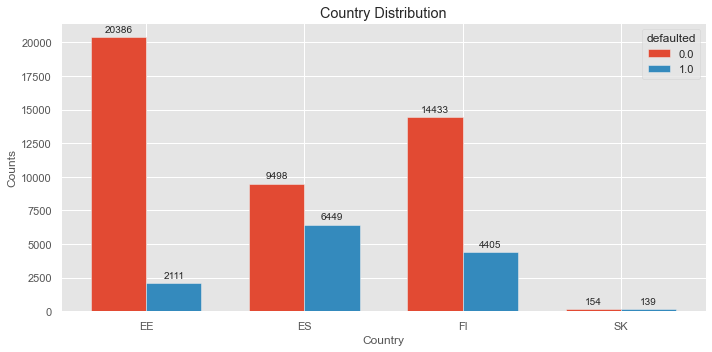

In [195]:
cat_plot('country', df=train)

In [196]:
train['country'].value_counts(dropna=False)

EE    22497
FI    18838
ES    15947
SK      293
Name: country, dtype: int64

In [197]:
table = pd.crosstab(train['country'], train['languagecode'])
table

languagecode      1    2     3      4  5      6    9
country                                             
EE            18167  218  4097     14  0      1    0
ES                5   82     2      1  1  15853    0
FI              114  171    25  18524  0      0    0
SK                1    0     0      0  0      0  290

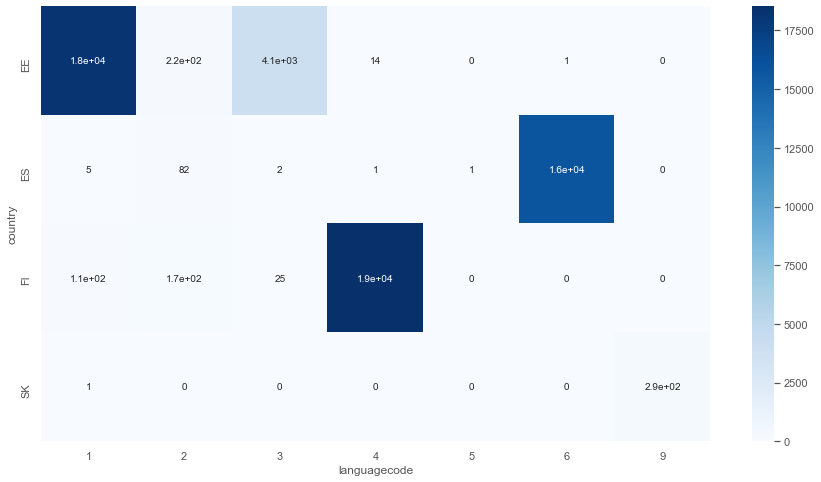

In [198]:
sns.heatmap(table, cmap="Blues", annot=True)
plt.show()

In [199]:
cramers_v(table.to_numpy())

0.9942028009296539


0.9942028009296539

In [200]:
chi_square(table.to_numpy())

probability = 0.950, critical = 28.869, stat = 170710.579
Dependent (reject H0)
significance = 0.050, p = 0.000
Dependent (reject H0)


Here we find that the two features `country` and `languagecode` are indeed highly correlated. We may wish to remove one of them at a later stage.